# LGBM Draft (Base Fields Only)

Train/val/test split = 0.6/0.2/0.2, label = next-day TWAP return.

In [104]:
import re
from pathlib import Path
import numpy as np
import pandas as pd

# Optional: set repo root manually
# repo_root = Path('C:/Users/BaiYang/CBOND_DAY')
repo_root = None

root = Path.cwd()
if repo_root is None:
    while root != root.parent and not (root / 'cbond_daily').exists():
        root = root.parent
    if not (root / 'cbond_daily').exists():
        raise FileNotFoundError('Cannot find repo root containing cbond_daily. Set repo_root explicitly.')
else:
    root = repo_root

# Load paths_config.json5 (minimal parsing)
paths_cfg = root / 'cbond_daily' / 'config' / 'paths_config.json5'
text = paths_cfg.read_text(encoding='utf-8')

m = re.search(r'dwd_root\s*:\s*"([^"]+)"', text)
if not m:
    raise ValueError('Cannot parse dwd_root from paths_config.json5')

dwd_root = Path(m.group(1))
print('dwd_root:', dwd_root)


dwd_root: D:\cbond_daily\clean_data


In [105]:
# Settings
import warnings
warnings.filterwarnings('ignore')

start = '2024-01-01'
end = '2026-01-12'

# label uses t+1 prices
buy_twap_col = 'twap_0945_1000'
sell_twap_col = 'twap_1430_1442'

# model params (tunable)
params = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 63,
    'max_depth': 20,
    'min_data_in_leaf': 200,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.01,
    'lambda_l2': 0.01,
    'n_estimators': 1000,
    'random_state': 42,
    'verbose': -1,
}

# GPU settings (set True if LightGBM GPU build is installed)
use_gpu = True
if use_gpu:
    params.update({
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
    })


In [106]:
# Load cleaned data range
from datetime import datetime

def read_clean_range(root: Path, start_date: str, end_date: str) -> pd.DataFrame:
    frames = []
    for day in pd.date_range(start_date, end_date, freq='D'):
        month = f"{day.year:04d}-{day.month:02d}"
        path = root / month / f"{day.strftime('%Y%m%d')}.parquet"
        if path.exists():
            frames.append(pd.read_parquet(path))
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

raw = read_clean_range(dwd_root, start, end)
print('rows:', len(raw))
raw.head()


rows: 447704


,instrument_code,exchange_code,trade_date,prev_close_price,close_price,amount,code,twap_0930_1000,twap_1430_1500,twap_0945_1000,...,base_stk_close_price,base_year_to_mat,base_ytm,base_in_trigger_process,base_conv_value,base_pure_redemption_value,rating_rating,info_instrument_id,info_stock_code,info_instrument_name
0,110003,SZ,2024-01-02,100.0,100.0,0.0,110003.SZ,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None
1,110004,SZ,2024-01-02,100.0,100.0,0.0,110004.SZ,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None
2,110005,SZ,2024-01-02,100.0,100.0,0.0,110005.SZ,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None
3,110006,SZ,2024-01-02,100.0,100.0,0.0,110006.SZ,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None
4,110007,SZ,2024-01-02,100.0,100.0,0.0,110007.SZ,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None


In [107]:
# Build features (base fields only)
base_cols = [
    'close_price', 'prev_close_price', 'amount',
    'base_bond_prem_ratio', 'base_stk_close_price',
    'base_year_to_mat', 'base_ytm',
    'base_in_trigger_process', 'base_conv_value', 'base_pure_redemption_value'
]

# required columns
req = ['trade_date', 'code'] + base_cols + [buy_twap_col, sell_twap_col]
missing = [c for c in req if c not in raw.columns]
if missing:
    raise KeyError(f'missing columns: {missing}')

work = raw[req].copy()
work['trade_date'] = pd.to_datetime(work['trade_date']).dt.date

# derived features
work['ret_1d'] = work['close_price'] / work['prev_close_price'] - 1.0
work['opt_value'] = work['close_price'] - work['base_pure_redemption_value']
work['ovr'] = work['opt_value'] / work['base_conv_value'].replace(0.0, np.nan)
work['stk_ret_1d'] = work['base_stk_close_price'] / work.groupby('code')['base_stk_close_price'].shift(1) - 1.0

# log features
for col in ['amount', 'base_conv_value', 'base_pure_redemption_value', 'close_price']:
    work[f'log_{col}'] = np.log1p(work[col].clip(lower=0))

feature_cols = base_cols + ['ret_1d','opt_value','ovr','stk_ret_1d'] + [f'log_{c}' for c in ['amount','base_conv_value','base_pure_redemption_value','close_price']]

# zscore by trade_date (no leakage)
for col in feature_cols:
    work[col] = work.groupby('trade_date')[col].transform(lambda s: (s - s.mean()) / s.std(ddof=0))

work.replace([np.inf, -np.inf], np.nan, inplace=True)

work.head()


,trade_date,code,close_price,prev_close_price,amount,base_bond_prem_ratio,base_stk_close_price,base_year_to_mat,base_ytm,base_in_trigger_process,...,twap_0945_1000,twap_1430_1442,ret_1d,opt_value,ovr,stk_ret_1d,log_amount,log_base_conv_value,log_base_pure_redemption_value,log_close_price
0,2024-01-02,110003.SZ,0.13142,0.133094,-0.228978,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.109163,NaN,NaN,NaN,-0.955719,NaN,NaN,0.396538
1,2024-01-02,110004.SZ,0.13142,0.133094,-0.228978,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.109163,NaN,NaN,NaN,-0.955719,NaN,NaN,0.396538
2,2024-01-02,110005.SZ,0.13142,0.133094,-0.228978,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.109163,NaN,NaN,NaN,-0.955719,NaN,NaN,0.396538
3,2024-01-02,110006.SZ,0.13142,0.133094,-0.228978,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.109163,NaN,NaN,NaN,-0.955719,NaN,NaN,0.396538
4,2024-01-02,110007.SZ,0.13142,0.133094,-0.228978,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.109163,NaN,NaN,NaN,-0.955719,NaN,NaN,0.396538


In [108]:
# Build label y(t+1)
# shift prices by one trading day per code
work['buy_twap_t1'] = work.groupby('code')[buy_twap_col].shift(-1)
work['sell_twap_t1'] = work.groupby('code')[sell_twap_col].shift(-1)
work['y'] = work['sell_twap_t1'] / work['buy_twap_t1'] - 1.0

# drop rows with any missing features or label
model_df = work[['trade_date','code'] + feature_cols + ['y']].dropna()
print('model rows:', len(model_df))
model_df.head()


model rows: 219052


,trade_date,code,close_price,prev_close_price,amount,base_bond_prem_ratio,base_stk_close_price,base_year_to_mat,base_ytm,base_in_trigger_process,...,base_pure_redemption_value,ret_1d,opt_value,ovr,stk_ret_1d,log_amount,log_base_conv_value,log_base_pure_redemption_value,log_close_price,y
1179,2024-01-03,110043.SH,0.237097,0.228209,0.513554,-0.706028,-0.703676,-2.420380,0.575391,8.159132,...,1.491422,0.339313,-0.463147,-1.158262,0.416335,1.245814,0.206716,1.459551,0.483636,0.000211
1180,2024-01-03,110044.SH,1.879280,1.870203,0.232510,2.351201,-0.686889,-2.146520,-6.855940,-0.122562,...,1.553804,0.055423,1.142941,4.392392,0.715494,1.184974,-0.256017,1.517184,1.425596,-0.002681
1181,2024-01-03,110045.SH,0.564687,0.533485,0.507152,-1.036903,-0.563085,-2.117112,-2.121105,-0.122562,...,0.509076,1.328332,-0.057151,-0.307509,0.801766,1.244724,1.089341,0.527971,0.726390,0.001436
1182,2024-01-03,110047.SH,0.304477,0.300910,-0.067911,-0.332317,-0.862103,-1.876336,0.585584,-0.122562,...,2.066439,0.026514,-0.446510,-1.097721,0.308686,1.035968,-0.091234,1.984235,0.536979,0.000447
1183,2024-01-03,110048.SH,1.053787,1.058546,0.707137,-1.042058,-0.512200,-1.846928,-2.774028,-0.122562,...,1.438514,-0.378919,0.342815,0.211828,0.495160,1.274778,1.679918,1.410533,1.026995,0.015630


In [109]:
# Time split: 0.6 / 0.2 / 0.2 by date
all_days = sorted(model_df['trade_date'].unique())
if len(all_days) < 10:
    raise ValueError('not enough days for split')

n = len(all_days)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

train_days = set(all_days[:train_end])
val_days = set(all_days[train_end:val_end])
test_days = set(all_days[val_end:])

train_df = model_df[model_df['trade_date'].isin(train_days)]
val_df = model_df[model_df['trade_date'].isin(val_days)]
test_df = model_df[model_df['trade_date'].isin(test_days)]

print('train/val/test rows:', len(train_df), len(val_df), len(test_df))


train/val/test rows: 140011 42223 36818


In [ ]:
# Optuna tuning (optional)
use_optuna = True
if use_optuna:
    try:
        import optuna
        import lightgbm as lgb
    except ImportError as exc:
        raise ImportError('optuna is not installed. Run: pip install optuna') from exc

    X_train = train_df[feature_cols]
    y_train = train_df['y']
    X_val = val_df[feature_cols]
    y_val = val_df['y']
    X_test = test_df[feature_cols]
    y_test = test_df['y']

    def objective(trial):
        trial_params = dict(params)
        trial_params.update({
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-6, 10.0, log=True),
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-6, 10.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 200, 4000, step=200),
            'max_depth': trial.suggest_int('max_depth', -1, 16),
            'num_leaves': trial.suggest_int('num_leaves', 16, 512, step=16),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 1000, step=20),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
        })
        model = lgb.LGBMRegressor(**trial_params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='l2',
            callbacks=[lgb.log_evaluation(0)],
        )
        pred = model.predict(X_val)
        rmse = float(mean_squared_error(y_val, pred) ** 0.5)
        return rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=500, show_progress_bar=True)

    print('best params:', study.best_params)
    print('best val_rmse:', float(study.best_value))

    # evaluate best params on val/test and print metrics
    best_params = dict(params)
    best_params.update(study.best_params)
    best_model = lgb.LGBMRegressor(**best_params)
    best_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='l2',
        callbacks=[lgb.log_evaluation(0)],
    )
    pred_val = best_model.predict(X_val)
    pred_test = best_model.predict(X_test)

    val_dir_acc = float((np.sign(pred_val) == np.sign(y_val)).mean())
    test_dir_acc = float((np.sign(pred_test) == np.sign(y_test)).mean())

    best_metrics = {
        'val_r2': r2_score(y_val, pred_val),
        'val_rmse': mean_squared_error(y_val, pred_val) ** 0.5,
        'test_r2': r2_score(y_test, pred_test),
        'test_rmse': mean_squared_error(y_test, pred_test) ** 0.5,
        'val_dir_acc': val_dir_acc,
        'test_dir_acc': test_dir_acc,
    }
    print('best metrics:', best_metrics)

    params.update(study.best_params)


[I 2026-01-14 16:22:17,610] A new study created in memory with name: no-name-5bd6bfe4-60ad-417e-8a34-8ff86d59b4e7
Best trial: 0. Best value: 0.0116726:   0%|          | 1/500 [00:15<2:07:15, 15.30s/it]

[I 2026-01-14 16:22:32,911] Trial 0 finished with value: 0.011672564246660177 and parameters: {'lambda_l1': 0.7209416422654685, 'lambda_l2': 0.7848845883810761, 'n_estimators': 3800, 'max_depth': 6, 'num_leaves': 224, 'min_data_in_leaf': 220, 'feature_fraction': 0.6850067644709475, 'bagging_fraction': 0.9959046404035194, 'bagging_freq': 8}. Best is trial 0 with value: 0.011672564246660177.


Best trial: 0. Best value: 0.0116726:   0%|          | 2/500 [00:27<1:53:31, 13.68s/it]

[I 2026-01-14 16:22:45,452] Trial 1 finished with value: 0.011781425484291598 and parameters: {'lambda_l1': 0.0002538651125323762, 'lambda_l2': 5.9956213927132167e-05, 'n_estimators': 2000, 'max_depth': 14, 'num_leaves': 464, 'min_data_in_leaf': 420, 'feature_fraction': 0.6908253111879508, 'bagging_fraction': 0.75539820326728, 'bagging_freq': 3}. Best is trial 0 with value: 0.011672564246660177.


Best trial: 2. Best value: 0.0113533:   1%|          | 3/500 [00:32<1:19:29,  9.60s/it]

[I 2026-01-14 16:22:50,190] Trial 2 finished with value: 0.011353251520295968 and parameters: {'lambda_l1': 0.011735601734894217, 'lambda_l2': 0.000297304205388637, 'n_estimators': 400, 'max_depth': 0, 'num_leaves': 496, 'min_data_in_leaf': 900, 'feature_fraction': 0.7074429084152863, 'bagging_fraction': 0.9131266409828332, 'bagging_freq': 6}. Best is trial 2 with value: 0.011353251520295968.


Best trial: 2. Best value: 0.0113533:   1%|          | 4/500 [00:47<1:35:12, 11.52s/it]

[I 2026-01-14 16:23:04,653] Trial 3 finished with value: 0.011720265674513132 and parameters: {'lambda_l1': 0.0008882208763065013, 'lambda_l2': 0.1994348140594245, 'n_estimators': 3800, 'max_depth': 9, 'num_leaves': 448, 'min_data_in_leaf': 960, 'feature_fraction': 0.9239443310163391, 'bagging_fraction': 0.6176292661508996, 'bagging_freq': 2}. Best is trial 2 with value: 0.011353251520295968.


Best trial: 2. Best value: 0.0113533:   1%|          | 5/500 [00:56<1:29:35, 10.86s/it]

[I 2026-01-14 16:23:14,346] Trial 4 finished with value: 0.01147888952569796 and parameters: {'lambda_l1': 5.010247905019236e-06, 'lambda_l2': 0.0008647343650071174, 'n_estimators': 2400, 'max_depth': 11, 'num_leaves': 416, 'min_data_in_leaf': 920, 'feature_fraction': 0.9078887563503193, 'bagging_fraction': 0.9191512619460038, 'bagging_freq': 10}. Best is trial 2 with value: 0.011353251520295968.


Best trial: 2. Best value: 0.0113533:   1%|          | 6/500 [01:06<1:25:52, 10.43s/it]

[I 2026-01-14 16:23:23,944] Trial 5 finished with value: 0.011646129979270996 and parameters: {'lambda_l1': 0.2300479060703709, 'lambda_l2': 3.7226918828449534e-06, 'n_estimators': 600, 'max_depth': 10, 'num_leaves': 272, 'min_data_in_leaf': 20, 'feature_fraction': 0.9157548721647232, 'bagging_fraction': 0.9807237815456677, 'bagging_freq': 9}. Best is trial 2 with value: 0.011353251520295968.


Best trial: 6. Best value: 0.0112447:   1%|▏         | 7/500 [01:09<1:07:14,  8.18s/it]

[I 2026-01-14 16:23:27,505] Trial 6 finished with value: 0.011244709455490212 and parameters: {'lambda_l1': 0.0007699892141173804, 'lambda_l2': 0.016123677864421846, 'n_estimators': 1200, 'max_depth': 8, 'num_leaves': 496, 'min_data_in_leaf': 840, 'feature_fraction': 0.7091098025616452, 'bagging_fraction': 0.6554723262236605, 'bagging_freq': 7}. Best is trial 6 with value: 0.011244709455490212.


Best trial: 7. Best value: 0.0111566:   2%|▏         | 8/500 [01:14<56:53,  6.94s/it]  

[I 2026-01-14 16:23:31,771] Trial 7 finished with value: 0.011156639226505977 and parameters: {'lambda_l1': 3.099349539271121, 'lambda_l2': 1.0910571855529268e-05, 'n_estimators': 3200, 'max_depth': 3, 'num_leaves': 224, 'min_data_in_leaf': 700, 'feature_fraction': 0.6019806583658156, 'bagging_fraction': 0.7286530686905212, 'bagging_freq': 6}. Best is trial 7 with value: 0.011156639226505977.


Best trial: 7. Best value: 0.0111566:   2%|▏         | 9/500 [01:16<44:54,  5.49s/it]

[I 2026-01-14 16:23:34,074] Trial 8 finished with value: 0.01152420632781257 and parameters: {'lambda_l1': 1.5198411367850106e-06, 'lambda_l2': 0.0009682156128934177, 'n_estimators': 400, 'max_depth': 8, 'num_leaves': 64, 'min_data_in_leaf': 140, 'feature_fraction': 0.8848202733831163, 'bagging_fraction': 0.9901500141264674, 'bagging_freq': 3}. Best is trial 7 with value: 0.011156639226505977.


Best trial: 7. Best value: 0.0111566:   2%|▏         | 10/500 [01:46<1:47:12, 13.13s/it]

[I 2026-01-14 16:24:04,307] Trial 9 finished with value: 0.01246559436711048 and parameters: {'lambda_l1': 0.004548459002728321, 'lambda_l2': 0.052400188739390494, 'n_estimators': 3200, 'max_depth': 15, 'num_leaves': 432, 'min_data_in_leaf': 160, 'feature_fraction': 0.7391957389649781, 'bagging_fraction': 0.8062278796577758, 'bagging_freq': 2}. Best is trial 7 with value: 0.011156639226505977.


Best trial: 10. Best value: 0.011151:   2%|▏         | 11/500 [01:49<1:22:12, 10.09s/it]

[I 2026-01-14 16:24:07,500] Trial 10 finished with value: 0.011150954769294525 and parameters: {'lambda_l1': 3.2723960964283494, 'lambda_l2': 1.042528497147142e-06, 'n_estimators': 2800, 'max_depth': 2, 'num_leaves': 160, 'min_data_in_leaf': 660, 'feature_fraction': 0.6116205605769589, 'bagging_fraction': 0.7218901700783935, 'bagging_freq': 0}. Best is trial 10 with value: 0.011150954769294525.


Best trial: 11. Best value: 0.0111223:   2%|▏         | 12/500 [01:53<1:06:10,  8.14s/it]

[I 2026-01-14 16:24:11,175] Trial 11 finished with value: 0.011122333283453523 and parameters: {'lambda_l1': 5.720385993825064, 'lambda_l2': 1.151300343309981e-06, 'n_estimators': 2800, 'max_depth': 2, 'num_leaves': 160, 'min_data_in_leaf': 660, 'feature_fraction': 0.6069138379757313, 'bagging_fraction': 0.7321543569067511, 'bagging_freq': 0}. Best is trial 11 with value: 0.011122333283453523.


Best trial: 12. Best value: 0.0110849:   3%|▎         | 13/500 [01:56<52:03,  6.41s/it]  

[I 2026-01-14 16:24:13,622] Trial 12 finished with value: 0.011084884217014989 and parameters: {'lambda_l1': 6.864174742695124, 'lambda_l2': 1.1112618869090117e-06, 'n_estimators': 2200, 'max_depth': -1, 'num_leaves': 96, 'min_data_in_leaf': 560, 'feature_fraction': 0.6057186875439684, 'bagging_fraction': 0.697135470682431, 'bagging_freq': 0}. Best is trial 12 with value: 0.011084884217014989.


Best trial: 12. Best value: 0.0110849:   3%|▎         | 14/500 [02:05<1:00:18,  7.45s/it]

[I 2026-01-14 16:24:23,453] Trial 13 finished with value: 0.01183967813618621 and parameters: {'lambda_l1': 0.1086327502040863, 'lambda_l2': 7.6164436267720825, 'n_estimators': 1800, 'max_depth': -1, 'num_leaves': 48, 'min_data_in_leaf': 420, 'feature_fraction': 0.8137661596003347, 'bagging_fraction': 0.8196015011261261, 'bagging_freq': 0}. Best is trial 12 with value: 0.011084884217014989.


Best trial: 14. Best value: 0.0110546:   3%|▎         | 15/500 [02:07<46:10,  5.71s/it]  

[I 2026-01-14 16:24:25,151] Trial 14 finished with value: 0.011054644528586566 and parameters: {'lambda_l1': 7.727108433347057, 'lambda_l2': 3.042843275439949e-05, 'n_estimators': 1400, 'max_depth': 4, 'num_leaves': 112, 'min_data_in_leaf': 600, 'feature_fraction': 0.6457903625551333, 'bagging_fraction': 0.6714767040478534, 'bagging_freq': 0}. Best is trial 14 with value: 0.011054644528586566.


Best trial: 14. Best value: 0.0110546:   3%|▎         | 16/500 [02:10<40:33,  5.03s/it]

[I 2026-01-14 16:24:28,590] Trial 15 finished with value: 0.011287252010507762 and parameters: {'lambda_l1': 0.034187630476068105, 'lambda_l2': 2.1858909916695796e-05, 'n_estimators': 1400, 'max_depth': 5, 'num_leaves': 16, 'min_data_in_leaf': 560, 'feature_fraction': 0.7898085817911078, 'bagging_fraction': 0.6669346576028231, 'bagging_freq': 4}. Best is trial 14 with value: 0.011054644528586566.


Best trial: 14. Best value: 0.0110546:   3%|▎         | 17/500 [02:12<32:17,  4.01s/it]

[I 2026-01-14 16:24:30,238] Trial 16 finished with value: 0.011064847896395226 and parameters: {'lambda_l1': 9.229920972033794, 'lambda_l2': 0.00012462083517303848, 'n_estimators': 1200, 'max_depth': 4, 'num_leaves': 128, 'min_data_in_leaf': 480, 'feature_fraction': 0.9898439007195291, 'bagging_fraction': 0.6038329166753805, 'bagging_freq': 1}. Best is trial 14 with value: 0.011054644528586566.


Best trial: 14. Best value: 0.0110546:   4%|▎         | 18/500 [02:16<31:04,  3.87s/it]

[I 2026-01-14 16:24:33,768] Trial 17 finished with value: 0.011282514271757697 and parameters: {'lambda_l1': 0.609607369394616, 'lambda_l2': 0.0002122880227391437, 'n_estimators': 1000, 'max_depth': 5, 'num_leaves': 336, 'min_data_in_leaf': 340, 'feature_fraction': 0.9714313356394177, 'bagging_fraction': 0.6039524591242325, 'bagging_freq': 2}. Best is trial 14 with value: 0.011054644528586566.


Best trial: 14. Best value: 0.0110546:   4%|▍         | 19/500 [02:19<29:23,  3.67s/it]

[I 2026-01-14 16:24:36,968] Trial 18 finished with value: 0.011210748812876344 and parameters: {'lambda_l1': 0.5461967123807094, 'lambda_l2': 0.005167118489791606, 'n_estimators': 1600, 'max_depth': 4, 'num_leaves': 128, 'min_data_in_leaf': 760, 'feature_fraction': 0.8552456724717974, 'bagging_fraction': 0.6525648059509084, 'bagging_freq': 1}. Best is trial 14 with value: 0.011054644528586566.


Best trial: 19. Best value: 0.0110474:   4%|▍         | 20/500 [02:20<23:58,  3.00s/it]

[I 2026-01-14 16:24:38,404] Trial 19 finished with value: 0.011047447020935705 and parameters: {'lambda_l1': 0.0976574108475615, 'lambda_l2': 8.399894755895464e-05, 'n_estimators': 1000, 'max_depth': 1, 'num_leaves': 304, 'min_data_in_leaf': 460, 'feature_fraction': 0.9884864189352334, 'bagging_fraction': 0.6036649058553745, 'bagging_freq': 4}. Best is trial 19 with value: 0.011047447020935705.


Best trial: 19. Best value: 0.0110474:   4%|▍         | 21/500 [02:22<20:18,  2.54s/it]

[I 2026-01-14 16:24:39,889] Trial 20 finished with value: 0.011050546360379223 and parameters: {'lambda_l1': 4.581927524262753e-05, 'lambda_l2': 1.0626997359739553e-05, 'n_estimators': 1000, 'max_depth': 1, 'num_leaves': 336, 'min_data_in_leaf': 300, 'feature_fraction': 0.7722684960868563, 'bagging_fraction': 0.7783938352224568, 'bagging_freq': 5}. Best is trial 19 with value: 0.011047447020935705.


Best trial: 21. Best value: 0.0110448:   4%|▍         | 22/500 [02:23<17:04,  2.14s/it]

[I 2026-01-14 16:24:41,103] Trial 21 finished with value: 0.011044834533758272 and parameters: {'lambda_l1': 5.3500565441901085e-05, 'lambda_l2': 1.8451011433459702e-05, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 352, 'min_data_in_leaf': 320, 'feature_fraction': 0.7603781130974172, 'bagging_fraction': 0.7719827624412007, 'bagging_freq': 5}. Best is trial 21 with value: 0.011044834533758272.


Best trial: 22. Best value: 0.0110429:   5%|▍         | 23/500 [02:24<14:49,  1.86s/it]

[I 2026-01-14 16:24:42,316] Trial 22 finished with value: 0.011042942439534189 and parameters: {'lambda_l1': 2.8808124669587942e-05, 'lambda_l2': 5.959454104974063e-06, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 352, 'min_data_in_leaf': 320, 'feature_fraction': 0.77212777910921, 'bagging_fraction': 0.7691067527374005, 'bagging_freq': 5}. Best is trial 22 with value: 0.011042942439534189.


Best trial: 22. Best value: 0.0110429:   5%|▍         | 24/500 [02:26<13:33,  1.71s/it]

[I 2026-01-14 16:24:43,664] Trial 23 finished with value: 0.011044943452429056 and parameters: {'lambda_l1': 2.802309011521067e-05, 'lambda_l2': 4.6381030689969224e-06, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 368, 'min_data_in_leaf': 300, 'feature_fraction': 0.8241749686701124, 'bagging_fraction': 0.8402003818391275, 'bagging_freq': 4}. Best is trial 22 with value: 0.011042942439534189.


Best trial: 22. Best value: 0.0110429:   5%|▌         | 25/500 [02:26<10:22,  1.31s/it]

[I 2026-01-14 16:24:44,040] Trial 24 finished with value: 0.011044502373162325 and parameters: {'lambda_l1': 3.08600592890757e-05, 'lambda_l2': 4.147392912555559e-06, 'n_estimators': 200, 'max_depth': 1, 'num_leaves': 384, 'min_data_in_leaf': 320, 'feature_fraction': 0.8265705888498582, 'bagging_fraction': 0.8463200632570286, 'bagging_freq': 5}. Best is trial 22 with value: 0.011042942439534189.


Best trial: 22. Best value: 0.0110429:   5%|▌         | 26/500 [02:32<22:45,  2.88s/it]

[I 2026-01-14 16:24:50,590] Trial 25 finished with value: 0.01160712900080354 and parameters: {'lambda_l1': 4.0494923903158286e-05, 'lambda_l2': 5.121761091474761e-06, 'n_estimators': 200, 'max_depth': -1, 'num_leaves': 368, 'min_data_in_leaf': 240, 'feature_fraction': 0.7556373125855536, 'bagging_fraction': 0.857785863264497, 'bagging_freq': 6}. Best is trial 22 with value: 0.011042942439534189.


Best trial: 22. Best value: 0.0110429:   5%|▌         | 27/500 [02:33<17:52,  2.27s/it]

[I 2026-01-14 16:24:51,425] Trial 26 finished with value: 0.011181802582107894 and parameters: {'lambda_l1': 9.95802145086435e-06, 'lambda_l2': 0.0008478706034802768, 'n_estimators': 200, 'max_depth': 6, 'num_leaves': 400, 'min_data_in_leaf': 360, 'feature_fraction': 0.8469007659205313, 'bagging_fraction': 0.8785914795897759, 'bagging_freq': 5}. Best is trial 22 with value: 0.011042942439534189.


Best trial: 22. Best value: 0.0110429:   6%|▌         | 28/500 [02:34<14:52,  1.89s/it]

[I 2026-01-14 16:24:52,438] Trial 27 finished with value: 0.011114145732352518 and parameters: {'lambda_l1': 0.0001810870358572427, 'lambda_l2': 4.195749238573379e-05, 'n_estimators': 600, 'max_depth': 2, 'num_leaves': 272, 'min_data_in_leaf': 200, 'feature_fraction': 0.7446008124775495, 'bagging_fraction': 0.7821646340064252, 'bagging_freq': 7}. Best is trial 22 with value: 0.011042942439534189.


Best trial: 22. Best value: 0.0110429:   6%|▌         | 29/500 [02:44<34:18,  4.37s/it]

[I 2026-01-14 16:25:02,593] Trial 28 finished with value: 0.011971069965458356 and parameters: {'lambda_l1': 1.2934963105419015e-06, 'lambda_l2': 4.0294659827878005e-06, 'n_estimators': 600, 'max_depth': 12, 'num_leaves': 384, 'min_data_in_leaf': 20, 'feature_fraction': 0.782146063525563, 'bagging_fraction': 0.7632461093233192, 'bagging_freq': 7}. Best is trial 22 with value: 0.011042942439534189.


Best trial: 22. Best value: 0.0110429:   6%|▌         | 30/500 [02:45<25:57,  3.31s/it]

[I 2026-01-14 16:25:03,440] Trial 29 finished with value: 0.011281028483270134 and parameters: {'lambda_l1': 0.00017731253496429224, 'lambda_l2': 9.313513265957263e-06, 'n_estimators': 200, 'max_depth': 6, 'num_leaves': 224, 'min_data_in_leaf': 100, 'feature_fraction': 0.8373388666175111, 'bagging_fraction': 0.8696452033349508, 'bagging_freq': 8}. Best is trial 22 with value: 0.011042942439534189.


Best trial: 22. Best value: 0.0110429:   6%|▌         | 31/500 [03:07<1:09:45,  8.92s/it]

[I 2026-01-14 16:25:25,454] Trial 30 finished with value: 0.012005259069404672 and parameters: {'lambda_l1': 1.3966218330230246e-05, 'lambda_l2': 0.0003142437172305858, 'n_estimators': 800, 'max_depth': 0, 'num_leaves': 320, 'min_data_in_leaf': 240, 'feature_fraction': 0.7256885856560542, 'bagging_fraction': 0.828292586210377, 'bagging_freq': 5}. Best is trial 22 with value: 0.011042942439534189.


Best trial: 22. Best value: 0.0110429:   6%|▋         | 32/500 [03:09<51:52,  6.65s/it]  

[I 2026-01-14 16:25:26,799] Trial 31 finished with value: 0.01104494963233678 and parameters: {'lambda_l1': 4.7986165396637336e-05, 'lambda_l2': 3.125262841731216e-06, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 368, 'min_data_in_leaf': 300, 'feature_fraction': 0.8057746227178709, 'bagging_fraction': 0.8438358899724894, 'bagging_freq': 4}. Best is trial 22 with value: 0.011042942439534189.


Best trial: 22. Best value: 0.0110429:   7%|▋         | 33/500 [03:11<41:02,  5.27s/it]

[I 2026-01-14 16:25:28,861] Trial 32 finished with value: 0.011269277733392457 and parameters: {'lambda_l1': 5.959477417544317e-06, 'lambda_l2': 1.967184578362919e-05, 'n_estimators': 800, 'max_depth': 3, 'num_leaves': 352, 'min_data_in_leaf': 380, 'feature_fraction': 0.8210352474989108, 'bagging_fraction': 0.9037827194119148, 'bagging_freq': 3}. Best is trial 22 with value: 0.011042942439534189.


Best trial: 22. Best value: 0.0110429:   7%|▋         | 34/500 [03:21<52:10,  6.72s/it]

[I 2026-01-14 16:25:38,945] Trial 33 finished with value: 0.011716324983041395 and parameters: {'lambda_l1': 0.0005401552395167819, 'lambda_l2': 5.4608739977622196e-05, 'n_estimators': 400, 'max_depth': 0, 'num_leaves': 304, 'min_data_in_leaf': 280, 'feature_fraction': 0.8735782022214909, 'bagging_fraction': 0.7989398217724389, 'bagging_freq': 4}. Best is trial 22 with value: 0.011042942439534189.


Best trial: 22. Best value: 0.0110429:   7%|▋         | 35/500 [03:24<44:40,  5.77s/it]

[I 2026-01-14 16:25:42,491] Trial 34 finished with value: 0.011261929350714604 and parameters: {'lambda_l1': 2.223980252720968e-05, 'lambda_l2': 1.707773916959954e-06, 'n_estimators': 1800, 'max_depth': 3, 'num_leaves': 464, 'min_data_in_leaf': 420, 'feature_fraction': 0.6671111992933431, 'bagging_fraction': 0.7554764690009522, 'bagging_freq': 5}. Best is trial 22 with value: 0.011042942439534189.


Best trial: 35. Best value: 0.0110428:   7%|▋         | 36/500 [03:25<33:19,  4.31s/it]

[I 2026-01-14 16:25:43,401] Trial 35 finished with value: 0.011042756747459194 and parameters: {'lambda_l1': 0.00010843507490989396, 'lambda_l2': 7.405636581104238e-06, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 400, 'min_data_in_leaf': 100, 'feature_fraction': 0.7711708051013082, 'bagging_fraction': 0.8365548581539374, 'bagging_freq': 6}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:   7%|▋         | 37/500 [03:40<56:56,  7.38s/it]

[I 2026-01-14 16:25:57,944] Trial 36 finished with value: 0.011906353583683454 and parameters: {'lambda_l1': 0.002226872293423286, 'lambda_l2': 1.2307475130292641e-05, 'n_estimators': 400, 'max_depth': 0, 'num_leaves': 464, 'min_data_in_leaf': 120, 'feature_fraction': 0.7679599572567971, 'bagging_fraction': 0.8909552847243019, 'bagging_freq': 6}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:   8%|▊         | 38/500 [03:42<44:41,  5.80s/it]

[I 2026-01-14 16:26:00,073] Trial 37 finished with value: 0.011238864169236964 and parameters: {'lambda_l1': 0.00012126255003954445, 'lambda_l2': 0.5225716021088805, 'n_estimators': 1200, 'max_depth': 2, 'num_leaves': 416, 'min_data_in_leaf': 60, 'feature_fraction': 0.6908242053383765, 'bagging_fraction': 0.93481945084039, 'bagging_freq': 8}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:   8%|▊         | 39/500 [03:44<36:38,  4.77s/it]

[I 2026-01-14 16:26:02,427] Trial 38 finished with value: 0.01147018253525365 and parameters: {'lambda_l1': 4.171926161132895e-06, 'lambda_l2': 2.6252355822385694e-06, 'n_estimators': 600, 'max_depth': 7, 'num_leaves': 400, 'min_data_in_leaf': 180, 'feature_fraction': 0.7256430686913145, 'bagging_fraction': 0.7981796676385562, 'bagging_freq': 6}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:   8%|▊         | 40/500 [06:14<6:10:17, 48.30s/it]

[I 2026-01-14 16:28:32,293] Trial 39 finished with value: 0.012928222363267803 and parameters: {'lambda_l1': 0.00041643288172584387, 'lambda_l2': 0.0033295317412551304, 'n_estimators': 4000, 'max_depth': -1, 'num_leaves': 512, 'min_data_in_leaf': 240, 'feature_fraction': 0.7980291231096467, 'bagging_fraction': 0.9448850002082435, 'bagging_freq': 7}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:   8%|▊         | 41/500 [06:16<4:21:54, 34.24s/it]

[I 2026-01-14 16:28:33,717] Trial 40 finished with value: 0.0112446878054962 and parameters: {'lambda_l1': 0.00164328404863286, 'lambda_l2': 0.00035976333744233946, 'n_estimators': 200, 'max_depth': 13, 'num_leaves': 256, 'min_data_in_leaf': 520, 'feature_fraction': 0.710803873686795, 'bagging_fraction': 0.7759628393085786, 'bagging_freq': 3}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:   8%|▊         | 42/500 [06:17<3:06:03, 24.38s/it]

[I 2026-01-14 16:28:35,086] Trial 41 finished with value: 0.01104366062220086 and parameters: {'lambda_l1': 8.025090556868593e-05, 'lambda_l2': 6.62399046451886e-06, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 432, 'min_data_in_leaf': 320, 'feature_fraction': 0.8242497415495647, 'bagging_fraction': 0.8421489638840509, 'bagging_freq': 4}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:   9%|▊         | 43/500 [06:18<2:12:56, 17.45s/it]

[I 2026-01-14 16:28:36,389] Trial 42 finished with value: 0.011187218531845095 and parameters: {'lambda_l1': 8.89795103825224e-05, 'lambda_l2': 6.233864622569496e-06, 'n_estimators': 600, 'max_depth': 3, 'num_leaves': 448, 'min_data_in_leaf': 340, 'feature_fraction': 0.8643934789864374, 'bagging_fraction': 0.8143524388242482, 'bagging_freq': 5}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:   9%|▉         | 44/500 [06:20<1:37:35, 12.84s/it]

[I 2026-01-14 16:28:38,466] Trial 43 finished with value: 0.011049442575929078 and parameters: {'lambda_l1': 3.1083044565307026e-06, 'lambda_l2': 2.0150706487034553e-05, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 432, 'min_data_in_leaf': 80, 'feature_fraction': 0.8951536398987161, 'bagging_fraction': 0.8509848963327369, 'bagging_freq': 6}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:   9%|▉         | 45/500 [06:28<1:24:34, 11.15s/it]

[I 2026-01-14 16:28:45,683] Trial 44 finished with value: 0.011554274305262782 and parameters: {'lambda_l1': 0.006371704499260685, 'lambda_l2': 2.1651729782636844e-06, 'n_estimators': 400, 'max_depth': 0, 'num_leaves': 480, 'min_data_in_leaf': 400, 'feature_fraction': 0.7545022391545629, 'bagging_fraction': 0.740521318978911, 'bagging_freq': 3}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:   9%|▉         | 46/500 [06:30<1:04:52,  8.57s/it]

[I 2026-01-14 16:28:48,237] Trial 45 finished with value: 0.011537781847200775 and parameters: {'lambda_l1': 7.928389476049179e-05, 'lambda_l2': 7.399816674593807e-05, 'n_estimators': 400, 'max_depth': 10, 'num_leaves': 416, 'min_data_in_leaf': 160, 'feature_fraction': 0.8367531825173524, 'bagging_fraction': 0.8303712679508478, 'bagging_freq': 5}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:   9%|▉         | 47/500 [06:32<49:18,  6.53s/it]  

[I 2026-01-14 16:28:50,000] Trial 46 finished with value: 0.0111266369473696 and parameters: {'lambda_l1': 0.00034424369079901575, 'lambda_l2': 8.989145359986017e-06, 'n_estimators': 1000, 'max_depth': 2, 'num_leaves': 304, 'min_data_in_leaf': 440, 'feature_fraction': 0.7852352999731399, 'bagging_fraction': 0.7922044036989949, 'bagging_freq': 10}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  10%|▉         | 48/500 [06:52<1:18:50, 10.47s/it]

[I 2026-01-14 16:29:09,650] Trial 47 finished with value: 0.012003275678866677 and parameters: {'lambda_l1': 0.0009762443117945807, 'lambda_l2': 2.7839968569635922e-05, 'n_estimators': 800, 'max_depth': 0, 'num_leaves': 384, 'min_data_in_leaf': 260, 'feature_fraction': 0.9439517856229759, 'bagging_fraction': 0.7109673472154431, 'bagging_freq': 6}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  10%|▉         | 49/500 [06:56<1:06:13,  8.81s/it]

[I 2026-01-14 16:29:14,600] Trial 48 finished with value: 0.01126639297293434 and parameters: {'lambda_l1': 1.673675913534665e-05, 'lambda_l2': 0.00015687197424651337, 'n_estimators': 2200, 'max_depth': 3, 'num_leaves': 432, 'min_data_in_leaf': 500, 'feature_fraction': 0.7718765637307775, 'bagging_fraction': 0.860901782942798, 'bagging_freq': 4}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  10%|█         | 50/500 [07:03<1:00:47,  8.10s/it]

[I 2026-01-14 16:29:21,056] Trial 49 finished with value: 0.01139940150896624 and parameters: {'lambda_l1': 8.29068731352408e-06, 'lambda_l2': 0.025874217476316484, 'n_estimators': 1200, 'max_depth': 16, 'num_leaves': 240, 'min_data_in_leaf': 1000, 'feature_fraction': 0.8066555568937115, 'bagging_fraction': 0.8137601980621434, 'bagging_freq': 7}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  10%|█         | 51/500 [07:07<52:38,  7.03s/it]  

[I 2026-01-14 16:29:25,591] Trial 50 finished with value: 0.011550294531434467 and parameters: {'lambda_l1': 3.102633293357885e-06, 'lambda_l2': 1.7266736728230246e-06, 'n_estimators': 1600, 'max_depth': 5, 'num_leaves': 336, 'min_data_in_leaf': 200, 'feature_fraction': 0.7311898641403533, 'bagging_fraction': 0.8890450453019912, 'bagging_freq': 8}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  10%|█         | 52/500 [07:09<39:52,  5.34s/it]

[I 2026-01-14 16:29:26,980] Trial 51 finished with value: 0.011044018090922153 and parameters: {'lambda_l1': 2.689116912428215e-05, 'lambda_l2': 4.841808951481178e-06, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 368, 'min_data_in_leaf': 320, 'feature_fraction': 0.8227141109194146, 'bagging_fraction': 0.835651693758374, 'bagging_freq': 4}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  11%|█         | 53/500 [07:11<31:58,  4.29s/it]

[I 2026-01-14 16:29:28,828] Trial 52 finished with value: 0.011184286417173415 and parameters: {'lambda_l1': 6.116176537960227e-05, 'lambda_l2': 1.7815459192643983e-05, 'n_estimators': 1000, 'max_depth': 2, 'num_leaves': 400, 'min_data_in_leaf': 340, 'feature_fraction': 0.826550507642311, 'bagging_fraction': 0.8328103705665361, 'bagging_freq': 5}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  11%|█         | 54/500 [07:15<31:19,  4.21s/it]

[I 2026-01-14 16:29:32,858] Trial 53 finished with value: 0.011061758005112334 and parameters: {'lambda_l1': 0.00014264935861958182, 'lambda_l2': 7.551620211865697e-06, 'n_estimators': 2600, 'max_depth': 1, 'num_leaves': 352, 'min_data_in_leaf': 380, 'feature_fraction': 0.7915098393536739, 'bagging_fraction': 0.7646211456861781, 'bagging_freq': 4}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  11%|█         | 55/500 [07:24<43:19,  5.84s/it]

[I 2026-01-14 16:29:42,498] Trial 54 finished with value: 0.011672308699037083 and parameters: {'lambda_l1': 2.6263671885124755e-05, 'lambda_l2': 1.04571237485344e-06, 'n_estimators': 400, 'max_depth': -1, 'num_leaves': 384, 'min_data_in_leaf': 280, 'feature_fraction': 0.756587467652419, 'bagging_fraction': 0.7472140852935939, 'bagging_freq': 3}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  11%|█         | 56/500 [07:26<34:00,  4.60s/it]

[I 2026-01-14 16:29:44,184] Trial 55 finished with value: 0.01123933095351923 and parameters: {'lambda_l1': 0.00027233189624706686, 'lambda_l2': 7.695745869004391, 'n_estimators': 600, 'max_depth': 4, 'num_leaves': 320, 'min_data_in_leaf': 140, 'feature_fraction': 0.8784019019862646, 'bagging_fraction': 0.8128175638533792, 'bagging_freq': 4}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  11%|█▏        | 57/500 [07:32<37:46,  5.12s/it]

[I 2026-01-14 16:29:50,518] Trial 56 finished with value: 0.011299135321755487 and parameters: {'lambda_l1': 1.1759335195785596e-05, 'lambda_l2': 3.539184774473991e-05, 'n_estimators': 3400, 'max_depth': 2, 'num_leaves': 448, 'min_data_in_leaf': 320, 'feature_fraction': 0.8571853717917981, 'bagging_fraction': 0.8692899814909593, 'bagging_freq': 5}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  12%|█▏        | 58/500 [07:47<58:41,  7.97s/it]

[I 2026-01-14 16:30:05,138] Trial 57 finished with value: 0.011796189651768105 and parameters: {'lambda_l1': 3.9807316864399506e-05, 'lambda_l2': 2.5465678543736245e-06, 'n_estimators': 1000, 'max_depth': 0, 'num_leaves': 192, 'min_data_in_leaf': 600, 'feature_fraction': 0.8111974252290038, 'bagging_fraction': 0.7869928116480678, 'bagging_freq': 2}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  12%|█▏        | 59/500 [07:49<45:33,  6.20s/it]

[I 2026-01-14 16:30:07,211] Trial 58 finished with value: 0.011043949074851865 and parameters: {'lambda_l1': 9.48012450845126e-05, 'lambda_l2': 4.327204855315393e-06, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 288, 'min_data_in_leaf': 460, 'feature_fraction': 0.8362777816765277, 'bagging_fraction': 0.9158149259020214, 'bagging_freq': 6}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  12%|█▏        | 60/500 [08:23<1:46:30, 14.52s/it]

[I 2026-01-14 16:30:41,161] Trial 59 finished with value: 0.012213529900344803 and parameters: {'lambda_l1': 1.931157339375248e-06, 'lambda_l2': 4.51978737217491e-06, 'n_estimators': 1600, 'max_depth': -1, 'num_leaves': 272, 'min_data_in_leaf': 460, 'feature_fraction': 0.8409256285286236, 'bagging_fraction': 0.952880433692028, 'bagging_freq': 6}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  12%|█▏        | 61/500 [08:28<1:25:12, 11.64s/it]

[I 2026-01-14 16:30:46,086] Trial 60 finished with value: 0.011345042687747523 and parameters: {'lambda_l1': 0.0007775986843854992, 'lambda_l2': 0.08151244164623711, 'n_estimators': 2000, 'max_depth': 4, 'num_leaves': 480, 'min_data_in_leaf': 540, 'feature_fraction': 0.9187742407486945, 'bagging_fraction': 0.9024610643160919, 'bagging_freq': 6}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  12%|█▏        | 62/500 [08:30<1:04:31,  8.84s/it]

[I 2026-01-14 16:30:48,382] Trial 61 finished with value: 0.011050296155466412 and parameters: {'lambda_l1': 8.94417623723266e-05, 'lambda_l2': 1.32093778923114e-05, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 288, 'min_data_in_leaf': 400, 'feature_fraction': 0.8286349253642011, 'bagging_fraction': 0.9250374703104216, 'bagging_freq': 5}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  13%|█▎        | 63/500 [08:32<48:02,  6.60s/it]  

[I 2026-01-14 16:30:49,739] Trial 62 finished with value: 0.011045028726407958 and parameters: {'lambda_l1': 2.7390106434802815e-05, 'lambda_l2': 6.233770946112445e-06, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 352, 'min_data_in_leaf': 220, 'feature_fraction': 0.7982846569438018, 'bagging_fraction': 0.8263326749840331, 'bagging_freq': 5}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  13%|█▎        | 64/500 [08:34<39:42,  5.46s/it]

[I 2026-01-14 16:30:52,563] Trial 63 finished with value: 0.011275784823062277 and parameters: {'lambda_l1': 0.00020095854432045231, 'lambda_l2': 1.6899268297274178e-06, 'n_estimators': 1200, 'max_depth': 3, 'num_leaves': 368, 'min_data_in_leaf': 360, 'feature_fraction': 0.7678163123911513, 'bagging_fraction': 0.845172577508459, 'bagging_freq': 4}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  13%|█▎        | 65/500 [08:41<42:58,  5.93s/it]

[I 2026-01-14 16:30:59,571] Trial 64 finished with value: 0.011414097318291388 and parameters: {'lambda_l1': 1.8551890693690243e-05, 'lambda_l2': 3.669499292858952e-06, 'n_estimators': 600, 'max_depth': 0, 'num_leaves': 320, 'min_data_in_leaf': 820, 'feature_fraction': 0.7794390215393593, 'bagging_fraction': 0.7718170350384934, 'bagging_freq': 7}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  13%|█▎        | 66/500 [08:42<30:59,  4.28s/it]

[I 2026-01-14 16:31:00,024] Trial 65 finished with value: 0.011115499383827068 and parameters: {'lambda_l1': 7.709628397818371e-06, 'lambda_l2': 1.2153004289454976e-05, 'n_estimators': 200, 'max_depth': 2, 'num_leaves': 400, 'min_data_in_leaf': 320, 'feature_fraction': 0.894699525900351, 'bagging_fraction': 0.9600267291672401, 'bagging_freq': 6}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  13%|█▎        | 67/500 [08:43<24:28,  3.39s/it]

[I 2026-01-14 16:31:01,329] Trial 66 finished with value: 0.011044186081035844 and parameters: {'lambda_l1': 4.751738389468654e-05, 'lambda_l2': 4.6842503629421387e-05, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 336, 'min_data_in_leaf': 600, 'feature_fraction': 0.8159765149406589, 'bagging_fraction': 0.9732917114381641, 'bagging_freq': 5}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  14%|█▎        | 68/500 [08:45<21:46,  3.02s/it]

[I 2026-01-14 16:31:03,497] Trial 67 finished with value: 0.011160005214725604 and parameters: {'lambda_l1': 0.00011607667098027825, 'lambda_l2': 9.952530355045338e-05, 'n_estimators': 1000, 'max_depth': 2, 'num_leaves': 288, 'min_data_in_leaf': 620, 'feature_fraction': 0.8145519673841745, 'bagging_fraction': 0.9143250859968943, 'bagging_freq': 4}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  14%|█▍        | 69/500 [08:47<17:41,  2.46s/it]

[I 2026-01-14 16:31:04,649] Trial 68 finished with value: 0.011043944316172144 and parameters: {'lambda_l1': 3.3639111338077356e-05, 'lambda_l2': 5.679224134711604e-05, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 336, 'min_data_in_leaf': 720, 'feature_fraction': 0.8534458468343256, 'bagging_fraction': 0.963529790506002, 'bagging_freq': 5}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  14%|█▍        | 70/500 [09:06<54:02,  7.54s/it]

[I 2026-01-14 16:31:24,038] Trial 69 finished with value: 0.011899493455322626 and parameters: {'lambda_l1': 5.3537343812675974e-05, 'lambda_l2': 4.464478325437568e-05, 'n_estimators': 1200, 'max_depth': -1, 'num_leaves': 336, 'min_data_in_leaf': 700, 'feature_fraction': 0.8519537818229519, 'bagging_fraction': 0.9865129788663248, 'bagging_freq': 7}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  14%|█▍        | 71/500 [09:10<46:05,  6.45s/it]

[I 2026-01-14 16:31:27,931] Trial 70 finished with value: 0.0113791625334965 and parameters: {'lambda_l1': 0.00023668077026441412, 'lambda_l2': 0.000910454809715402, 'n_estimators': 800, 'max_depth': 9, 'num_leaves': 288, 'min_data_in_leaf': 740, 'feature_fraction': 0.9364927900077179, 'bagging_fraction': 0.9703012513906076, 'bagging_freq': 3}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  14%|█▍        | 72/500 [09:11<34:31,  4.84s/it]

[I 2026-01-14 16:31:29,022] Trial 71 finished with value: 0.011043328667721668 and parameters: {'lambda_l1': 3.3568038073601436e-05, 'lambda_l2': 5.640957304332376e-06, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 384, 'min_data_in_leaf': 800, 'feature_fraction': 0.8672709123914815, 'bagging_fraction': 0.9712948531728016, 'bagging_freq': 5}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  15%|█▍        | 73/500 [09:12<26:50,  3.77s/it]

[I 2026-01-14 16:31:30,300] Trial 72 finished with value: 0.01104403364911194 and parameters: {'lambda_l1': 1.6190256718002954e-05, 'lambda_l2': 7.411288786837347e-06, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 320, 'min_data_in_leaf': 860, 'feature_fraction': 0.8668081164581021, 'bagging_fraction': 0.9977450577299417, 'bagging_freq': 4}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  15%|█▍        | 74/500 [09:20<35:59,  5.07s/it]

[I 2026-01-14 16:31:38,395] Trial 73 finished with value: 0.01156965089341135 and parameters: {'lambda_l1': 1.4110421236070446e-05, 'lambda_l2': 7.220651726419368e-06, 'n_estimators': 600, 'max_depth': 0, 'num_leaves': 368, 'min_data_in_leaf': 880, 'feature_fraction': 0.8697598502592137, 'bagging_fraction': 0.9909768677778653, 'bagging_freq': 4}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  15%|█▌        | 75/500 [09:22<27:57,  3.95s/it]

[I 2026-01-14 16:31:39,729] Trial 74 finished with value: 0.011172629862900952 and parameters: {'lambda_l1': 8.136333453752701e-05, 'lambda_l2': 3.6965585805523764, 'n_estimators': 600, 'max_depth': 2, 'num_leaves': 320, 'min_data_in_leaf': 780, 'feature_fraction': 0.8872522594677578, 'bagging_fraction': 0.9361690017816446, 'bagging_freq': 4}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  15%|█▌        | 76/500 [09:23<21:33,  3.05s/it]

[I 2026-01-14 16:31:40,689] Trial 75 finished with value: 0.011212548268525269 and parameters: {'lambda_l1': 5.7946406593169265e-06, 'lambda_l2': 1.4694855709950513e-05, 'n_estimators': 400, 'max_depth': 3, 'num_leaves': 416, 'min_data_in_leaf': 920, 'feature_fraction': 0.9024286535373612, 'bagging_fraction': 0.9735587185536223, 'bagging_freq': 6}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  15%|█▌        | 77/500 [09:35<40:20,  5.72s/it]

[I 2026-01-14 16:31:52,645] Trial 76 finished with value: 0.011703450797860929 and parameters: {'lambda_l1': 0.02322872057228992, 'lambda_l2': 2.6644731820901663e-05, 'n_estimators': 800, 'max_depth': 0, 'num_leaves': 432, 'min_data_in_leaf': 780, 'feature_fraction': 0.8613440190038384, 'bagging_fraction': 0.994665984756481, 'bagging_freq': 5}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  16%|█▌        | 78/500 [09:36<32:16,  4.59s/it]

[I 2026-01-14 16:31:54,591] Trial 77 finished with value: 0.011046328804182253 and parameters: {'lambda_l1': 3.156705508344378e-05, 'lambda_l2': 3.0282260986742146e-06, 'n_estimators': 1000, 'max_depth': 1, 'num_leaves': 256, 'min_data_in_leaf': 840, 'feature_fraction': 0.8443676899679863, 'bagging_fraction': 0.9426653547245819, 'bagging_freq': 4}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  16%|█▌        | 79/500 [09:37<24:19,  3.47s/it]

[I 2026-01-14 16:31:55,440] Trial 78 finished with value: 0.011043331076721936 and parameters: {'lambda_l1': 1.1110432551730127e-05, 'lambda_l2': 1.5370025242706246e-06, 'n_estimators': 400, 'max_depth': 1, 'num_leaves': 304, 'min_data_in_leaf': 860, 'feature_fraction': 0.8806269504603482, 'bagging_fraction': 0.9592504093692601, 'bagging_freq': 3}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  16%|█▌        | 80/500 [09:43<29:05,  4.16s/it]

[I 2026-01-14 16:32:01,201] Trial 79 finished with value: 0.011402722737569811 and parameters: {'lambda_l1': 3.708790245109445e-06, 'lambda_l2': 1.615494361095763e-06, 'n_estimators': 400, 'max_depth': -1, 'num_leaves': 304, 'min_data_in_leaf': 940, 'feature_fraction': 0.8817531700352224, 'bagging_fraction': 0.9635563665470802, 'bagging_freq': 2}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  16%|█▌        | 81/500 [09:44<21:29,  3.08s/it]

[I 2026-01-14 16:32:01,762] Trial 80 finished with value: 0.01109333127415853 and parameters: {'lambda_l1': 9.868699707299262e-06, 'lambda_l2': 1.0281964409176054e-06, 'n_estimators': 200, 'max_depth': 2, 'num_leaves': 384, 'min_data_in_leaf': 700, 'feature_fraction': 0.8337740981477819, 'bagging_fraction': 0.9217459562213648, 'bagging_freq': 3}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  16%|█▋        | 82/500 [09:45<17:36,  2.53s/it]

[I 2026-01-14 16:32:03,007] Trial 81 finished with value: 0.011043987156382062 and parameters: {'lambda_l1': 1.7033154286282993e-05, 'lambda_l2': 8.54714754992983e-06, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 320, 'min_data_in_leaf': 840, 'feature_fraction': 0.8498688104219867, 'bagging_fraction': 0.9838468413851582, 'bagging_freq': 3}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  17%|█▋        | 83/500 [09:54<31:43,  4.56s/it]

[I 2026-01-14 16:32:12,321] Trial 82 finished with value: 0.011568892846004628 and parameters: {'lambda_l1': 2.1952897338360243e-05, 'lambda_l2': 3.595820588910452e-06, 'n_estimators': 600, 'max_depth': 0, 'num_leaves': 352, 'min_data_in_leaf': 820, 'feature_fraction': 0.8483434030578091, 'bagging_fraction': 0.9562401011751044, 'bagging_freq': 2}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  17%|█▋        | 84/500 [09:56<25:53,  3.73s/it]

[I 2026-01-14 16:32:14,123] Trial 83 finished with value: 0.011044809613785626 and parameters: {'lambda_l1': 6.488181366579843e-05, 'lambda_l2': 5.03141139841956e-06, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 288, 'min_data_in_leaf': 880, 'feature_fraction': 0.9045092190692757, 'bagging_fraction': 0.9318377294063483, 'bagging_freq': 3}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  17%|█▋        | 85/500 [09:57<19:15,  2.78s/it]

[I 2026-01-14 16:32:14,686] Trial 84 finished with value: 0.011088419747408951 and parameters: {'lambda_l1': 1.789017037575558e-06, 'lambda_l2': 2.2499674581512042e-06, 'n_estimators': 200, 'max_depth': 2, 'num_leaves': 368, 'min_data_in_leaf': 980, 'feature_fraction': 0.7999336034315893, 'bagging_fraction': 0.9809905868204075, 'bagging_freq': 3}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  17%|█▋        | 86/500 [09:57<15:13,  2.21s/it]

[I 2026-01-14 16:32:15,544] Trial 85 finished with value: 0.011193030649299626 and parameters: {'lambda_l1': 3.5775581551690636e-05, 'lambda_l2': 9.939757378293061e-06, 'n_estimators': 400, 'max_depth': 3, 'num_leaves': 240, 'min_data_in_leaf': 740, 'feature_fraction': 0.7424356590831573, 'bagging_fraction': 0.9468303484251122, 'bagging_freq': 1}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  17%|█▋        | 87/500 [10:03<21:36,  3.14s/it]

[I 2026-01-14 16:32:20,860] Trial 86 finished with value: 0.011386062907482536 and parameters: {'lambda_l1': 0.00011971082878389209, 'lambda_l2': 5.0680924348661015e-06, 'n_estimators': 400, 'max_depth': 0, 'num_leaves': 400, 'min_data_in_leaf': 920, 'feature_fraction': 0.8558992454961925, 'bagging_fraction': 0.9810900192893471, 'bagging_freq': 5}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  18%|█▊        | 88/500 [10:04<18:33,  2.70s/it]

[I 2026-01-14 16:32:22,545] Trial 87 finished with value: 0.011046133794246075 and parameters: {'lambda_l1': 8.528346283021467e-06, 'lambda_l2': 1.430892727410609e-06, 'n_estimators': 1000, 'max_depth': 1, 'num_leaves': 336, 'min_data_in_leaf': 800, 'feature_fraction': 0.8207522333212092, 'bagging_fraction': 0.9030083977595997, 'bagging_freq': 6}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  18%|█▊        | 89/500 [10:06<15:23,  2.25s/it]

[I 2026-01-14 16:32:23,731] Trial 88 finished with value: 0.011108784463764633 and parameters: {'lambda_l1': 0.0005489045777823537, 'lambda_l2': 2.4247696888315558e-06, 'n_estimators': 600, 'max_depth': 2, 'num_leaves': 352, 'min_data_in_leaf': 680, 'feature_fraction': 0.8872259976960013, 'bagging_fraction': 0.8789145138222444, 'bagging_freq': 5}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  18%|█▊        | 90/500 [10:07<14:29,  2.12s/it]

[I 2026-01-14 16:32:25,555] Trial 89 finished with value: 0.011247283204716161 and parameters: {'lambda_l1': 2.2120444826743313e-05, 'lambda_l2': 2.5869828701197846e-05, 'n_estimators': 800, 'max_depth': 3, 'num_leaves': 416, 'min_data_in_leaf': 860, 'feature_fraction': 0.8701767013213086, 'bagging_fraction': 0.968860528891065, 'bagging_freq': 6}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  18%|█▊        | 91/500 [10:32<1:00:05,  8.82s/it]

[I 2026-01-14 16:32:49,997] Trial 90 finished with value: 0.011956016070169722 and parameters: {'lambda_l1': 2.62967211216395e-06, 'lambda_l2': 1.512525943698614e-05, 'n_estimators': 1200, 'max_depth': 0, 'num_leaves': 304, 'min_data_in_leaf': 480, 'feature_fraction': 0.8317526077064883, 'bagging_fraction': 0.9509118967720765, 'bagging_freq': 4}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  18%|█▊        | 92/500 [10:33<44:13,  6.50s/it]  

[I 2026-01-14 16:32:51,105] Trial 91 finished with value: 0.011043965163491872 and parameters: {'lambda_l1': 1.3610909537511252e-05, 'lambda_l2': 7.643651219899155e-06, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 320, 'min_data_in_leaf': 880, 'feature_fraction': 0.8659100117585732, 'bagging_fraction': 0.9997997476696543, 'bagging_freq': 4}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  19%|█▊        | 93/500 [10:34<32:38,  4.81s/it]

[I 2026-01-14 16:32:51,971] Trial 92 finished with value: 0.011043509310358895 and parameters: {'lambda_l1': 4.668789351315673e-06, 'lambda_l2': 9.825079022967504e-06, 'n_estimators': 400, 'max_depth': 1, 'num_leaves': 384, 'min_data_in_leaf': 960, 'feature_fraction': 0.8425033071172993, 'bagging_fraction': 0.9799459634108978, 'bagging_freq': 3}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  19%|█▉        | 94/500 [10:35<25:11,  3.72s/it]

[I 2026-01-14 16:32:53,153] Trial 93 finished with value: 0.01116200540738618 and parameters: {'lambda_l1': 1.093744311003933e-06, 'lambda_l2': 8.997354829903482e-06, 'n_estimators': 400, 'max_depth': 2, 'num_leaves': 384, 'min_data_in_leaf': 960, 'feature_fraction': 0.8441292173231216, 'bagging_fraction': 0.9855890036425541, 'bagging_freq': 2}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  19%|█▉        | 95/500 [10:36<18:32,  2.75s/it]

[I 2026-01-14 16:32:53,622] Trial 94 finished with value: 0.011048374821064815 and parameters: {'lambda_l1': 5.310673641629298e-06, 'lambda_l2': 0.0005314472324202603, 'n_estimators': 200, 'max_depth': 1, 'num_leaves': 320, 'min_data_in_leaf': 900, 'feature_fraction': 0.8620864884612066, 'bagging_fraction': 0.9682958005331715, 'bagging_freq': 3}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  19%|█▉        | 96/500 [10:43<28:53,  4.29s/it]

[I 2026-01-14 16:33:01,510] Trial 95 finished with value: 0.011488390222320838 and parameters: {'lambda_l1': 1.478844717998445e-05, 'lambda_l2': 0.009625613900557864, 'n_estimators': 600, 'max_depth': -1, 'num_leaves': 336, 'min_data_in_leaf': 940, 'feature_fraction': 0.8761841245826353, 'bagging_fraction': 0.9796270474747981, 'bagging_freq': 3}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  19%|█▉        | 97/500 [10:47<27:53,  4.15s/it]

[I 2026-01-14 16:33:05,342] Trial 96 finished with value: 0.011213702399961518 and parameters: {'lambda_l1': 1.166306253853119, 'lambda_l2': 3.2191998328500376e-06, 'n_estimators': 400, 'max_depth': 0, 'num_leaves': 304, 'min_data_in_leaf': 1000, 'feature_fraction': 0.852797594397488, 'bagging_fraction': 0.9584960521435147, 'bagging_freq': 2}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  20%|█▉        | 98/500 [10:48<21:39,  3.23s/it]

[I 2026-01-14 16:33:06,425] Trial 97 finished with value: 0.01104333848092839 and parameters: {'lambda_l1': 1.0424422121143738e-05, 'lambda_l2': 1.8960340552396245e-05, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 432, 'min_data_in_leaf': 40, 'feature_fraction': 0.9123999063241836, 'bagging_fraction': 0.6359620632837494, 'bagging_freq': 3}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  20%|█▉        | 99/500 [10:51<20:17,  3.04s/it]

[I 2026-01-14 16:33:09,003] Trial 98 finished with value: 0.011217003912089693 and parameters: {'lambda_l1': 5.991311820125641e-06, 'lambda_l2': 2.0783162600563084e-05, 'n_estimators': 1800, 'max_depth': 2, 'num_leaves': 448, 'min_data_in_leaf': 20, 'feature_fraction': 0.9251674504678518, 'bagging_fraction': 0.6519729042710709, 'bagging_freq': 1}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  20%|██        | 100/500 [10:57<26:54,  4.04s/it]

[I 2026-01-14 16:33:15,375] Trial 99 finished with value: 0.011747346200336448 and parameters: {'lambda_l1': 2.487966049569978e-06, 'lambda_l2': 3.249498192399838e-05, 'n_estimators': 200, 'max_depth': 0, 'num_leaves': 432, 'min_data_in_leaf': 60, 'feature_fraction': 0.9522901596717809, 'bagging_fraction': 0.7134719190673319, 'bagging_freq': 5}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  20%|██        | 101/500 [10:58<20:20,  3.06s/it]

[I 2026-01-14 16:33:16,152] Trial 100 finished with value: 0.011157709617761915 and parameters: {'lambda_l1': 6.566926057632695e-06, 'lambda_l2': 6.297957467885995e-05, 'n_estimators': 400, 'max_depth': 3, 'num_leaves': 400, 'min_data_in_leaf': 120, 'feature_fraction': 0.912871663455111, 'bagging_fraction': 0.6882709561549205, 'bagging_freq': 9}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 35. Best value: 0.0110428:  20%|██        | 102/500 [10:59<16:35,  2.50s/it]

[I 2026-01-14 16:33:17,352] Trial 101 finished with value: 0.011044282789994695 and parameters: {'lambda_l1': 1.0053485099623787e-05, 'lambda_l2': 1.2770304623690887e-05, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 272, 'min_data_in_leaf': 840, 'feature_fraction': 0.8978040576506274, 'bagging_fraction': 0.9934057665374993, 'bagging_freq': 3}. Best is trial 35 with value: 0.011042756747459194.


Best trial: 102. Best value: 0.0110425:  21%|██        | 103/500 [11:00<13:34,  2.05s/it]

[I 2026-01-14 16:33:18,359] Trial 102 finished with value: 0.011042463774873093 and parameters: {'lambda_l1': 3.324136243827818e-05, 'lambda_l2': 6.809467255258095e-06, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 352, 'min_data_in_leaf': 40, 'feature_fraction': 0.8853290021005502, 'bagging_fraction': 0.634196147877124, 'bagging_freq': 3}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  21%|██        | 104/500 [11:02<12:30,  1.89s/it]

[I 2026-01-14 16:33:19,884] Trial 103 finished with value: 0.011115466604689246 and parameters: {'lambda_l1': 4.349545484174463e-06, 'lambda_l2': 7.198119171749744e-06, 'n_estimators': 800, 'max_depth': 2, 'num_leaves': 384, 'min_data_in_leaf': 40, 'feature_fraction': 0.8867869809575117, 'bagging_fraction': 0.6427370185666176, 'bagging_freq': 3}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  21%|██        | 105/500 [11:02<09:57,  1.51s/it]

[I 2026-01-14 16:33:20,509] Trial 104 finished with value: 0.011045720485305945 and parameters: {'lambda_l1': 3.43805482081759e-05, 'lambda_l2': 6.111411694832473e-06, 'n_estimators': 400, 'max_depth': 1, 'num_leaves': 352, 'min_data_in_leaf': 60, 'feature_fraction': 0.9232729580807362, 'bagging_fraction': 0.616091898935187, 'bagging_freq': 4}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  21%|██        | 106/500 [11:19<40:10,  6.12s/it]

[I 2026-01-14 16:33:37,370] Trial 105 finished with value: 0.012178987342295557 and parameters: {'lambda_l1': 5.7184404947264956e-05, 'lambda_l2': 2.045453827849391e-06, 'n_estimators': 600, 'max_depth': 0, 'num_leaves': 400, 'min_data_in_leaf': 20, 'feature_fraction': 0.6243982709814857, 'bagging_fraction': 0.6336856531105168, 'bagging_freq': 2}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  21%|██▏       | 107/500 [11:23<35:09,  5.37s/it]

[I 2026-01-14 16:33:40,985] Trial 106 finished with value: 0.011567564766968871 and parameters: {'lambda_l1': 0.00015187391966999707, 'lambda_l2': 1.7993396933105466e-05, 'n_estimators': 1000, 'max_depth': 7, 'num_leaves': 464, 'min_data_in_leaf': 120, 'feature_fraction': 0.909321018052175, 'bagging_fraction': 0.6883821369060825, 'bagging_freq': 5}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  22%|██▏       | 108/500 [11:46<1:10:36, 10.81s/it]

[I 2026-01-14 16:34:04,489] Trial 107 finished with value: 0.012245243704774478 and parameters: {'lambda_l1': 0.0001048278970357762, 'lambda_l2': 0.0016617489242848214, 'n_estimators': 800, 'max_depth': -1, 'num_leaves': 368, 'min_data_in_leaf': 80, 'feature_fraction': 0.8756159389257503, 'bagging_fraction': 0.6425818418076819, 'bagging_freq': 3}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  22%|██▏       | 109/500 [11:47<51:09,  7.85s/it]  

[I 2026-01-14 16:34:05,443] Trial 108 finished with value: 0.011047963537568489 and parameters: {'lambda_l1': 1.0968501286351878e-05, 'lambda_l2': 3.883740509208713e-06, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 416, 'min_data_in_leaf': 640, 'feature_fraction': 0.7872564375403632, 'bagging_fraction': 0.6677593302398138, 'bagging_freq': 4}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  22%|██▏       | 110/500 [11:48<36:28,  5.61s/it]

[I 2026-01-14 16:34:05,827] Trial 109 finished with value: 0.01106054691095578 and parameters: {'lambda_l1': 7.14228451253337e-05, 'lambda_l2': 1.0834625690139086e-05, 'n_estimators': 200, 'max_depth': 2, 'num_leaves': 480, 'min_data_in_leaf': 160, 'feature_fraction': 0.892900937395332, 'bagging_fraction': 0.6209037510371008, 'bagging_freq': 6}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  22%|██▏       | 111/500 [12:24<1:35:41, 14.76s/it]

[I 2026-01-14 16:34:41,932] Trial 110 finished with value: 0.012300962063005277 and parameters: {'lambda_l1': 4.4999091407798106e-05, 'lambda_l2': 1.3071537263749586e-06, 'n_estimators': 1000, 'max_depth': 0, 'num_leaves': 432, 'min_data_in_leaf': 100, 'feature_fraction': 0.7764616054400487, 'bagging_fraction': 0.9986686484938734, 'bagging_freq': 5}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  22%|██▏       | 112/500 [12:25<1:09:14, 10.71s/it]

[I 2026-01-14 16:34:43,188] Trial 111 finished with value: 0.011043865981347286 and parameters: {'lambda_l1': 1.973239400733501e-05, 'lambda_l2': 8.92535241971669e-06, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 336, 'min_data_in_leaf': 900, 'feature_fraction': 0.8613255513473673, 'bagging_fraction': 0.9769182757188378, 'bagging_freq': 3}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  23%|██▎       | 113/500 [12:26<50:42,  7.86s/it]  

[I 2026-01-14 16:34:44,408] Trial 112 finished with value: 0.01104403401465228 and parameters: {'lambda_l1': 2.135121626698424e-05, 'lambda_l2': 5.7505089170480135e-06, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 352, 'min_data_in_leaf': 900, 'feature_fraction': 0.8359958533404825, 'bagging_fraction': 0.8541284417487975, 'bagging_freq': 3}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  23%|██▎       | 114/500 [12:27<37:18,  5.80s/it]

[I 2026-01-14 16:34:45,398] Trial 113 finished with value: 0.011150059522344392 and parameters: {'lambda_l1': 1.2533062473189311e-05, 'lambda_l2': 2.7826271558085296e-06, 'n_estimators': 400, 'max_depth': 2, 'num_leaves': 336, 'min_data_in_leaf': 880, 'feature_fraction': 0.8681329827951206, 'bagging_fraction': 0.9406532145359159, 'bagging_freq': 3}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  23%|██▎       | 115/500 [12:38<46:22,  7.23s/it]

[I 2026-01-14 16:34:55,953] Trial 114 finished with value: 0.011485047576506638 and parameters: {'lambda_l1': 3.596415801427691e-05, 'lambda_l2': 1.0673596215541636e-05, 'n_estimators': 800, 'max_depth': 0, 'num_leaves': 304, 'min_data_in_leaf': 980, 'feature_fraction': 0.8601810391298703, 'bagging_fraction': 0.9738123084780738, 'bagging_freq': 2}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  23%|██▎       | 116/500 [12:39<33:51,  5.29s/it]

[I 2026-01-14 16:34:56,722] Trial 115 finished with value: 0.011042709597139724 and parameters: {'lambda_l1': 2.675757497419518e-05, 'lambda_l2': 1.6109428665078393e-05, 'n_estimators': 400, 'max_depth': 1, 'num_leaves': 368, 'min_data_in_leaf': 940, 'feature_fraction': 0.8764331898919285, 'bagging_fraction': 0.93202038202358, 'bagging_freq': 4}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  23%|██▎       | 117/500 [12:39<25:16,  3.96s/it]

[I 2026-01-14 16:34:57,577] Trial 116 finished with value: 0.011045107983237532 and parameters: {'lambda_l1': 2.777446888858036e-05, 'lambda_l2': 1.6415464412591616e-05, 'n_estimators': 400, 'max_depth': 1, 'num_leaves': 368, 'min_data_in_leaf': 580, 'feature_fraction': 0.8824548874335101, 'bagging_fraction': 0.9252330401207947, 'bagging_freq': 3}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  24%|██▎       | 118/500 [12:41<20:16,  3.18s/it]

[I 2026-01-14 16:34:58,951] Trial 117 finished with value: 0.011121643071399793 and parameters: {'lambda_l1': 7.509676851568994e-05, 'lambda_l2': 3.62819236981784e-05, 'n_estimators': 200, 'max_depth': 11, 'num_leaves': 384, 'min_data_in_leaf': 960, 'feature_fraction': 0.8064271151649207, 'bagging_fraction': 0.9129911070301506, 'bagging_freq': 6}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  24%|██▍       | 119/500 [12:43<17:38,  2.78s/it]

[I 2026-01-14 16:35:00,787] Trial 118 finished with value: 0.01114145776938088 and parameters: {'lambda_l1': 0.0002836014155845716, 'lambda_l2': 2.1410830510835766e-05, 'n_estimators': 800, 'max_depth': 2, 'num_leaves': 368, 'min_data_in_leaf': 940, 'feature_fraction': 0.8432749526007158, 'bagging_fraction': 0.8915893075001016, 'bagging_freq': 4}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  24%|██▍       | 120/500 [12:48<22:43,  3.59s/it]

[I 2026-01-14 16:35:06,265] Trial 119 finished with value: 0.011461359526919368 and parameters: {'lambda_l1': 4.668179288059139e-05, 'lambda_l2': 5.823693948086052e-06, 'n_estimators': 400, 'max_depth': 0, 'num_leaves': 448, 'min_data_in_leaf': 760, 'feature_fraction': 0.7476776625325202, 'bagging_fraction': 0.9484090577478331, 'bagging_freq': 7}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  24%|██▍       | 121/500 [12:53<24:47,  3.93s/it]

[I 2026-01-14 16:35:10,975] Trial 120 finished with value: 0.011056149207542765 and parameters: {'lambda_l1': 7.549713587367628e-06, 'lambda_l2': 4.256965101969983e-06, 'n_estimators': 2400, 'max_depth': 1, 'num_leaves': 400, 'min_data_in_leaf': 520, 'feature_fraction': 0.7950503491450439, 'bagging_fraction': 0.9552349167527083, 'bagging_freq': 3}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  24%|██▍       | 122/500 [12:54<19:23,  3.08s/it]

[I 2026-01-14 16:35:12,075] Trial 121 finished with value: 0.011045377142047813 and parameters: {'lambda_l1': 1.707501822571255e-05, 'lambda_l2': 7.964852289209086e-06, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 336, 'min_data_in_leaf': 900, 'feature_fraction': 0.8715079993967731, 'bagging_fraction': 0.9301885503533527, 'bagging_freq': 4}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  25%|██▍       | 123/500 [12:55<15:37,  2.49s/it]

[I 2026-01-14 16:35:13,182] Trial 122 finished with value: 0.01104745056532954 and parameters: {'lambda_l1': 1.2426914293828748e-05, 'lambda_l2': 1.2756742617761943e-05, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 288, 'min_data_in_leaf': 860, 'feature_fraction': 0.892150921255694, 'bagging_fraction': 0.8668783240651768, 'bagging_freq': 4}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  25%|██▍       | 124/500 [12:57<14:20,  2.29s/it]

[I 2026-01-14 16:35:15,009] Trial 123 finished with value: 0.011178233129654087 and parameters: {'lambda_l1': 2.2475290463348097e-05, 'lambda_l2': 3.582721073365929e-06, 'n_estimators': 800, 'max_depth': 2, 'num_leaves': 352, 'min_data_in_leaf': 800, 'feature_fraction': 0.8565801848326046, 'bagging_fraction': 0.9655273715110315, 'bagging_freq': 4}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 102. Best value: 0.0110425:  25%|██▌       | 125/500 [13:01<17:51,  2.86s/it]

[I 2026-01-14 16:35:19,194] Trial 124 finished with value: 0.011329389054889775 and parameters: {'lambda_l1': 6.0527030875766745e-05, 'lambda_l2': 2.227627647643674e-06, 'n_estimators': 400, 'max_depth': 0, 'num_leaves': 384, 'min_data_in_leaf': 920, 'feature_fraction': 0.9317232525347428, 'bagging_fraction': 0.8047987517721646, 'bagging_freq': 4}. Best is trial 102 with value: 0.011042463774873093.


Best trial: 125. Best value: 0.0110419:  25%|██▌       | 126/500 [13:02<14:44,  2.36s/it]

[I 2026-01-14 16:35:20,406] Trial 125 finished with value: 0.01104193401611675 and parameters: {'lambda_l1': 4.11251586156959e-06, 'lambda_l2': 9.950725844523134e-06, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 320, 'min_data_in_leaf': 40, 'feature_fraction': 0.7656352729483874, 'bagging_fraction': 0.9622908442813396, 'bagging_freq': 3}. Best is trial 125 with value: 0.01104193401611675.


Best trial: 125. Best value: 0.0110419:  25%|██▌       | 127/500 [13:16<36:19,  5.84s/it]

[I 2026-01-14 16:35:34,370] Trial 126 finished with value: 0.011974165686325129 and parameters: {'lambda_l1': 3.6378684157564947e-06, 'lambda_l2': 2.47931037469004e-05, 'n_estimators': 3400, 'max_depth': 14, 'num_leaves': 32, 'min_data_in_leaf': 40, 'feature_fraction': 0.7677547572867887, 'bagging_fraction': 0.8221026298479178, 'bagging_freq': 3}. Best is trial 125 with value: 0.01104193401611675.


Best trial: 125. Best value: 0.0110419:  26%|██▌       | 128/500 [13:19<30:04,  4.85s/it]

[I 2026-01-14 16:35:36,906] Trial 127 finished with value: 0.011334031929850375 and parameters: {'lambda_l1': 0.00017556436642354788, 'lambda_l2': 0.00017155711710712993, 'n_estimators': 800, 'max_depth': 3, 'num_leaves': 352, 'min_data_in_leaf': 80, 'feature_fraction': 0.7616030634995896, 'bagging_fraction': 0.9632211405162591, 'bagging_freq': 2}. Best is trial 125 with value: 0.01104193401611675.


Best trial: 125. Best value: 0.0110419:  26%|██▌       | 129/500 [13:29<39:21,  6.36s/it]

[I 2026-01-14 16:35:46,802] Trial 128 finished with value: 0.011839982941003597 and parameters: {'lambda_l1': 3.378753456466107e-05, 'lambda_l2': 0.00010416295412192192, 'n_estimators': 400, 'max_depth': -1, 'num_leaves': 320, 'min_data_in_leaf': 40, 'feature_fraction': 0.7364070550537064, 'bagging_fraction': 0.9417980314713355, 'bagging_freq': 3}. Best is trial 125 with value: 0.01104193401611675.


Best trial: 125. Best value: 0.0110419:  26%|██▌       | 130/500 [13:49<1:05:41, 10.65s/it]

[I 2026-01-14 16:36:07,459] Trial 129 finished with value: 0.012133479733419472 and parameters: {'lambda_l1': 8.853404061916018e-06, 'lambda_l2': 4.975492361291407e-05, 'n_estimators': 600, 'max_depth': 0, 'num_leaves': 432, 'min_data_in_leaf': 80, 'feature_fraction': 0.9017364032806237, 'bagging_fraction': 0.7319134897756684, 'bagging_freq': 3}. Best is trial 125 with value: 0.01104193401611675.


Best trial: 125. Best value: 0.0110419:  26%|██▌       | 131/500 [13:50<46:36,  7.58s/it]  

[I 2026-01-14 16:36:07,865] Trial 130 finished with value: 0.011047524590119533 and parameters: {'lambda_l1': 1.9191201387563568e-06, 'lambda_l2': 4.821082185023286e-06, 'n_estimators': 200, 'max_depth': 1, 'num_leaves': 336, 'min_data_in_leaf': 440, 'feature_fraction': 0.8282338499977536, 'bagging_fraction': 0.975145457374308, 'bagging_freq': 5}. Best is trial 125 with value: 0.01104193401611675.


Best trial: 125. Best value: 0.0110419:  26%|██▋       | 132/500 [13:51<34:49,  5.68s/it]

[I 2026-01-14 16:36:09,105] Trial 131 finished with value: 0.01104248681438478 and parameters: {'lambda_l1': 1.7216113398460302e-05, 'lambda_l2': 9.289546301959537e-06, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 320, 'min_data_in_leaf': 200, 'feature_fraction': 0.8367862254786704, 'bagging_fraction': 0.9833131953968042, 'bagging_freq': 3}. Best is trial 125 with value: 0.01104193401611675.


Best trial: 125. Best value: 0.0110419:  27%|██▋       | 133/500 [13:52<26:36,  4.35s/it]

[I 2026-01-14 16:36:10,356] Trial 132 finished with value: 0.011042730639329834 and parameters: {'lambda_l1': 2.051744954069329e-05, 'lambda_l2': 1.0248378024327806e-05, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 272, 'min_data_in_leaf': 200, 'feature_fraction': 0.8413177360709668, 'bagging_fraction': 0.9876073942979382, 'bagging_freq': 3}. Best is trial 125 with value: 0.01104193401611675.


Best trial: 125. Best value: 0.0110419:  27%|██▋       | 134/500 [13:54<20:53,  3.42s/it]

[I 2026-01-14 16:36:11,624] Trial 133 finished with value: 0.011042400184271654 and parameters: {'lambda_l1': 5.136092953706204e-06, 'lambda_l2': 1.367168327560958e-05, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 416, 'min_data_in_leaf': 200, 'feature_fraction': 0.8194274528447442, 'bagging_fraction': 0.9890311305493517, 'bagging_freq': 3}. Best is trial 125 with value: 0.01104193401611675.


Best trial: 125. Best value: 0.0110419:  27%|██▋       | 135/500 [13:55<16:50,  2.77s/it]

[I 2026-01-14 16:36:12,863] Trial 134 finished with value: 0.011042265507402674 and parameters: {'lambda_l1': 4.5147495061310775e-06, 'lambda_l2': 1.5058646101680272e-05, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 416, 'min_data_in_leaf': 200, 'feature_fraction': 0.8154312544665502, 'bagging_fraction': 0.9899010360788845, 'bagging_freq': 3}. Best is trial 125 with value: 0.01104193401611675.


Best trial: 125. Best value: 0.0110419:  27%|██▋       | 136/500 [13:56<13:55,  2.29s/it]

[I 2026-01-14 16:36:14,048] Trial 135 finished with value: 0.011151906401053334 and parameters: {'lambda_l1': 4.7858852461441034e-06, 'lambda_l2': 1.558070342560837e-05, 'n_estimators': 400, 'max_depth': 2, 'num_leaves': 416, 'min_data_in_leaf': 200, 'feature_fraction': 0.8186481352274911, 'bagging_fraction': 0.9873752399885806, 'bagging_freq': 2}. Best is trial 125 with value: 0.01104193401611675.


Best trial: 125. Best value: 0.0110419:  27%|██▋       | 137/500 [14:17<48:22,  7.99s/it]

[I 2026-01-14 16:36:35,345] Trial 136 finished with value: 0.011923387526604524 and parameters: {'lambda_l1': 2.4267324197175444e-06, 'lambda_l2': 3.2322335299033106e-05, 'n_estimators': 600, 'max_depth': 0, 'num_leaves': 400, 'min_data_in_leaf': 260, 'feature_fraction': 0.8068939456800731, 'bagging_fraction': 0.9869082747979181, 'bagging_freq': 3}. Best is trial 125 with value: 0.01104193401611675.


Best trial: 137. Best value: 0.0110416:  28%|██▊       | 138/500 [14:19<36:40,  6.08s/it]

[I 2026-01-14 16:36:36,955] Trial 137 finished with value: 0.011041578671064603 and parameters: {'lambda_l1': 4.350805402053798e-06, 'lambda_l2': 1.1393386371951573e-05, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 432, 'min_data_in_leaf': 180, 'feature_fraction': 0.7845430161903886, 'bagging_fraction': 0.9804225782883053, 'bagging_freq': 3}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  28%|██▊       | 139/500 [14:20<27:25,  4.56s/it]

[I 2026-01-14 16:36:37,960] Trial 138 finished with value: 0.011167119540118895 and parameters: {'lambda_l1': 1.5062505309654617e-06, 'lambda_l2': 1.2212721715195957e-05, 'n_estimators': 400, 'max_depth': 2, 'num_leaves': 416, 'min_data_in_leaf': 180, 'feature_fraction': 0.7861669372459996, 'bagging_fraction': 0.9894897550315574, 'bagging_freq': 3}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  28%|██▊       | 140/500 [14:22<22:39,  3.78s/it]

[I 2026-01-14 16:36:39,918] Trial 139 finished with value: 0.011044790162190692 and parameters: {'lambda_l1': 3.4219188695037283e-06, 'lambda_l2': 1.96965061120455e-05, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 384, 'min_data_in_leaf': 220, 'feature_fraction': 0.7635299888608749, 'bagging_fraction': 0.9787823207258071, 'bagging_freq': 2}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  28%|██▊       | 141/500 [14:47<1:01:56, 10.35s/it]

[I 2026-01-14 16:37:05,609] Trial 140 finished with value: 0.012102192360543638 and parameters: {'lambda_l1': 4.796415739235301e-06, 'lambda_l2': 1.0499740880872996e-05, 'n_estimators': 600, 'max_depth': 0, 'num_leaves': 464, 'min_data_in_leaf': 140, 'feature_fraction': 0.7528683876978226, 'bagging_fraction': 0.9689666629152873, 'bagging_freq': 3}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  28%|██▊       | 142/500 [14:49<46:41,  7.83s/it]  

[I 2026-01-14 16:37:07,540] Trial 141 finished with value: 0.011043472797486908 and parameters: {'lambda_l1': 7.124958566385124e-06, 'lambda_l2': 6.08932736477393e-06, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 432, 'min_data_in_leaf': 180, 'feature_fraction': 0.7741311153791177, 'bagging_fraction': 0.9962924066670602, 'bagging_freq': 3}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  29%|██▊       | 143/500 [14:51<35:56,  6.04s/it]

[I 2026-01-14 16:37:09,415] Trial 142 finished with value: 0.011044134728332336 and parameters: {'lambda_l1': 6.9173947747666876e-06, 'lambda_l2': 1.5738092983593814e-05, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 448, 'min_data_in_leaf': 200, 'feature_fraction': 0.7735871297236815, 'bagging_fraction': 0.997858919929013, 'bagging_freq': 3}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  29%|██▉       | 144/500 [14:58<37:04,  6.25s/it]

[I 2026-01-14 16:37:16,149] Trial 143 finished with value: 0.01106645149163984 and parameters: {'lambda_l1': 6.109354962117833e-06, 'lambda_l2': 6.320914482960246e-06, 'n_estimators': 3000, 'max_depth': 1, 'num_leaves': 432, 'min_data_in_leaf': 180, 'feature_fraction': 0.7806475478217134, 'bagging_fraction': 0.9919975971594188, 'bagging_freq': 3}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  29%|██▉       | 145/500 [15:00<28:42,  4.85s/it]

[I 2026-01-14 16:37:17,740] Trial 144 finished with value: 0.01118738229807516 and parameters: {'lambda_l1': 9.140754919972021e-06, 'lambda_l2': 2.8079513355713546e-05, 'n_estimators': 600, 'max_depth': 2, 'num_leaves': 416, 'min_data_in_leaf': 260, 'feature_fraction': 0.7923000401231128, 'bagging_fraction': 0.9804958399718964, 'bagging_freq': 3}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  29%|██▉       | 146/500 [15:02<24:41,  4.18s/it]

[I 2026-01-14 16:37:20,366] Trial 145 finished with value: 0.011043721918895005 and parameters: {'lambda_l1': 1.0001679051362526e-06, 'lambda_l2': 8.762362669793916e-06, 'n_estimators': 1000, 'max_depth': 1, 'num_leaves': 432, 'min_data_in_leaf': 140, 'feature_fraction': 0.8029606095682903, 'bagging_fraction': 0.9599733011584214, 'bagging_freq': 2}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  29%|██▉       | 147/500 [15:03<19:11,  3.26s/it]

[I 2026-01-14 16:37:21,475] Trial 146 finished with value: 0.011159639900236388 and parameters: {'lambda_l1': 2.3381705454354432e-06, 'lambda_l2': 1.3198312745046162e-05, 'n_estimators': 400, 'max_depth': 2, 'num_leaves': 448, 'min_data_in_leaf': 220, 'feature_fraction': 0.8117313011498188, 'bagging_fraction': 0.9853765191325402, 'bagging_freq': 3}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  30%|██▉       | 148/500 [15:19<40:38,  6.93s/it]

[I 2026-01-14 16:37:36,963] Trial 147 finished with value: 0.011985264981376049 and parameters: {'lambda_l1': 4.088771150940424e-06, 'lambda_l2': 3.407126097101024e-06, 'n_estimators': 600, 'max_depth': 0, 'num_leaves': 256, 'min_data_in_leaf': 160, 'feature_fraction': 0.7745315602760908, 'bagging_fraction': 0.9723620194571113, 'bagging_freq': 3}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  30%|██▉       | 149/500 [15:21<31:35,  5.40s/it]

[I 2026-01-14 16:37:38,795] Trial 148 finished with value: 0.011052124916215073 and parameters: {'lambda_l1': 1.0495408726643217e-05, 'lambda_l2': 5.330236621169505e-06, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 400, 'min_data_in_leaf': 100, 'feature_fraction': 0.7207103154161993, 'bagging_fraction': 0.6596191778401959, 'bagging_freq': 2}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  30%|███       | 150/500 [15:22<23:51,  4.09s/it]

[I 2026-01-14 16:37:39,827] Trial 149 finished with value: 0.011153458057740408 and parameters: {'lambda_l1': 6.925585977696437e-06, 'lambda_l2': 2.0391248132212604e-05, 'n_estimators': 400, 'max_depth': 2, 'num_leaves': 400, 'min_data_in_leaf': 240, 'feature_fraction': 0.752651976597043, 'bagging_fraction': 0.9535072091331019, 'bagging_freq': 3}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  30%|███       | 151/500 [15:46<58:58, 10.14s/it]

[I 2026-01-14 16:38:04,079] Trial 150 finished with value: 0.012083153101533375 and parameters: {'lambda_l1': 3.3071132627536794e-06, 'lambda_l2': 7.455763546317397e-06, 'n_estimators': 600, 'max_depth': 0, 'num_leaves': 416, 'min_data_in_leaf': 120, 'feature_fraction': 0.7810761337401672, 'bagging_fraction': 0.6124368720894561, 'bagging_freq': 3}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  30%|███       | 152/500 [15:47<43:48,  7.55s/it]

[I 2026-01-14 16:38:05,603] Trial 151 finished with value: 0.01104771550811433 and parameters: {'lambda_l1': 1.4884029580410941e-05, 'lambda_l2': 1.0235769914640857e-05, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 432, 'min_data_in_leaf': 180, 'feature_fraction': 0.8289094855101926, 'bagging_fraction': 0.630269913767034, 'bagging_freq': 3}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  31%|███       | 153/500 [15:49<33:35,  5.81s/it]

[I 2026-01-14 16:38:07,341] Trial 152 finished with value: 0.011044016521481743 and parameters: {'lambda_l1': 2.6043762860732193e-05, 'lambda_l2': 7.110511214172643e-06, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 368, 'min_data_in_leaf': 280, 'feature_fraction': 0.8415429086803662, 'bagging_fraction': 0.9976278376254152, 'bagging_freq': 3}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  31%|███       | 154/500 [15:51<26:43,  4.64s/it]

[I 2026-01-14 16:38:09,238] Trial 153 finished with value: 0.011043061050993433 and parameters: {'lambda_l1': 1.7326193488890193e-05, 'lambda_l2': 0.19573518112666374, 'n_estimators': 1000, 'max_depth': 1, 'num_leaves': 384, 'min_data_in_leaf': 220, 'feature_fraction': 0.7964345264716456, 'bagging_fraction': 0.9802419073502043, 'bagging_freq': 4}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  31%|███       | 155/500 [15:53<21:22,  3.72s/it]

[I 2026-01-14 16:38:10,811] Trial 154 finished with value: 0.011042813898112954 and parameters: {'lambda_l1': 1.0919411013365662e-05, 'lambda_l2': 0.45305751725794396, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 200, 'feature_fraction': 0.7949644902158665, 'bagging_fraction': 0.9810817675072421, 'bagging_freq': 2}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  31%|███       | 156/500 [15:56<20:27,  3.57s/it]

[I 2026-01-14 16:38:14,034] Trial 155 finished with value: 0.011218903649129952 and parameters: {'lambda_l1': 1.3137710908925675e-05, 'lambda_l2': 0.24767064690334384, 'n_estimators': 1000, 'max_depth': 2, 'num_leaves': 64, 'min_data_in_leaf': 220, 'feature_fraction': 0.7951936673556811, 'bagging_fraction': 0.9656564830105033, 'bagging_freq': 2}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  31%|███▏      | 157/500 [16:10<37:47,  6.61s/it]

[I 2026-01-14 16:38:27,747] Trial 156 finished with value: 0.011904180203255012 and parameters: {'lambda_l1': 1.8333031954590194e-05, 'lambda_l2': 0.41215583248315835, 'n_estimators': 600, 'max_depth': 0, 'num_leaves': 176, 'min_data_in_leaf': 200, 'feature_fraction': 0.7904392467130197, 'bagging_fraction': 0.9905759903737879, 'bagging_freq': 2}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  32%|███▏      | 158/500 [16:11<27:55,  4.90s/it]

[I 2026-01-14 16:38:28,647] Trial 157 finished with value: 0.011044114971619334 and parameters: {'lambda_l1': 8.622421039893187e-06, 'lambda_l2': 0.55099398970936, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 272, 'min_data_in_leaf': 160, 'feature_fraction': 0.7683030482064003, 'bagging_fraction': 0.9744921360922411, 'bagging_freq': 1}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  32%|███▏      | 159/500 [16:12<22:13,  3.91s/it]

[I 2026-01-14 16:38:30,249] Trial 158 finished with value: 0.011043220991324916 and parameters: {'lambda_l1': 0.004126092014202822, 'lambda_l2': 1.1785413940241296, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 128, 'min_data_in_leaf': 240, 'feature_fraction': 0.8138210468704101, 'bagging_fraction': 0.9836970850186373, 'bagging_freq': 4}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  32%|███▏      | 160/500 [16:32<49:55,  8.81s/it]

[I 2026-01-14 16:38:50,498] Trial 159 finished with value: 0.012011937003437176 and parameters: {'lambda_l1': 0.004470373540375597, 'lambda_l2': 1.7121158298253647, 'n_estimators': 600, 'max_depth': 0, 'num_leaves': 304, 'min_data_in_leaf': 220, 'feature_fraction': 0.8159741787561673, 'bagging_fraction': 0.9598745462085329, 'bagging_freq': 4}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  32%|███▏      | 161/500 [16:35<38:34,  6.83s/it]

[I 2026-01-14 16:38:52,702] Trial 160 finished with value: 0.011214311266182976 and parameters: {'lambda_l1': 0.011470284890033688, 'lambda_l2': 1.233054355409363, 'n_estimators': 1000, 'max_depth': 2, 'num_leaves': 112, 'min_data_in_leaf': 280, 'feature_fraction': 0.8004133610446669, 'bagging_fraction': 0.9832132137376708, 'bagging_freq': 4}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  32%|███▏      | 162/500 [16:36<29:45,  5.28s/it]

[I 2026-01-14 16:38:54,372] Trial 161 finished with value: 0.011042559101874606 and parameters: {'lambda_l1': 0.0018992330726738543, 'lambda_l2': 0.8746616631299865, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 240, 'feature_fraction': 0.7839741553161811, 'bagging_fraction': 0.9907602612668649, 'bagging_freq': 4}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  33%|███▎      | 163/500 [16:38<23:28,  4.18s/it]

[I 2026-01-14 16:38:55,978] Trial 162 finished with value: 0.011042609821958083 and parameters: {'lambda_l1': 0.0037335147578338866, 'lambda_l2': 0.9771057278649786, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 144, 'min_data_in_leaf': 240, 'feature_fraction': 0.7846559508645671, 'bagging_fraction': 0.9739014147071232, 'bagging_freq': 4}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  33%|███▎      | 164/500 [16:40<19:45,  3.53s/it]

[I 2026-01-14 16:38:57,987] Trial 163 finished with value: 0.011044779322358648 and parameters: {'lambda_l1': 0.002587530703897898, 'lambda_l2': 1.4887145651643219, 'n_estimators': 1000, 'max_depth': 1, 'num_leaves': 96, 'min_data_in_leaf': 260, 'feature_fraction': 0.7850941238797158, 'bagging_fraction': 0.9748884174152155, 'bagging_freq': 4}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  33%|███▎      | 165/500 [16:42<16:49,  3.01s/it]

[I 2026-01-14 16:38:59,804] Trial 164 finished with value: 0.011207327447502337 and parameters: {'lambda_l1': 0.001623166651953738, 'lambda_l2': 0.8526775605489718, 'n_estimators': 800, 'max_depth': 2, 'num_leaves': 144, 'min_data_in_leaf': 240, 'feature_fraction': 0.8070105273356105, 'bagging_fraction': 0.9884374373483945, 'bagging_freq': 4}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  33%|███▎      | 166/500 [16:43<14:10,  2.55s/it]

[I 2026-01-14 16:39:01,259] Trial 165 finished with value: 0.011042957480040255 and parameters: {'lambda_l1': 0.011202348477052303, 'lambda_l2': 0.2642200242246317, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 240, 'feature_fraction': 0.8007388421296792, 'bagging_fraction': 0.9677355166941201, 'bagging_freq': 4}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 137. Best value: 0.0110416:  33%|███▎      | 167/500 [16:49<20:02,  3.61s/it]

[I 2026-01-14 16:39:07,353] Trial 166 finished with value: 0.011710898305625354 and parameters: {'lambda_l1': 0.009146620363373641, 'lambda_l2': 0.09318938898457607, 'n_estimators': 800, 'max_depth': 0, 'num_leaves': 64, 'min_data_in_leaf': 240, 'feature_fraction': 0.7942895280498161, 'bagging_fraction': 0.9674687359228915, 'bagging_freq': 4}. Best is trial 137 with value: 0.011041578671064603.


Best trial: 167. Best value: 0.0110406:  34%|███▎      | 168/500 [16:51<16:28,  2.98s/it]

[I 2026-01-14 16:39:08,854] Trial 167 finished with value: 0.01104056151843491 and parameters: {'lambda_l1': 0.027675187237036693, 'lambda_l2': 2.2192945058074294, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 300, 'feature_fraction': 0.8203144356520273, 'bagging_fraction': 0.9778328901026946, 'bagging_freq': 4}. Best is trial 167 with value: 0.01104056151843491.


Best trial: 167. Best value: 0.0110406:  34%|███▍      | 169/500 [16:53<14:27,  2.62s/it]

[I 2026-01-14 16:39:10,641] Trial 168 finished with value: 0.011042520671531365 and parameters: {'lambda_l1': 0.024194388736973133, 'lambda_l2': 2.913781589594299, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 300, 'feature_fraction': 0.8208472810379867, 'bagging_fraction': 0.9814627564519794, 'bagging_freq': 4}. Best is trial 167 with value: 0.01104056151843491.


Best trial: 167. Best value: 0.0110406:  34%|███▍      | 170/500 [16:54<13:06,  2.38s/it]

[I 2026-01-14 16:39:12,471] Trial 169 finished with value: 0.011043054177544274 and parameters: {'lambda_l1': 0.04746827164967053, 'lambda_l2': 4.645050875269065, 'n_estimators': 1000, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 300, 'feature_fraction': 0.8241688097759272, 'bagging_fraction': 0.980145816810669, 'bagging_freq': 4}. Best is trial 167 with value: 0.01104056151843491.


Best trial: 167. Best value: 0.0110406:  34%|███▍      | 171/500 [17:06<28:56,  5.28s/it]

[I 2026-01-14 16:39:24,507] Trial 170 finished with value: 0.01183879557076003 and parameters: {'lambda_l1': 0.041226931827870204, 'lambda_l2': 3.5611481495904487, 'n_estimators': 1200, 'max_depth': 0, 'num_leaves': 80, 'min_data_in_leaf': 280, 'feature_fraction': 0.8216294166072945, 'bagging_fraction': 0.9911051153859968, 'bagging_freq': 4}. Best is trial 167 with value: 0.01104056151843491.


Best trial: 167. Best value: 0.0110406:  34%|███▍      | 172/500 [17:08<23:28,  4.29s/it]

[I 2026-01-14 16:39:26,501] Trial 171 finished with value: 0.011042604210991163 and parameters: {'lambda_l1': 0.035819390381955106, 'lambda_l2': 2.496344815586352, 'n_estimators': 1000, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 300, 'feature_fraction': 0.8231964938104889, 'bagging_fraction': 0.977961765687938, 'bagging_freq': 4}. Best is trial 167 with value: 0.01104056151843491.


Best trial: 167. Best value: 0.0110406:  35%|███▍      | 173/500 [17:10<19:10,  3.52s/it]

[I 2026-01-14 16:39:28,214] Trial 172 finished with value: 0.011042129870742453 and parameters: {'lambda_l1': 0.03853476933446318, 'lambda_l2': 5.117859459664979, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 300, 'feature_fraction': 0.8241568772265697, 'bagging_fraction': 0.969403354958963, 'bagging_freq': 4}. Best is trial 167 with value: 0.01104056151843491.


Best trial: 167. Best value: 0.0110406:  35%|███▍      | 174/500 [17:12<16:40,  3.07s/it]

[I 2026-01-14 16:39:30,233] Trial 173 finished with value: 0.01119438483578091 and parameters: {'lambda_l1': 0.021576359892284132, 'lambda_l2': 5.648845211706949, 'n_estimators': 800, 'max_depth': 2, 'num_leaves': 48, 'min_data_in_leaf': 300, 'feature_fraction': 0.8330819120371001, 'bagging_fraction': 0.9511584979338881, 'bagging_freq': 4}. Best is trial 167 with value: 0.01104056151843491.


Best trial: 167. Best value: 0.0110406:  35%|███▌      | 175/500 [17:16<18:34,  3.43s/it]

[I 2026-01-14 16:39:34,504] Trial 174 finished with value: 0.011543019219445427 and parameters: {'lambda_l1': 0.026191071536866364, 'lambda_l2': 1.9846166755560637, 'n_estimators': 800, 'max_depth': 9, 'num_leaves': 48, 'min_data_in_leaf': 320, 'feature_fraction': 0.807731504538975, 'bagging_fraction': 0.9681306608333367, 'bagging_freq': 4}. Best is trial 167 with value: 0.01104056151843491.


Best trial: 175. Best value: 0.0110393:  35%|███▌      | 176/500 [17:18<15:43,  2.91s/it]

[I 2026-01-14 16:39:36,206] Trial 175 finished with value: 0.01103927822939606 and parameters: {'lambda_l1': 0.14835264850706903, 'lambda_l2': 2.4686981933901206, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 260, 'feature_fraction': 0.8173578541317931, 'bagging_fraction': 0.9989099891626766, 'bagging_freq': 4}. Best is trial 175 with value: 0.01103927822939606.


Best trial: 175. Best value: 0.0110393:  35%|███▌      | 177/500 [17:20<13:43,  2.55s/it]

[I 2026-01-14 16:39:37,910] Trial 176 finished with value: 0.011039513236113402 and parameters: {'lambda_l1': 0.23446873990705608, 'lambda_l2': 3.4839598197459747, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 16, 'min_data_in_leaf': 340, 'feature_fraction': 0.8169019020009128, 'bagging_fraction': 0.997625342584003, 'bagging_freq': 4}. Best is trial 175 with value: 0.01103927822939606.


Best trial: 175. Best value: 0.0110393:  36%|███▌      | 178/500 [17:24<15:35,  2.90s/it]

[I 2026-01-14 16:39:41,642] Trial 177 finished with value: 0.011460752889916782 and parameters: {'lambda_l1': 0.24067832507308354, 'lambda_l2': 2.7293942894063874, 'n_estimators': 1000, 'max_depth': 5, 'num_leaves': 16, 'min_data_in_leaf': 380, 'feature_fraction': 0.8177351742799893, 'bagging_fraction': 0.9995053445785563, 'bagging_freq': 4}. Best is trial 175 with value: 0.01103927822939606.


Best trial: 175. Best value: 0.0110393:  36%|███▌      | 179/500 [17:28<18:14,  3.41s/it]

[I 2026-01-14 16:39:46,229] Trial 178 finished with value: 0.011512694320197091 and parameters: {'lambda_l1': 0.11566597065085228, 'lambda_l2': 2.712968282490561, 'n_estimators': 800, 'max_depth': 0, 'num_leaves': 32, 'min_data_in_leaf': 340, 'feature_fraction': 0.8314083911792358, 'bagging_fraction': 0.9858115950817941, 'bagging_freq': 4}. Best is trial 175 with value: 0.01103927822939606.


Best trial: 175. Best value: 0.0110393:  36%|███▌      | 180/500 [17:29<14:36,  2.74s/it]

[I 2026-01-14 16:39:47,403] Trial 179 finished with value: 0.011042426432839023 and parameters: {'lambda_l1': 0.08113176841901079, 'lambda_l2': 2.1382511583327037, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 16, 'min_data_in_leaf': 260, 'feature_fraction': 0.822931146247517, 'bagging_fraction': 0.9988494869547871, 'bagging_freq': 4}. Best is trial 175 with value: 0.01103927822939606.


Best trial: 175. Best value: 0.0110393:  36%|███▌      | 181/500 [17:31<12:24,  2.33s/it]

[I 2026-01-14 16:39:48,790] Trial 180 finished with value: 0.011211167194038054 and parameters: {'lambda_l1': 0.06344899978589898, 'lambda_l2': 8.190531052582582, 'n_estimators': 600, 'max_depth': 2, 'num_leaves': 16, 'min_data_in_leaf': 280, 'feature_fraction': 0.8238852629928628, 'bagging_fraction': 0.9987670883675515, 'bagging_freq': 4}. Best is trial 175 with value: 0.01103927822939606.


Best trial: 175. Best value: 0.0110393:  36%|███▋      | 182/500 [17:32<10:26,  1.97s/it]

[I 2026-01-14 16:39:49,915] Trial 181 finished with value: 0.011040966996361576 and parameters: {'lambda_l1': 0.1277900976925142, 'lambda_l2': 2.518800554179262, 'n_estimators': 600, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 260, 'feature_fraction': 0.8138691720362017, 'bagging_fraction': 0.9881236797499724, 'bagging_freq': 4}. Best is trial 175 with value: 0.01103927822939606.


Best trial: 175. Best value: 0.0110393:  37%|███▋      | 183/500 [17:34<10:00,  1.90s/it]

[I 2026-01-14 16:39:51,634] Trial 182 finished with value: 0.011039414053681458 and parameters: {'lambda_l1': 0.18951886474575264, 'lambda_l2': 2.9326151624038315, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 260, 'feature_fraction': 0.8159234697546222, 'bagging_fraction': 0.9900889780811372, 'bagging_freq': 4}. Best is trial 175 with value: 0.01103927822939606.


Best trial: 183. Best value: 0.0110388:  37%|███▋      | 184/500 [17:35<09:37,  1.83s/it]

[I 2026-01-14 16:39:53,301] Trial 183 finished with value: 0.01103875268409497 and parameters: {'lambda_l1': 0.20886981080462294, 'lambda_l2': 5.652503335157818, 'n_estimators': 800, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 300, 'feature_fraction': 0.8130497251806378, 'bagging_fraction': 0.990878970131088, 'bagging_freq': 4}. Best is trial 183 with value: 0.01103875268409497.


Best trial: 184. Best value: 0.0110387:  37%|███▋      | 185/500 [17:37<09:59,  1.90s/it]

[I 2026-01-14 16:39:55,387] Trial 184 finished with value: 0.011038665138529156 and parameters: {'lambda_l1': 0.30271052581426233, 'lambda_l2': 2.430009101088934, 'n_estimators': 1000, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 300, 'feature_fraction': 0.8135165546259711, 'bagging_fraction': 0.9924014101711914, 'bagging_freq': 4}. Best is trial 184 with value: 0.011038665138529156.


Best trial: 184. Best value: 0.0110387:  37%|███▋      | 186/500 [17:40<11:17,  2.16s/it]

[I 2026-01-14 16:39:58,132] Trial 185 finished with value: 0.011248417753824538 and parameters: {'lambda_l1': 0.2376727895855512, 'lambda_l2': 2.3878815076350386, 'n_estimators': 1000, 'max_depth': 2, 'num_leaves': 32, 'min_data_in_leaf': 300, 'feature_fraction': 0.8124508952041892, 'bagging_fraction': 0.9919924012543317, 'bagging_freq': 4}. Best is trial 184 with value: 0.011038665138529156.


Best trial: 186. Best value: 0.0110368:  37%|███▋      | 187/500 [17:42<10:50,  2.08s/it]

[I 2026-01-14 16:40:00,030] Trial 186 finished with value: 0.011036808588147188 and parameters: {'lambda_l1': 0.37512757973143124, 'lambda_l2': 5.763466351208801, 'n_estimators': 1000, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 260, 'feature_fraction': 0.8207168987246115, 'bagging_fraction': 0.999460546966407, 'bagging_freq': 4}. Best is trial 186 with value: 0.011036808588147188.


Best trial: 186. Best value: 0.0110368:  38%|███▊      | 188/500 [17:49<18:26,  3.55s/it]

[I 2026-01-14 16:40:06,998] Trial 187 finished with value: 0.011526935834899409 and parameters: {'lambda_l1': 0.4413229067143257, 'lambda_l2': 5.8309522500557325, 'n_estimators': 1200, 'max_depth': 0, 'num_leaves': 32, 'min_data_in_leaf': 340, 'feature_fraction': 0.820110205709764, 'bagging_fraction': 0.9933327134103918, 'bagging_freq': 4}. Best is trial 186 with value: 0.011036808588147188.


Best trial: 186. Best value: 0.0110368:  38%|███▊      | 189/500 [17:51<15:42,  3.03s/it]

[I 2026-01-14 16:40:08,831] Trial 188 finished with value: 0.011040881101868927 and parameters: {'lambda_l1': 0.142308749758301, 'lambda_l2': 3.7768788165514415, 'n_estimators': 1000, 'max_depth': 1, 'num_leaves': 16, 'min_data_in_leaf': 260, 'feature_fraction': 0.8104321615199338, 'bagging_fraction': 0.9995830223959647, 'bagging_freq': 4}. Best is trial 186 with value: 0.011036808588147188.


Best trial: 186. Best value: 0.0110368:  38%|███▊      | 190/500 [17:53<14:37,  2.83s/it]

[I 2026-01-14 16:40:11,191] Trial 189 finished with value: 0.011243213846185892 and parameters: {'lambda_l1': 0.16191365276189865, 'lambda_l2': 4.883330633928997, 'n_estimators': 1000, 'max_depth': 2, 'num_leaves': 16, 'min_data_in_leaf': 260, 'feature_fraction': 0.8093938701875311, 'bagging_fraction': 0.9928424996835018, 'bagging_freq': 4}. Best is trial 186 with value: 0.011036808588147188.


Best trial: 190. Best value: 0.0110365:  38%|███▊      | 191/500 [17:55<12:56,  2.51s/it]

[I 2026-01-14 16:40:12,958] Trial 190 finished with value: 0.011036517079346839 and parameters: {'lambda_l1': 0.4631565537987204, 'lambda_l2': 3.5095952176415244, 'n_estimators': 1000, 'max_depth': 1, 'num_leaves': 16, 'min_data_in_leaf': 360, 'feature_fraction': 0.8125725340152332, 'bagging_fraction': 0.9987244910613731, 'bagging_freq': 4}. Best is trial 190 with value: 0.011036517079346839.


Best trial: 190. Best value: 0.0110365:  38%|███▊      | 192/500 [17:57<12:22,  2.41s/it]

[I 2026-01-14 16:40:15,132] Trial 191 finished with value: 0.011038130187979429 and parameters: {'lambda_l1': 0.351193570995068, 'lambda_l2': 9.850413965306148, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 16, 'min_data_in_leaf': 360, 'feature_fraction': 0.8128821166560415, 'bagging_fraction': 0.9991955526553434, 'bagging_freq': 4}. Best is trial 190 with value: 0.011036517079346839.


Best trial: 190. Best value: 0.0110365:  39%|███▊      | 193/500 [17:59<12:23,  2.42s/it]

[I 2026-01-14 16:40:17,581] Trial 192 finished with value: 0.011037797671326656 and parameters: {'lambda_l1': 0.37173279381378305, 'lambda_l2': 9.792726804140338, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 16, 'min_data_in_leaf': 340, 'feature_fraction': 0.8140541094659849, 'bagging_fraction': 0.9964650584481306, 'bagging_freq': 4}. Best is trial 190 with value: 0.011036517079346839.


Best trial: 190. Best value: 0.0110365:  39%|███▉      | 194/500 [18:02<12:13,  2.40s/it]

[I 2026-01-14 16:40:19,916] Trial 193 finished with value: 0.011037800051754074 and parameters: {'lambda_l1': 0.39787918586220233, 'lambda_l2': 8.141911362386994, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 16, 'min_data_in_leaf': 360, 'feature_fraction': 0.8139739121435472, 'bagging_fraction': 0.9991402745310656, 'bagging_freq': 4}. Best is trial 190 with value: 0.011036517079346839.


Best trial: 190. Best value: 0.0110365:  39%|███▉      | 195/500 [18:06<14:50,  2.92s/it]

[I 2026-01-14 16:40:24,058] Trial 194 finished with value: 0.01143714951802801 and parameters: {'lambda_l1': 0.42523783891410644, 'lambda_l2': 9.800164452161168, 'n_estimators': 1200, 'max_depth': 0, 'num_leaves': 16, 'min_data_in_leaf': 400, 'feature_fraction': 0.812905530688528, 'bagging_fraction': 0.999514387922496, 'bagging_freq': 4}. Best is trial 190 with value: 0.011036517079346839.


Best trial: 195. Best value: 0.0110345:  39%|███▉      | 196/500 [18:07<12:33,  2.48s/it]

[I 2026-01-14 16:40:25,505] Trial 195 finished with value: 0.011034512837068524 and parameters: {'lambda_l1': 0.9277795416170483, 'lambda_l2': 6.0830074043385585, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 360, 'feature_fraction': 0.8273975860562967, 'bagging_fraction': 0.99997967573205, 'bagging_freq': 4}. Best is trial 195 with value: 0.011034512837068524.


Best trial: 196. Best value: 0.0110341:  39%|███▉      | 197/500 [18:10<12:09,  2.41s/it]

[I 2026-01-14 16:40:27,744] Trial 196 finished with value: 0.01103412454226439 and parameters: {'lambda_l1': 0.9076512607322185, 'lambda_l2': 6.312287808934295, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 360, 'feature_fraction': 0.8050778178930318, 'bagging_fraction': 0.9979459521982602, 'bagging_freq': 5}. Best is trial 196 with value: 0.01103412454226439.


Best trial: 196. Best value: 0.0110341:  40%|███▉      | 198/500 [18:13<12:52,  2.56s/it]

[I 2026-01-14 16:40:30,657] Trial 197 finished with value: 0.011240690614164075 and parameters: {'lambda_l1': 1.1669568068821032, 'lambda_l2': 6.7312137904788, 'n_estimators': 1400, 'max_depth': 2, 'num_leaves': 32, 'min_data_in_leaf': 360, 'feature_fraction': 0.8056236406536937, 'bagging_fraction': 0.9985033124215292, 'bagging_freq': 5}. Best is trial 196 with value: 0.01103412454226439.


Best trial: 196. Best value: 0.0110341:  40%|███▉      | 199/500 [18:20<19:54,  3.97s/it]

[I 2026-01-14 16:40:37,910] Trial 198 finished with value: 0.011639088879584017 and parameters: {'lambda_l1': 0.16965872333842139, 'lambda_l2': 3.9783223408674395, 'n_estimators': 1600, 'max_depth': 0, 'num_leaves': 32, 'min_data_in_leaf': 380, 'feature_fraction': 0.802002388236399, 'bagging_fraction': 0.9902786452128011, 'bagging_freq': 5}. Best is trial 196 with value: 0.01103412454226439.


Best trial: 196. Best value: 0.0110341:  40%|████      | 200/500 [18:22<17:31,  3.50s/it]

[I 2026-01-14 16:40:40,334] Trial 199 finished with value: 0.011034215768563673 and parameters: {'lambda_l1': 0.8452560331649944, 'lambda_l2': 8.489874975525066, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 340, 'feature_fraction': 0.8326561400356206, 'bagging_fraction': 0.9910603758678252, 'bagging_freq': 4}. Best is trial 196 with value: 0.01103412454226439.


Best trial: 196. Best value: 0.0110341:  40%|████      | 201/500 [18:25<16:52,  3.39s/it]

[I 2026-01-14 16:40:43,444] Trial 200 finished with value: 0.011241235949934465 and parameters: {'lambda_l1': 0.9478444769974432, 'lambda_l2': 9.291999664270389, 'n_estimators': 1400, 'max_depth': 2, 'num_leaves': 48, 'min_data_in_leaf': 360, 'feature_fraction': 0.8303871301795607, 'bagging_fraction': 0.9989022381464574, 'bagging_freq': 4}. Best is trial 196 with value: 0.01103412454226439.


Best trial: 196. Best value: 0.0110341:  40%|████      | 202/500 [18:27<14:52,  3.00s/it]

[I 2026-01-14 16:40:45,528] Trial 201 finished with value: 0.011038543173415181 and parameters: {'lambda_l1': 0.34627913369767704, 'lambda_l2': 6.577015966684177, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 16, 'min_data_in_leaf': 340, 'feature_fraction': 0.8153908968306879, 'bagging_fraction': 0.989155017543763, 'bagging_freq': 4}. Best is trial 196 with value: 0.01103412454226439.


Best trial: 196. Best value: 0.0110341:  41%|████      | 203/500 [18:30<14:16,  2.88s/it]

[I 2026-01-14 16:40:48,148] Trial 202 finished with value: 0.01104051778097621 and parameters: {'lambda_l1': 0.3219229581234306, 'lambda_l2': 6.565257347124461, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 16, 'min_data_in_leaf': 360, 'feature_fraction': 0.8133199078307647, 'bagging_fraction': 0.9996874648574143, 'bagging_freq': 4}. Best is trial 196 with value: 0.01103412454226439.


Best trial: 196. Best value: 0.0110341:  41%|████      | 204/500 [18:33<13:38,  2.77s/it]

[I 2026-01-14 16:40:50,641] Trial 203 finished with value: 0.011040240935169343 and parameters: {'lambda_l1': 0.3488779715781494, 'lambda_l2': 6.741439546600251, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 16, 'min_data_in_leaf': 360, 'feature_fraction': 0.8108083146496704, 'bagging_fraction': 0.9920740166718864, 'bagging_freq': 4}. Best is trial 196 with value: 0.01103412454226439.


Best trial: 196. Best value: 0.0110341:  41%|████      | 205/500 [18:35<13:12,  2.69s/it]

[I 2026-01-14 16:40:53,138] Trial 204 finished with value: 0.01103966528155041 and parameters: {'lambda_l1': 0.33310963599041216, 'lambda_l2': 7.181928284691601, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 16, 'min_data_in_leaf': 340, 'feature_fraction': 0.8105442013245671, 'bagging_fraction': 0.9998867916639113, 'bagging_freq': 4}. Best is trial 196 with value: 0.01103412454226439.


Best trial: 196. Best value: 0.0110341:  41%|████      | 206/500 [18:40<16:27,  3.36s/it]

[I 2026-01-14 16:40:58,067] Trial 205 finished with value: 0.011479827632005054 and parameters: {'lambda_l1': 0.3191050978086838, 'lambda_l2': 6.720876580625632, 'n_estimators': 1400, 'max_depth': 6, 'num_leaves': 16, 'min_data_in_leaf': 340, 'feature_fraction': 0.8097215963059547, 'bagging_fraction': 0.9998444970294624, 'bagging_freq': 4}. Best is trial 196 with value: 0.01103412454226439.


Best trial: 196. Best value: 0.0110341:  41%|████▏     | 207/500 [18:42<13:52,  2.84s/it]

[I 2026-01-14 16:40:59,703] Trial 206 finished with value: 0.011037293204478809 and parameters: {'lambda_l1': 0.670652493105138, 'lambda_l2': 3.6592098267782167, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 360, 'feature_fraction': 0.8039817759746094, 'bagging_fraction': 0.9999872313952538, 'bagging_freq': 4}. Best is trial 196 with value: 0.01103412454226439.


Best trial: 196. Best value: 0.0110341:  42%|████▏     | 208/500 [18:50<21:44,  4.47s/it]

[I 2026-01-14 16:41:07,964] Trial 207 finished with value: 0.011582067234615436 and parameters: {'lambda_l1': 0.612130192997606, 'lambda_l2': 3.4922748799198997, 'n_estimators': 1600, 'max_depth': 0, 'num_leaves': 32, 'min_data_in_leaf': 360, 'feature_fraction': 0.8054676240884997, 'bagging_fraction': 0.9921321747749591, 'bagging_freq': 4}. Best is trial 196 with value: 0.01103412454226439.


Best trial: 208. Best value: 0.011027:  42%|████▏     | 209/500 [18:52<18:51,  3.89s/it] 

[I 2026-01-14 16:41:10,504] Trial 208 finished with value: 0.011026975246442777 and parameters: {'lambda_l1': 1.9171225294103045, 'lambda_l2': 7.357470099791212, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 16, 'min_data_in_leaf': 380, 'feature_fraction': 0.8139463814972843, 'bagging_fraction': 0.9921363897370523, 'bagging_freq': 4}. Best is trial 208 with value: 0.011026975246442777.


Best trial: 208. Best value: 0.011027:  42%|████▏     | 210/500 [18:56<17:44,  3.67s/it]

[I 2026-01-14 16:41:13,662] Trial 209 finished with value: 0.011183179793008282 and parameters: {'lambda_l1': 2.415791476240685, 'lambda_l2': 7.552900500409412, 'n_estimators': 1400, 'max_depth': 2, 'num_leaves': 16, 'min_data_in_leaf': 420, 'feature_fraction': 0.8012352301844354, 'bagging_fraction': 0.9986480264478919, 'bagging_freq': 4}. Best is trial 208 with value: 0.011026975246442777.


Best trial: 208. Best value: 0.011027:  42%|████▏     | 211/500 [18:58<15:35,  3.24s/it]

[I 2026-01-14 16:41:15,889] Trial 210 finished with value: 0.011033706101364674 and parameters: {'lambda_l1': 0.8022149241907166, 'lambda_l2': 9.786500377029528, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 16, 'min_data_in_leaf': 380, 'feature_fraction': 0.832082577377006, 'bagging_fraction': 0.999530345749017, 'bagging_freq': 4}. Best is trial 208 with value: 0.011026975246442777.


Best trial: 208. Best value: 0.011027:  42%|████▏     | 212/500 [19:00<14:09,  2.95s/it]

[I 2026-01-14 16:41:18,172] Trial 211 finished with value: 0.011034960220154617 and parameters: {'lambda_l1': 0.7892826752053286, 'lambda_l2': 9.948061147803848, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 16, 'min_data_in_leaf': 380, 'feature_fraction': 0.8292830406408923, 'bagging_fraction': 0.999889455129935, 'bagging_freq': 4}. Best is trial 208 with value: 0.011026975246442777.


Best trial: 208. Best value: 0.011027:  43%|████▎     | 213/500 [19:02<12:59,  2.72s/it]

[I 2026-01-14 16:41:20,345] Trial 212 finished with value: 0.01103394228043395 and parameters: {'lambda_l1': 0.8077015545030846, 'lambda_l2': 9.915586089166625, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 16, 'min_data_in_leaf': 400, 'feature_fraction': 0.8288973813821762, 'bagging_fraction': 0.9921815484440009, 'bagging_freq': 4}. Best is trial 208 with value: 0.011026975246442777.


Best trial: 208. Best value: 0.011027:  43%|████▎     | 214/500 [19:04<12:16,  2.58s/it]

[I 2026-01-14 16:41:22,589] Trial 213 finished with value: 0.011032461592351885 and parameters: {'lambda_l1': 0.831001885016065, 'lambda_l2': 9.885619341269155, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 16, 'min_data_in_leaf': 380, 'feature_fraction': 0.8354472256147674, 'bagging_fraction': 0.9907837674206676, 'bagging_freq': 4}. Best is trial 208 with value: 0.011026975246442777.


Best trial: 208. Best value: 0.011027:  43%|████▎     | 215/500 [19:11<17:10,  3.62s/it]

[I 2026-01-14 16:41:28,632] Trial 214 finished with value: 0.011466388518862594 and parameters: {'lambda_l1': 0.8150802595831944, 'lambda_l2': 9.150394839949652, 'n_estimators': 1200, 'max_depth': 0, 'num_leaves': 32, 'min_data_in_leaf': 400, 'feature_fraction': 0.8338456340540625, 'bagging_fraction': 0.9905260906562295, 'bagging_freq': 4}. Best is trial 208 with value: 0.011026975246442777.


Best trial: 208. Best value: 0.011027:  43%|████▎     | 216/500 [19:13<14:55,  3.15s/it]

[I 2026-01-14 16:41:30,704] Trial 215 finished with value: 0.01102766900990639 and parameters: {'lambda_l1': 2.3963355345515502, 'lambda_l2': 9.527010593331855, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 380, 'feature_fraction': 0.8368598266263886, 'bagging_fraction': 0.9905012120229026, 'bagging_freq': 4}. Best is trial 208 with value: 0.011026975246442777.


Best trial: 216. Best value: 0.0110259:  43%|████▎     | 217/500 [19:15<13:07,  2.78s/it]

[I 2026-01-14 16:41:32,624] Trial 216 finished with value: 0.011025945538273017 and parameters: {'lambda_l1': 2.025998711697021, 'lambda_l2': 9.835991410663993, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 380, 'feature_fraction': 0.837200106356769, 'bagging_fraction': 0.9903430991480693, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  44%|████▎     | 218/500 [19:16<11:50,  2.52s/it]

[I 2026-01-14 16:41:34,532] Trial 217 finished with value: 0.01102650640702071 and parameters: {'lambda_l1': 1.7796380128275917, 'lambda_l2': 5.004169402780427, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 400, 'feature_fraction': 0.8475467573546325, 'bagging_fraction': 0.9853168624078783, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  44%|████▍     | 219/500 [19:19<11:44,  2.51s/it]

[I 2026-01-14 16:41:37,010] Trial 218 finished with value: 0.011163702198491516 and parameters: {'lambda_l1': 2.01186847852469, 'lambda_l2': 9.269167496841508, 'n_estimators': 1200, 'max_depth': 2, 'num_leaves': 32, 'min_data_in_leaf': 420, 'feature_fraction': 0.8468987136551234, 'bagging_fraction': 0.9858083422198444, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  44%|████▍     | 220/500 [19:25<16:32,  3.55s/it]

[I 2026-01-14 16:41:42,977] Trial 219 finished with value: 0.011447217668412212 and parameters: {'lambda_l1': 1.4047695386495052, 'lambda_l2': 4.979171162000187, 'n_estimators': 1200, 'max_depth': 0, 'num_leaves': 48, 'min_data_in_leaf': 380, 'feature_fraction': 0.8344507174702658, 'bagging_fraction': 0.9858711540605691, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  44%|████▍     | 221/500 [19:27<14:16,  3.07s/it]

[I 2026-01-14 16:41:44,933] Trial 220 finished with value: 0.01103410195569096 and parameters: {'lambda_l1': 0.6266387462210822, 'lambda_l2': 9.91377693773883, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 380, 'feature_fraction': 0.8397431969604937, 'bagging_fraction': 0.9875413708484662, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  44%|████▍     | 222/500 [19:29<12:38,  2.73s/it]

[I 2026-01-14 16:41:46,862] Trial 221 finished with value: 0.011032761669534675 and parameters: {'lambda_l1': 0.6946063520631194, 'lambda_l2': 9.491565612556931, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 380, 'feature_fraction': 0.8381331449062944, 'bagging_fraction': 0.9897093617964393, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  45%|████▍     | 223/500 [19:31<11:30,  2.49s/it]

[I 2026-01-14 16:41:48,806] Trial 222 finished with value: 0.011037666849395144 and parameters: {'lambda_l1': 4.440916111743008, 'lambda_l2': 9.265641197588657, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 380, 'feature_fraction': 0.838689989075613, 'bagging_fraction': 0.9851404694496817, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  45%|████▍     | 224/500 [19:33<10:41,  2.33s/it]

[I 2026-01-14 16:41:50,744] Trial 223 finished with value: 0.011045495990418267 and parameters: {'lambda_l1': 6.393039365248954, 'lambda_l2': 9.413423268589868, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 400, 'feature_fraction': 0.8396101061846211, 'bagging_fraction': 0.9841735462374023, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  45%|████▌     | 225/500 [19:35<10:07,  2.21s/it]

[I 2026-01-14 16:41:52,683] Trial 224 finished with value: 0.011032226531468277 and parameters: {'lambda_l1': 3.328850638569336, 'lambda_l2': 9.999111931880849, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 380, 'feature_fraction': 0.8477219682080853, 'bagging_fraction': 0.9839962149515172, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  45%|████▌     | 226/500 [19:37<09:54,  2.17s/it]

[I 2026-01-14 16:41:54,754] Trial 225 finished with value: 0.011036927143015672 and parameters: {'lambda_l1': 4.025781343582879, 'lambda_l2': 9.989238402861545, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 380, 'feature_fraction': 0.8495253103822369, 'bagging_fraction': 0.9798644367965027, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  45%|████▌     | 227/500 [19:39<10:20,  2.27s/it]

[I 2026-01-14 16:41:57,275] Trial 226 finished with value: 0.011208167130485436 and parameters: {'lambda_l1': 4.011463268591126, 'lambda_l2': 9.622006731634983, 'n_estimators': 1200, 'max_depth': 0, 'num_leaves': 48, 'min_data_in_leaf': 440, 'feature_fraction': 0.8492802708523324, 'bagging_fraction': 0.9786459772616365, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  46%|████▌     | 228/500 [19:41<09:55,  2.19s/it]

[I 2026-01-14 16:41:59,272] Trial 227 finished with value: 0.011035333351183238 and parameters: {'lambda_l1': 3.8673700650317353, 'lambda_l2': 9.928918795954171, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 380, 'feature_fraction': 0.8423587527378495, 'bagging_fraction': 0.9857053891088309, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  46%|████▌     | 229/500 [19:43<09:39,  2.14s/it]

[I 2026-01-14 16:42:01,289] Trial 228 finished with value: 0.011117979028641737 and parameters: {'lambda_l1': 4.469488701574141, 'lambda_l2': 9.451277993167567, 'n_estimators': 1200, 'max_depth': 2, 'num_leaves': 64, 'min_data_in_leaf': 400, 'feature_fraction': 0.8432568242673727, 'bagging_fraction': 0.9833333951294068, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  46%|████▌     | 230/500 [19:45<09:26,  2.10s/it]

[I 2026-01-14 16:42:03,294] Trial 229 finished with value: 0.011027936047176144 and parameters: {'lambda_l1': 1.7832061875182514, 'lambda_l2': 4.86980586686477, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 380, 'feature_fraction': 0.8529865874122003, 'bagging_fraction': 0.9782944020590559, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  46%|████▌     | 231/500 [19:48<10:01,  2.24s/it]

[I 2026-01-14 16:42:05,856] Trial 230 finished with value: 0.011181329143396963 and parameters: {'lambda_l1': 1.6858249992152978, 'lambda_l2': 4.694060552389308, 'n_estimators': 1200, 'max_depth': 2, 'num_leaves': 64, 'min_data_in_leaf': 380, 'feature_fraction': 0.8530200234428598, 'bagging_fraction': 0.9777838191634959, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  46%|████▋     | 232/500 [19:50<09:41,  2.17s/it]

[I 2026-01-14 16:42:07,868] Trial 231 finished with value: 0.011029604156139159 and parameters: {'lambda_l1': 2.813807683166707, 'lambda_l2': 9.982638510138836, 'n_estimators': 1200, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 400, 'feature_fraction': 0.8389983307097538, 'bagging_fraction': 0.9844726850309695, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  47%|████▋     | 233/500 [19:52<09:53,  2.22s/it]

[I 2026-01-14 16:42:10,209] Trial 232 finished with value: 0.01103006418549728 and parameters: {'lambda_l1': 3.337327875956919, 'lambda_l2': 6.138236117281589, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 420, 'feature_fraction': 0.8494537958764522, 'bagging_fraction': 0.983905695211225, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  47%|████▋     | 234/500 [19:54<09:57,  2.25s/it]

[I 2026-01-14 16:42:12,519] Trial 233 finished with value: 0.011029289239602176 and parameters: {'lambda_l1': 3.2610727710188727, 'lambda_l2': 5.393280753486443, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 380, 'feature_fraction': 0.8493104448784523, 'bagging_fraction': 0.9746450363660688, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  47%|████▋     | 235/500 [19:57<10:00,  2.26s/it]

[I 2026-01-14 16:42:14,822] Trial 234 finished with value: 0.01102694142540484 and parameters: {'lambda_l1': 2.875367060376441, 'lambda_l2': 5.077030456813892, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 420, 'feature_fraction': 0.8471952810139239, 'bagging_fraction': 0.9749410909561986, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 216. Best value: 0.0110259:  47%|████▋     | 236/500 [20:00<11:30,  2.62s/it]

[I 2026-01-14 16:42:18,256] Trial 235 finished with value: 0.01128656597311762 and parameters: {'lambda_l1': 3.0237075234063413, 'lambda_l2': 5.053172974530433, 'n_estimators': 1400, 'max_depth': 16, 'num_leaves': 64, 'min_data_in_leaf': 420, 'feature_fraction': 0.8517301787635669, 'bagging_fraction': 0.9760641763238455, 'bagging_freq': 5}. Best is trial 216 with value: 0.011025945538273017.


Best trial: 236. Best value: 0.011024:  47%|████▋     | 237/500 [20:03<11:33,  2.64s/it] 

[I 2026-01-14 16:42:20,937] Trial 236 finished with value: 0.011023995974577304 and parameters: {'lambda_l1': 2.478955017971294, 'lambda_l2': 5.956206557859714, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 400, 'feature_fraction': 0.8471026196811176, 'bagging_fraction': 0.9734427614479157, 'bagging_freq': 5}. Best is trial 236 with value: 0.011023995974577304.


Best trial: 236. Best value: 0.011024:  48%|████▊     | 238/500 [20:06<12:03,  2.76s/it]

[I 2026-01-14 16:42:23,987] Trial 237 finished with value: 0.011287753317821666 and parameters: {'lambda_l1': 2.5075583670045107, 'lambda_l2': 6.744590897029088, 'n_estimators': 1400, 'max_depth': 0, 'num_leaves': 48, 'min_data_in_leaf': 420, 'feature_fraction': 0.8482462501113204, 'bagging_fraction': 0.9737774443330294, 'bagging_freq': 5}. Best is trial 236 with value: 0.011023995974577304.


Best trial: 236. Best value: 0.011024:  48%|████▊     | 239/500 [20:08<11:32,  2.65s/it]

[I 2026-01-14 16:42:26,388] Trial 238 finished with value: 0.011028133957046712 and parameters: {'lambda_l1': 1.7372350901062215, 'lambda_l2': 5.353229786412352, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 440, 'feature_fraction': 0.8583874803172777, 'bagging_fraction': 0.9756808844244259, 'bagging_freq': 5}. Best is trial 236 with value: 0.011023995974577304.


Best trial: 236. Best value: 0.011024:  48%|████▊     | 240/500 [20:10<10:18,  2.38s/it]

[I 2026-01-14 16:42:28,131] Trial 239 finished with value: 0.011048667612879643 and parameters: {'lambda_l1': 9.701624573441814, 'lambda_l2': 5.290539291146981, 'n_estimators': 1400, 'max_depth': 2, 'num_leaves': 48, 'min_data_in_leaf': 440, 'feature_fraction': 0.8579182632567565, 'bagging_fraction': 0.9719309023978567, 'bagging_freq': 5}. Best is trial 236 with value: 0.011023995974577304.


Best trial: 236. Best value: 0.011024:  48%|████▊     | 241/500 [20:12<10:13,  2.37s/it]

[I 2026-01-14 16:42:30,473] Trial 240 finished with value: 0.011028327716672233 and parameters: {'lambda_l1': 1.7183802209678158, 'lambda_l2': 6.158110705150655, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 460, 'feature_fraction': 0.8403142008315607, 'bagging_fraction': 0.9846852557515477, 'bagging_freq': 5}. Best is trial 236 with value: 0.011023995974577304.


Best trial: 236. Best value: 0.011024:  48%|████▊     | 242/500 [20:15<10:17,  2.39s/it]

[I 2026-01-14 16:42:32,930] Trial 241 finished with value: 0.011027813271856235 and parameters: {'lambda_l1': 1.8076034494136435, 'lambda_l2': 5.6055277511084345, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 460, 'feature_fraction': 0.8415874988433434, 'bagging_fraction': 0.9839711119316301, 'bagging_freq': 5}. Best is trial 236 with value: 0.011023995974577304.


Best trial: 236. Best value: 0.011024:  49%|████▊     | 243/500 [20:18<10:46,  2.51s/it]

[I 2026-01-14 16:42:35,723] Trial 242 finished with value: 0.011029149243012829 and parameters: {'lambda_l1': 1.671195877103063, 'lambda_l2': 4.26027698817673, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 460, 'feature_fraction': 0.8415803973890754, 'bagging_fraction': 0.9831080283645631, 'bagging_freq': 5}. Best is trial 236 with value: 0.011023995974577304.


Best trial: 236. Best value: 0.011024:  49%|████▉     | 244/500 [20:20<10:54,  2.55s/it]

[I 2026-01-14 16:42:38,372] Trial 243 finished with value: 0.01102976433119064 and parameters: {'lambda_l1': 1.5535248718557229, 'lambda_l2': 6.37133778147212, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 480, 'feature_fraction': 0.8412672229313976, 'bagging_fraction': 0.9704505233407263, 'bagging_freq': 5}. Best is trial 236 with value: 0.011023995974577304.


Best trial: 236. Best value: 0.011024:  49%|████▉     | 245/500 [20:23<10:59,  2.59s/it]

[I 2026-01-14 16:42:41,032] Trial 244 finished with value: 0.011028819236764702 and parameters: {'lambda_l1': 1.622049827232365, 'lambda_l2': 6.198644188246517, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 480, 'feature_fraction': 0.8371606528773138, 'bagging_fraction': 0.9694209828635979, 'bagging_freq': 5}. Best is trial 236 with value: 0.011023995974577304.


Best trial: 236. Best value: 0.011024:  49%|████▉     | 246/500 [20:26<11:02,  2.61s/it]

[I 2026-01-14 16:42:43,686] Trial 245 finished with value: 0.011028846335818321 and parameters: {'lambda_l1': 1.6458333937798322, 'lambda_l2': 5.190503400655438, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 460, 'feature_fraction': 0.8588348944227527, 'bagging_fraction': 0.967454610627194, 'bagging_freq': 5}. Best is trial 236 with value: 0.011023995974577304.


Best trial: 236. Best value: 0.011024:  49%|████▉     | 247/500 [20:31<14:31,  3.44s/it]

[I 2026-01-14 16:42:49,085] Trial 246 finished with value: 0.01139941391893754 and parameters: {'lambda_l1': 1.6230842763760391, 'lambda_l2': 4.350781057214843, 'n_estimators': 1600, 'max_depth': 0, 'num_leaves': 48, 'min_data_in_leaf': 460, 'feature_fraction': 0.8592420590642854, 'bagging_fraction': 0.9652573409461604, 'bagging_freq': 5}. Best is trial 236 with value: 0.011023995974577304.


Best trial: 247. Best value: 0.011023:  50%|████▉     | 248/500 [20:34<13:41,  3.26s/it]

[I 2026-01-14 16:42:51,908] Trial 247 finished with value: 0.011023008897282844 and parameters: {'lambda_l1': 2.5316299448137167, 'lambda_l2': 4.714767974014185, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 480, 'feature_fraction': 0.8409091987593181, 'bagging_fraction': 0.9695666868526985, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  50%|████▉     | 249/500 [20:36<12:44,  3.05s/it]

[I 2026-01-14 16:42:54,461] Trial 248 finished with value: 0.011024189485553235 and parameters: {'lambda_l1': 2.2956376894966537, 'lambda_l2': 4.718606569897027, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 500, 'feature_fraction': 0.845326714842038, 'bagging_fraction': 0.9585369118760705, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  50%|█████     | 250/500 [20:40<13:30,  3.24s/it]

[I 2026-01-14 16:42:58,158] Trial 249 finished with value: 0.011179145689259555 and parameters: {'lambda_l1': 2.20048206684121, 'lambda_l2': 4.346278022513991, 'n_estimators': 1800, 'max_depth': 2, 'num_leaves': 64, 'min_data_in_leaf': 500, 'feature_fraction': 0.845309400450244, 'bagging_fraction': 0.956738819012318, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  50%|█████     | 251/500 [20:43<12:34,  3.03s/it]

[I 2026-01-14 16:43:00,700] Trial 250 finished with value: 0.011024299259563261 and parameters: {'lambda_l1': 2.7538664992463087, 'lambda_l2': 4.8275470465308326, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 460, 'feature_fraction': 0.8550702281017248, 'bagging_fraction': 0.9671359116562613, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  50%|█████     | 252/500 [20:52<20:56,  5.07s/it]

[I 2026-01-14 16:43:10,514] Trial 251 finished with value: 0.011517321039979503 and parameters: {'lambda_l1': 1.3900583912151514, 'lambda_l2': 4.554203035115265, 'n_estimators': 1800, 'max_depth': 0, 'num_leaves': 64, 'min_data_in_leaf': 480, 'feature_fraction': 0.8629552322781512, 'bagging_fraction': 0.9619709783870659, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  51%|█████     | 253/500 [20:56<18:40,  4.54s/it]

[I 2026-01-14 16:43:13,811] Trial 252 finished with value: 0.011167829409595627 and parameters: {'lambda_l1': 2.691765255547479, 'lambda_l2': 5.891269256075911, 'n_estimators': 1600, 'max_depth': 2, 'num_leaves': 48, 'min_data_in_leaf': 460, 'feature_fraction': 0.8501068998470616, 'bagging_fraction': 0.9690668875299261, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  51%|█████     | 254/500 [20:59<16:34,  4.04s/it]

[I 2026-01-14 16:43:16,703] Trial 253 finished with value: 0.011028153566998567 and parameters: {'lambda_l1': 1.9650451995863478, 'lambda_l2': 4.739457354711748, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 520, 'feature_fraction': 0.8576119779786231, 'bagging_fraction': 0.9717383621853826, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  51%|█████     | 255/500 [21:01<15:06,  3.70s/it]

[I 2026-01-14 16:43:19,600] Trial 254 finished with value: 0.011027767551798903 and parameters: {'lambda_l1': 1.9238848521997771, 'lambda_l2': 4.06470949083655, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 500, 'feature_fraction': 0.8571881868345755, 'bagging_fraction': 0.9700583963402017, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  51%|█████     | 256/500 [21:08<19:03,  4.68s/it]

[I 2026-01-14 16:43:26,585] Trial 255 finished with value: 0.011389047758684271 and parameters: {'lambda_l1': 1.7208622446958721, 'lambda_l2': 3.9984336759725636, 'n_estimators': 2000, 'max_depth': 0, 'num_leaves': 64, 'min_data_in_leaf': 540, 'feature_fraction': 0.8572543239309468, 'bagging_fraction': 0.9583263801954809, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  51%|█████▏    | 257/500 [21:11<16:23,  4.05s/it]

[I 2026-01-14 16:43:29,151] Trial 256 finished with value: 0.01102429802909147 and parameters: {'lambda_l1': 2.76464863387093, 'lambda_l2': 4.689172509892181, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 520, 'feature_fraction': 0.865799753430539, 'bagging_fraction': 0.9752858321958262, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  52%|█████▏    | 258/500 [21:14<15:13,  3.77s/it]

[I 2026-01-14 16:43:32,281] Trial 257 finished with value: 0.011148782049980257 and parameters: {'lambda_l1': 3.034005389775546, 'lambda_l2': 3.8437730508805386, 'n_estimators': 1800, 'max_depth': 2, 'num_leaves': 48, 'min_data_in_leaf': 500, 'feature_fraction': 0.8630746059478194, 'bagging_fraction': 0.9690871962442901, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  52%|█████▏    | 259/500 [21:17<13:41,  3.41s/it]

[I 2026-01-14 16:43:34,832] Trial 258 finished with value: 0.011026312667488382 and parameters: {'lambda_l1': 2.012866118979636, 'lambda_l2': 4.975771047373928, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 96, 'min_data_in_leaf': 520, 'feature_fraction': 0.8708423004994156, 'bagging_fraction': 0.9636267951459349, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  52%|█████▏    | 260/500 [21:22<15:42,  3.93s/it]

[I 2026-01-14 16:43:39,975] Trial 259 finished with value: 0.011316634721858194 and parameters: {'lambda_l1': 2.06244320757514, 'lambda_l2': 4.747161025141191, 'n_estimators': 1600, 'max_depth': 8, 'num_leaves': 96, 'min_data_in_leaf': 540, 'feature_fraction': 0.8670932193898531, 'bagging_fraction': 0.9536146639421644, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  52%|█████▏    | 261/500 [21:25<14:10,  3.56s/it]

[I 2026-01-14 16:43:42,672] Trial 260 finished with value: 0.011023695620119046 and parameters: {'lambda_l1': 2.7605423290668996, 'lambda_l2': 3.438664839238772, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 480, 'feature_fraction': 0.8555726974056052, 'bagging_fraction': 0.9637802023417518, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  52%|█████▏    | 262/500 [21:27<12:51,  3.24s/it]

[I 2026-01-14 16:43:45,171] Trial 261 finished with value: 0.01110641811002793 and parameters: {'lambda_l1': 5.936380642211037, 'lambda_l2': 3.2275715238557563, 'n_estimators': 1600, 'max_depth': 0, 'num_leaves': 80, 'min_data_in_leaf': 480, 'feature_fraction': 0.8577029901990904, 'bagging_fraction': 0.962137310825506, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  53%|█████▎    | 263/500 [21:29<11:49,  3.00s/it]

[I 2026-01-14 16:43:47,593] Trial 262 finished with value: 0.011033699561966155 and parameters: {'lambda_l1': 1.3283732449947712, 'lambda_l2': 4.880932087158461, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 520, 'feature_fraction': 0.871869917048232, 'bagging_fraction': 0.9711889536702387, 'bagging_freq': 6}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  53%|█████▎    | 264/500 [21:33<12:07,  3.08s/it]

[I 2026-01-14 16:43:50,885] Trial 263 finished with value: 0.011177814433897752 and parameters: {'lambda_l1': 2.012322785904783, 'lambda_l2': 3.1961868629247276, 'n_estimators': 1600, 'max_depth': 2, 'num_leaves': 80, 'min_data_in_leaf': 460, 'feature_fraction': 0.8538718584677368, 'bagging_fraction': 0.9484665107119729, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  53%|█████▎    | 265/500 [21:36<11:48,  3.02s/it]

[I 2026-01-14 16:43:53,740] Trial 264 finished with value: 0.011023158851133079 and parameters: {'lambda_l1': 2.799692906782424, 'lambda_l2': 5.9417244497640915, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 500, 'feature_fraction': 0.8620980089945954, 'bagging_fraction': 0.9629011892989858, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  53%|█████▎    | 266/500 [21:38<11:22,  2.92s/it]

[I 2026-01-14 16:43:56,433] Trial 265 finished with value: 0.011024159630665806 and parameters: {'lambda_l1': 2.469814374253521, 'lambda_l2': 1.7186393394180353, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 500, 'feature_fraction': 0.8655034000050288, 'bagging_fraction': 0.9622982376927881, 'bagging_freq': 6}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  53%|█████▎    | 267/500 [21:43<13:15,  3.42s/it]

[I 2026-01-14 16:44:01,008] Trial 266 finished with value: 0.011293896207076591 and parameters: {'lambda_l1': 2.4326216586076566, 'lambda_l2': 1.7938527423851958, 'n_estimators': 1800, 'max_depth': 0, 'num_leaves': 64, 'min_data_in_leaf': 500, 'feature_fraction': 0.8733387069771653, 'bagging_fraction': 0.962777936291525, 'bagging_freq': 6}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  54%|█████▎    | 268/500 [21:46<12:54,  3.34s/it]

[I 2026-01-14 16:44:04,163] Trial 267 finished with value: 0.011023078861142288 and parameters: {'lambda_l1': 2.6905280339956947, 'lambda_l2': 3.345501652051466, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 560, 'feature_fraction': 0.8650530777274503, 'bagging_fraction': 0.9548438758998362, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  54%|█████▍    | 269/500 [21:50<13:32,  3.52s/it]

[I 2026-01-14 16:44:08,105] Trial 268 finished with value: 0.011179457073874959 and parameters: {'lambda_l1': 1.874878147028881, 'lambda_l2': 3.2836983967209226, 'n_estimators': 2000, 'max_depth': 2, 'num_leaves': 80, 'min_data_in_leaf': 560, 'feature_fraction': 0.8683742301022473, 'bagging_fraction': 0.948059041327695, 'bagging_freq': 6}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  54%|█████▍    | 270/500 [21:53<12:44,  3.33s/it]

[I 2026-01-14 16:44:10,979] Trial 269 finished with value: 0.011038585987770607 and parameters: {'lambda_l1': 5.081942553582715, 'lambda_l2': 4.049276292531043, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 96, 'min_data_in_leaf': 520, 'feature_fraction': 0.8618306358391415, 'bagging_fraction': 0.9557458354688615, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  54%|█████▍    | 271/500 [21:58<15:13,  3.99s/it]

[I 2026-01-14 16:44:16,514] Trial 270 finished with value: 0.011311731687984997 and parameters: {'lambda_l1': 2.184702295405064, 'lambda_l2': 1.680114924987101, 'n_estimators': 1600, 'max_depth': 0, 'num_leaves': 64, 'min_data_in_leaf': 500, 'feature_fraction': 0.857472953148203, 'bagging_fraction': 0.9400165111964421, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  54%|█████▍    | 272/500 [22:01<13:55,  3.66s/it]

[I 2026-01-14 16:44:19,425] Trial 271 finished with value: 0.011035712106516427 and parameters: {'lambda_l1': 1.2150215984599333, 'lambda_l2': 3.1466141586313894, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 460, 'feature_fraction': 0.8794960132332141, 'bagging_fraction': 0.9613955480480844, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  55%|█████▍    | 273/500 [22:05<13:35,  3.59s/it]

[I 2026-01-14 16:44:22,848] Trial 272 finished with value: 0.01114691451946636 and parameters: {'lambda_l1': 3.09003761643313, 'lambda_l2': 4.658834547198662, 'n_estimators': 2000, 'max_depth': 2, 'num_leaves': 64, 'min_data_in_leaf': 480, 'feature_fraction': 0.8663733709437214, 'bagging_fraction': 0.9663320836067388, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  55%|█████▍    | 274/500 [22:08<12:46,  3.39s/it]

[I 2026-01-14 16:44:25,775] Trial 273 finished with value: 0.011030433692036854 and parameters: {'lambda_l1': 1.6972535344245034, 'lambda_l2': 5.105248028873639, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 560, 'feature_fraction': 0.8545287317028805, 'bagging_fraction': 0.9732730655886356, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  55%|█████▌    | 275/500 [22:10<11:49,  3.15s/it]

[I 2026-01-14 16:44:28,371] Trial 274 finished with value: 0.011023059765843914 and parameters: {'lambda_l1': 2.4688518443661933, 'lambda_l2': 2.968616641609521, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 208, 'min_data_in_leaf': 440, 'feature_fraction': 0.8756999761181253, 'bagging_fraction': 0.9548642538737532, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  55%|█████▌    | 276/500 [22:15<13:49,  3.70s/it]

[I 2026-01-14 16:44:33,354] Trial 275 finished with value: 0.011294681777193945 and parameters: {'lambda_l1': 2.3358479092778293, 'lambda_l2': 2.6901621897179067, 'n_estimators': 2200, 'max_depth': 0, 'num_leaves': 96, 'min_data_in_leaf': 520, 'feature_fraction': 0.8774008444788374, 'bagging_fraction': 0.9518556980001298, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  55%|█████▌    | 277/500 [22:18<13:10,  3.54s/it]

[I 2026-01-14 16:44:36,529] Trial 276 finished with value: 0.011229833629322481 and parameters: {'lambda_l1': 1.2394394324952556, 'lambda_l2': 2.126582956123339, 'n_estimators': 1600, 'max_depth': 2, 'num_leaves': 64, 'min_data_in_leaf': 440, 'feature_fraction': 0.867540512120189, 'bagging_fraction': 0.9568263285805805, 'bagging_freq': 6}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  56%|█████▌    | 278/500 [22:21<12:25,  3.36s/it]

[I 2026-01-14 16:44:39,450] Trial 277 finished with value: 0.011031629251781687 and parameters: {'lambda_l1': 1.718383609593038, 'lambda_l2': 3.7436944541193813, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 208, 'min_data_in_leaf': 460, 'feature_fraction': 0.8619205939890815, 'bagging_fraction': 0.9469075418970443, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  56%|█████▌    | 279/500 [22:24<11:31,  3.13s/it]

[I 2026-01-14 16:44:42,051] Trial 278 finished with value: 0.011023711929675146 and parameters: {'lambda_l1': 2.363115984176472, 'lambda_l2': 2.984415979635549, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 500, 'feature_fraction': 0.8716872733055359, 'bagging_fraction': 0.9610665452819063, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  56%|█████▌    | 280/500 [22:26<10:48,  2.95s/it]

[I 2026-01-14 16:44:44,569] Trial 279 finished with value: 0.011080426838183362 and parameters: {'lambda_l1': 6.8288860766537915, 'lambda_l2': 2.7728760030943715, 'n_estimators': 1800, 'max_depth': 13, 'num_leaves': 80, 'min_data_in_leaf': 500, 'feature_fraction': 0.8754289050091044, 'bagging_fraction': 0.9603317602187718, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  56%|█████▌    | 281/500 [22:29<10:30,  2.88s/it]

[I 2026-01-14 16:44:47,284] Trial 280 finished with value: 0.01102367902269651 and parameters: {'lambda_l1': 2.4004488370323402, 'lambda_l2': 6.336946692466463, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 520, 'feature_fraction': 0.883120317853819, 'bagging_fraction': 0.9655209741317108, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  56%|█████▋    | 282/500 [22:34<12:05,  3.33s/it]

[I 2026-01-14 16:44:51,670] Trial 281 finished with value: 0.011260038296787653 and parameters: {'lambda_l1': 2.662624183583324, 'lambda_l2': 6.912681282418761, 'n_estimators': 1600, 'max_depth': 0, 'num_leaves': 64, 'min_data_in_leaf': 540, 'feature_fraction': 0.8850887999721031, 'bagging_fraction': 0.9430182918973861, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  57%|█████▋    | 283/500 [22:37<12:04,  3.34s/it]

[I 2026-01-14 16:44:55,034] Trial 282 finished with value: 0.011032602555864442 and parameters: {'lambda_l1': 4.576694912181764, 'lambda_l2': 0.02590385069115326, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 580, 'feature_fraction': 0.8719724798034045, 'bagging_fraction': 0.9626859464483148, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  57%|█████▋    | 284/500 [22:41<12:26,  3.45s/it]

[I 2026-01-14 16:44:58,753] Trial 283 finished with value: 0.011223041473107383 and parameters: {'lambda_l1': 3.4490608361493766, 'lambda_l2': 3.2336112970959894, 'n_estimators': 1800, 'max_depth': 0, 'num_leaves': 48, 'min_data_in_leaf': 520, 'feature_fraction': 0.888900864019622, 'bagging_fraction': 0.9583920832223806, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  57%|█████▋    | 285/500 [22:44<12:11,  3.40s/it]

[I 2026-01-14 16:45:02,042] Trial 284 finished with value: 0.011159999979604995 and parameters: {'lambda_l1': 2.8696695141914836, 'lambda_l2': 1.5578201441244734, 'n_estimators': 1800, 'max_depth': 2, 'num_leaves': 80, 'min_data_in_leaf': 480, 'feature_fraction': 0.8807198905307773, 'bagging_fraction': 0.9514204058280427, 'bagging_freq': 6}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  57%|█████▋    | 286/500 [22:47<11:16,  3.16s/it]

[I 2026-01-14 16:45:04,643] Trial 285 finished with value: 0.011024955506326713 and parameters: {'lambda_l1': 2.1293500524121702, 'lambda_l2': 6.50478037137856, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 500, 'feature_fraction': 0.8665203439311757, 'bagging_fraction': 0.971974152728958, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  57%|█████▋    | 287/500 [22:49<10:47,  3.04s/it]

[I 2026-01-14 16:45:07,400] Trial 286 finished with value: 0.011023789697723071 and parameters: {'lambda_l1': 2.3627323979486716, 'lambda_l2': 2.2031311309055086, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 540, 'feature_fraction': 0.8665980870511584, 'bagging_fraction': 0.9742232974317234, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  58%|█████▊    | 288/500 [22:53<10:56,  3.09s/it]

[I 2026-01-14 16:45:10,620] Trial 287 finished with value: 0.011038188135435466 and parameters: {'lambda_l1': 4.856875061674647, 'lambda_l2': 2.0176160173002566, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 540, 'feature_fraction': 0.8673080150886504, 'bagging_fraction': 0.974882000384957, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  58%|█████▊    | 289/500 [22:57<12:48,  3.64s/it]

[I 2026-01-14 16:45:15,532] Trial 288 finished with value: 0.011279828031524877 and parameters: {'lambda_l1': 2.372208164049074, 'lambda_l2': 2.826310998432118, 'n_estimators': 1800, 'max_depth': 0, 'num_leaves': 96, 'min_data_in_leaf': 580, 'feature_fraction': 0.8756274841483521, 'bagging_fraction': 0.9637081129738452, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  58%|█████▊    | 290/500 [23:00<11:54,  3.40s/it]

[I 2026-01-14 16:45:18,386] Trial 289 finished with value: 0.01102942242446642 and parameters: {'lambda_l1': 3.85822126336954, 'lambda_l2': 1.274925965493772, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 540, 'feature_fraction': 0.8641960381009494, 'bagging_fraction': 0.9525741808613274, 'bagging_freq': 6}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  58%|█████▊    | 291/500 [23:04<12:38,  3.63s/it]

[I 2026-01-14 16:45:22,533] Trial 290 finished with value: 0.011158557494416514 and parameters: {'lambda_l1': 2.508978700050014, 'lambda_l2': 3.665595179769165, 'n_estimators': 1600, 'max_depth': 2, 'num_leaves': 80, 'min_data_in_leaf': 500, 'feature_fraction': 0.854177971911668, 'bagging_fraction': 0.9745946606419961, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  58%|█████▊    | 292/500 [23:08<12:11,  3.52s/it]

[I 2026-01-14 16:45:25,793] Trial 291 finished with value: 0.011035804056332376 and parameters: {'lambda_l1': 1.1670416128996794, 'lambda_l2': 2.0842486511105247, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 520, 'feature_fraction': 0.869155863353752, 'bagging_fraction': 0.965885861997976, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  59%|█████▊    | 293/500 [23:11<12:14,  3.55s/it]

[I 2026-01-14 16:45:29,415] Trial 292 finished with value: 0.011026588149467791 and parameters: {'lambda_l1': 2.1151175495939953, 'lambda_l2': 4.157307216596249, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 112, 'min_data_in_leaf': 560, 'feature_fraction': 0.6730756582460855, 'bagging_fraction': 0.9398011719727524, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  59%|█████▉    | 294/500 [23:15<12:43,  3.71s/it]

[I 2026-01-14 16:45:33,492] Trial 293 finished with value: 0.011213380861200604 and parameters: {'lambda_l1': 3.5899087901906492, 'lambda_l2': 3.165996963248493, 'n_estimators': 2000, 'max_depth': 0, 'num_leaves': 112, 'min_data_in_leaf': 560, 'feature_fraction': 0.6141470684262538, 'bagging_fraction': 0.9464729151920588, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  59%|█████▉    | 295/500 [23:18<11:28,  3.36s/it]

[I 2026-01-14 16:45:36,036] Trial 294 finished with value: 0.011042612440527556 and parameters: {'lambda_l1': 5.71457061210107, 'lambda_l2': 6.4696410693230355, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 440, 'feature_fraction': 0.687422928691342, 'bagging_fraction': 0.9362577373192462, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  59%|█████▉    | 296/500 [23:22<12:26,  3.66s/it]

[I 2026-01-14 16:45:40,402] Trial 295 finished with value: 0.011216339598533524 and parameters: {'lambda_l1': 1.1701227538696162, 'lambda_l2': 4.312221203815064, 'n_estimators': 2200, 'max_depth': 2, 'num_leaves': 112, 'min_data_in_leaf': 500, 'feature_fraction': 0.9968985640231087, 'bagging_fraction': 0.9567146867968317, 'bagging_freq': 6}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  59%|█████▉    | 297/500 [23:25<11:52,  3.51s/it]

[I 2026-01-14 16:45:43,567] Trial 296 finished with value: 0.011028094378641391 and parameters: {'lambda_l1': 2.160242312040373, 'lambda_l2': 2.4506854110618863, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 160, 'min_data_in_leaf': 440, 'feature_fraction': 0.882994872997016, 'bagging_fraction': 0.958746100761053, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  60%|█████▉    | 298/500 [23:29<12:12,  3.63s/it]

[I 2026-01-14 16:45:47,457] Trial 297 finished with value: 0.011161835507568935 and parameters: {'lambda_l1': 2.604065342623869, 'lambda_l2': 2.1473480575239328, 'n_estimators': 2000, 'max_depth': 2, 'num_leaves': 192, 'min_data_in_leaf': 560, 'feature_fraction': 0.6459971160233913, 'bagging_fraction': 0.9480631900337084, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  60%|█████▉    | 299/500 [23:33<11:41,  3.49s/it]

[I 2026-01-14 16:45:50,631] Trial 298 finished with value: 0.011026000170704351 and parameters: {'lambda_l1': 3.444752752420764, 'lambda_l2': 3.2159370444939164, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 128, 'min_data_in_leaf': 480, 'feature_fraction': 0.8811818832565314, 'bagging_fraction': 0.959735341421863, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  60%|██████    | 300/500 [23:36<11:51,  3.56s/it]

[I 2026-01-14 16:45:54,350] Trial 299 finished with value: 0.011190101418165121 and parameters: {'lambda_l1': 3.806107701286726, 'lambda_l2': 4.001618766619184, 'n_estimators': 2200, 'max_depth': 0, 'num_leaves': 128, 'min_data_in_leaf': 480, 'feature_fraction': 0.6706025100819507, 'bagging_fraction': 0.9421045080574204, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  60%|██████    | 301/500 [23:39<10:48,  3.26s/it]

[I 2026-01-14 16:45:56,910] Trial 300 finished with value: 0.011024715569043797 and parameters: {'lambda_l1': 3.0329400153999058, 'lambda_l2': 6.742663518104275, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 112, 'min_data_in_leaf': 500, 'feature_fraction': 0.8936790991186421, 'bagging_fraction': 0.9650755203233868, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  60%|██████    | 302/500 [23:41<09:33,  2.89s/it]

[I 2026-01-14 16:45:58,953] Trial 301 finished with value: 0.011059937300867191 and parameters: {'lambda_l1': 7.774936596406997, 'lambda_l2': 6.440129677414438, 'n_estimators': 1600, 'max_depth': 10, 'num_leaves': 112, 'min_data_in_leaf': 500, 'feature_fraction': 0.8960722211978135, 'bagging_fraction': 0.9555984627403035, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  61%|██████    | 303/500 [23:43<09:03,  2.76s/it]

[I 2026-01-14 16:46:01,395] Trial 302 finished with value: 0.011041922547568538 and parameters: {'lambda_l1': 5.331607725189095, 'lambda_l2': 0.001674959113024934, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 128, 'min_data_in_leaf': 540, 'feature_fraction': 0.8876498906003779, 'bagging_fraction': 0.9639317320361686, 'bagging_freq': 6}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  61%|██████    | 304/500 [23:46<09:24,  2.88s/it]

[I 2026-01-14 16:46:04,551] Trial 303 finished with value: 0.011148143497116847 and parameters: {'lambda_l1': 3.144243084324636, 'lambda_l2': 1.4711322918764869, 'n_estimators': 1800, 'max_depth': 2, 'num_leaves': 96, 'min_data_in_leaf': 520, 'feature_fraction': 0.8943174097768383, 'bagging_fraction': 0.9663801995605339, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  61%|██████    | 305/500 [23:49<09:02,  2.78s/it]

[I 2026-01-14 16:46:07,103] Trial 304 finished with value: 0.011030828189573424 and parameters: {'lambda_l1': 4.062741543527105, 'lambda_l2': 6.9220327852379295, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 112, 'min_data_in_leaf': 480, 'feature_fraction': 0.8777563128457962, 'bagging_fraction': 0.951939095394693, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  61%|██████    | 306/500 [23:53<09:52,  3.06s/it]

[I 2026-01-14 16:46:10,801] Trial 305 finished with value: 0.011259754278528334 and parameters: {'lambda_l1': 2.6403158656117616, 'lambda_l2': 2.5365949228936686, 'n_estimators': 1800, 'max_depth': 0, 'num_leaves': 144, 'min_data_in_leaf': 580, 'feature_fraction': 0.874132153257884, 'bagging_fraction': 0.9637243042230661, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  61%|██████▏   | 307/500 [23:56<09:38,  3.00s/it]

[I 2026-01-14 16:46:13,671] Trial 306 finished with value: 0.011024329971517692 and parameters: {'lambda_l1': 3.195767826409505, 'lambda_l2': 3.374439436367106, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 96, 'min_data_in_leaf': 620, 'feature_fraction': 0.8844854185013162, 'bagging_fraction': 0.970295418679657, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  62%|██████▏   | 308/500 [23:59<09:43,  3.04s/it]

[I 2026-01-14 16:46:16,802] Trial 307 finished with value: 0.011024230604159075 and parameters: {'lambda_l1': 3.265465138350095, 'lambda_l2': 3.303173677885191, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 96, 'min_data_in_leaf': 540, 'feature_fraction': 0.8859363312099905, 'bagging_fraction': 0.9386505430081795, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  62%|██████▏   | 309/500 [24:01<09:03,  2.85s/it]

[I 2026-01-14 16:46:19,195] Trial 308 finished with value: 0.011077247943156955 and parameters: {'lambda_l1': 5.673604074267332, 'lambda_l2': 1.7629395801790297, 'n_estimators': 2000, 'max_depth': 2, 'num_leaves': 96, 'min_data_in_leaf': 640, 'feature_fraction': 0.8976547722662401, 'bagging_fraction': 0.9437731664150346, 'bagging_freq': 6}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  62%|██████▏   | 310/500 [24:04<09:19,  2.95s/it]

[I 2026-01-14 16:46:22,375] Trial 309 finished with value: 0.011024738821921126 and parameters: {'lambda_l1': 3.2729313777980438, 'lambda_l2': 3.080369672104787, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 128, 'min_data_in_leaf': 600, 'feature_fraction': 0.9049100633464738, 'bagging_fraction': 0.93382516231785, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  62%|██████▏   | 311/500 [24:08<10:02,  3.19s/it]

[I 2026-01-14 16:46:26,136] Trial 310 finished with value: 0.011195432149988457 and parameters: {'lambda_l1': 3.8628686798527108, 'lambda_l2': 3.18335968901443, 'n_estimators': 2000, 'max_depth': 0, 'num_leaves': 112, 'min_data_in_leaf': 580, 'feature_fraction': 0.9040526168245597, 'bagging_fraction': 0.9202410915575081, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  62%|██████▏   | 312/500 [24:12<10:18,  3.29s/it]

[I 2026-01-14 16:46:29,652] Trial 311 finished with value: 0.01104929168529094 and parameters: {'lambda_l1': 7.930559538798649, 'lambda_l2': 2.782087665150717, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 144, 'min_data_in_leaf': 600, 'feature_fraction': 0.9148950568839523, 'bagging_fraction': 0.9285309987024265, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  63%|██████▎   | 313/500 [24:14<09:45,  3.13s/it]

[I 2026-01-14 16:46:32,411] Trial 312 finished with value: 0.01102319235219344 and parameters: {'lambda_l1': 3.1001988679637806, 'lambda_l2': 1.7794968568240046, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 128, 'min_data_in_leaf': 540, 'feature_fraction': 0.8827166915394479, 'bagging_fraction': 0.9364295255348327, 'bagging_freq': 9}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  63%|██████▎   | 314/500 [24:17<09:03,  2.92s/it]

[I 2026-01-14 16:46:34,850] Trial 313 finished with value: 0.011096543710515208 and parameters: {'lambda_l1': 4.778645834251375, 'lambda_l2': 1.0650735111043619, 'n_estimators': 2000, 'max_depth': 2, 'num_leaves': 96, 'min_data_in_leaf': 640, 'feature_fraction': 0.8899195907974292, 'bagging_fraction': 0.9327106617862932, 'bagging_freq': 10}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  63%|██████▎   | 315/500 [24:20<09:32,  3.10s/it]

[I 2026-01-14 16:46:38,355] Trial 314 finished with value: 0.011024214415840481 and parameters: {'lambda_l1': 3.3458494398632603, 'lambda_l2': 1.8020035561891878, 'n_estimators': 2200, 'max_depth': 1, 'num_leaves': 128, 'min_data_in_leaf': 540, 'feature_fraction': 0.8828828024672066, 'bagging_fraction': 0.9381493135213144, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  63%|██████▎   | 316/500 [24:25<10:48,  3.53s/it]

[I 2026-01-14 16:46:42,886] Trial 315 finished with value: 0.011217547884468066 and parameters: {'lambda_l1': 3.392942572359586, 'lambda_l2': 1.6963731126864232, 'n_estimators': 2400, 'max_depth': 0, 'num_leaves': 128, 'min_data_in_leaf': 620, 'feature_fraction': 0.905008811536952, 'bagging_fraction': 0.9350758791409003, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  63%|██████▎   | 317/500 [24:28<10:17,  3.38s/it]

[I 2026-01-14 16:46:45,908] Trial 316 finished with value: 0.011032504554550541 and parameters: {'lambda_l1': 4.727323262065318, 'lambda_l2': 1.3487196529513141, 'n_estimators': 2200, 'max_depth': 1, 'num_leaves': 128, 'min_data_in_leaf': 600, 'feature_fraction': 0.8873179879636516, 'bagging_fraction': 0.9377998320738746, 'bagging_freq': 9}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  64%|██████▎   | 318/500 [24:31<10:07,  3.34s/it]

[I 2026-01-14 16:46:49,159] Trial 317 finished with value: 0.01115770689939156 and parameters: {'lambda_l1': 3.099940188004943, 'lambda_l2': 1.9571876127628793, 'n_estimators': 2200, 'max_depth': 2, 'num_leaves': 128, 'min_data_in_leaf': 540, 'feature_fraction': 0.883152169263977, 'bagging_fraction': 0.9384222115841213, 'bagging_freq': 9}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  64%|██████▍   | 319/500 [24:34<09:58,  3.30s/it]

[I 2026-01-14 16:46:52,383] Trial 318 finished with value: 0.011044593012145344 and parameters: {'lambda_l1': 5.786015974265352, 'lambda_l2': 2.6612950094774264, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 144, 'min_data_in_leaf': 560, 'feature_fraction': 0.8956633504464436, 'bagging_fraction': 0.9273097468388416, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  64%|██████▍   | 320/500 [24:39<10:53,  3.63s/it]

[I 2026-01-14 16:46:56,784] Trial 319 finished with value: 0.011264749335075923 and parameters: {'lambda_l1': 2.5758662153750245, 'lambda_l2': 0.8399803208233017, 'n_estimators': 2200, 'max_depth': 0, 'num_leaves': 112, 'min_data_in_leaf': 540, 'feature_fraction': 0.881095688615384, 'bagging_fraction': 0.9488089731466972, 'bagging_freq': 7}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  64%|██████▍   | 321/500 [24:42<10:36,  3.56s/it]

[I 2026-01-14 16:47:00,159] Trial 320 finished with value: 0.011025687351637795 and parameters: {'lambda_l1': 3.7075867963945677, 'lambda_l2': 0.00647344658898577, 'n_estimators': 2400, 'max_depth': 1, 'num_leaves': 112, 'min_data_in_leaf': 560, 'feature_fraction': 0.8916990026304843, 'bagging_fraction': 0.9141784539272572, 'bagging_freq': 8}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  64%|██████▍   | 322/500 [24:45<10:20,  3.49s/it]

[I 2026-01-14 16:47:03,480] Trial 321 finished with value: 0.011027619397666822 and parameters: {'lambda_l1': 4.100229193760529, 'lambda_l2': 1.3334913782565039, 'n_estimators': 2400, 'max_depth': 1, 'num_leaves': 112, 'min_data_in_leaf': 520, 'feature_fraction': 0.9015801920525912, 'bagging_fraction': 0.908736302005472, 'bagging_freq': 8}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  65%|██████▍   | 323/500 [24:49<10:19,  3.50s/it]

[I 2026-01-14 16:47:07,024] Trial 322 finished with value: 0.011049626712217252 and parameters: {'lambda_l1': 7.159657243575762, 'lambda_l2': 2.175558072791732, 'n_estimators': 2600, 'max_depth': 1, 'num_leaves': 128, 'min_data_in_leaf': 620, 'feature_fraction': 0.8895246416045519, 'bagging_fraction': 0.9231967610955943, 'bagging_freq': 9}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  65%|██████▍   | 324/500 [24:53<10:38,  3.63s/it]

[I 2026-01-14 16:47:10,939] Trial 323 finished with value: 0.011189162589158117 and parameters: {'lambda_l1': 3.744446016406011, 'lambda_l2': 3.3203684396572126, 'n_estimators': 2400, 'max_depth': 7, 'num_leaves': 160, 'min_data_in_leaf': 520, 'feature_fraction': 0.8811833991424306, 'bagging_fraction': 0.9498071545101127, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  65%|██████▌   | 325/500 [24:57<10:46,  3.70s/it]

[I 2026-01-14 16:47:14,794] Trial 324 finished with value: 0.01123786212221509 and parameters: {'lambda_l1': 2.9757338543103167, 'lambda_l2': 0.09982640188629943, 'n_estimators': 1800, 'max_depth': 15, 'num_leaves': 96, 'min_data_in_leaf': 520, 'feature_fraction': 0.8721841933389143, 'bagging_fraction': 0.9563538059477759, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  65%|██████▌   | 326/500 [25:11<20:21,  7.02s/it]

[I 2026-01-14 16:47:29,574] Trial 325 finished with value: 0.011555414240812713 and parameters: {'lambda_l1': 1.243525501027047, 'lambda_l2': 1.607084719680273, 'n_estimators': 2200, 'max_depth': 0, 'num_leaves': 96, 'min_data_in_leaf': 560, 'feature_fraction': 0.9093336990185544, 'bagging_fraction': 0.931239146945873, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  65%|██████▌   | 327/500 [25:15<16:48,  5.83s/it]

[I 2026-01-14 16:47:32,631] Trial 326 finished with value: 0.011155466062620023 and parameters: {'lambda_l1': 4.814543964427818, 'lambda_l2': 0.04149987622902659, 'n_estimators': 1800, 'max_depth': 11, 'num_leaves': 240, 'min_data_in_leaf': 500, 'feature_fraction': 0.8916647993039791, 'bagging_fraction': 0.9567799516741156, 'bagging_freq': 8}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  66%|██████▌   | 328/500 [25:18<14:49,  5.17s/it]

[I 2026-01-14 16:47:36,254] Trial 327 finished with value: 0.011025733239020416 and parameters: {'lambda_l1': 2.8740611549968538, 'lambda_l2': 0.007169896274427651, 'n_estimators': 2600, 'max_depth': 1, 'num_leaves': 128, 'min_data_in_leaf': 540, 'feature_fraction': 0.87614288266504, 'bagging_fraction': 0.9172162836396596, 'bagging_freq': 8}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  66%|██████▌   | 329/500 [25:22<13:50,  4.86s/it]

[I 2026-01-14 16:47:40,384] Trial 328 finished with value: 0.011162748967396673 and parameters: {'lambda_l1': 3.1976672812040423, 'lambda_l2': 0.0031320312290125467, 'n_estimators': 2800, 'max_depth': 2, 'num_leaves': 128, 'min_data_in_leaf': 540, 'feature_fraction': 0.8771473899906355, 'bagging_fraction': 0.9025457932254245, 'bagging_freq': 7}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  66%|██████▌   | 330/500 [25:26<12:54,  4.56s/it]

[I 2026-01-14 16:47:44,242] Trial 329 finished with value: 0.011213114158806036 and parameters: {'lambda_l1': 2.420856082459093, 'lambda_l2': 0.009061794760973033, 'n_estimators': 2400, 'max_depth': 4, 'num_leaves': 144, 'min_data_in_leaf': 580, 'feature_fraction': 0.8837689586368818, 'bagging_fraction': 0.9152788506190096, 'bagging_freq': 8}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  66%|██████▌   | 331/500 [25:30<11:58,  4.25s/it]

[I 2026-01-14 16:47:47,770] Trial 330 finished with value: 0.011048203818830003 and parameters: {'lambda_l1': 6.452643619994211, 'lambda_l2': 0.006199945376864173, 'n_estimators': 2600, 'max_depth': 1, 'num_leaves': 160, 'min_data_in_leaf': 540, 'feature_fraction': 0.869168998460202, 'bagging_fraction': 0.9219118094668742, 'bagging_freq': 9}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  66%|██████▋   | 332/500 [25:32<10:08,  3.62s/it]

[I 2026-01-14 16:47:49,931] Trial 331 finished with value: 0.01103483676932709 and parameters: {'lambda_l1': 4.197623617883771, 'lambda_l2': 0.013996020088303111, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 112, 'min_data_in_leaf': 480, 'feature_fraction': 0.8914869208419438, 'bagging_fraction': 0.9432111267089514, 'bagging_freq': 10}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  67%|██████▋   | 333/500 [25:37<10:58,  3.94s/it]

[I 2026-01-14 16:47:54,628] Trial 332 finished with value: 0.011267321582116288 and parameters: {'lambda_l1': 2.418097136956496, 'lambda_l2': 0.0037541187020686327, 'n_estimators': 2600, 'max_depth': 0, 'num_leaves': 128, 'min_data_in_leaf': 500, 'feature_fraction': 0.8731311419778781, 'bagging_fraction': 0.9304582119094827, 'bagging_freq': 6}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  67%|██████▋   | 334/500 [25:39<09:46,  3.53s/it]

[I 2026-01-14 16:47:57,200] Trial 333 finished with value: 0.011025387659922769 and parameters: {'lambda_l1': 3.3094121317112255, 'lambda_l2': 0.6021802617098153, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 112, 'min_data_in_leaf': 560, 'feature_fraction': 0.9000649354184009, 'bagging_fraction': 0.8829114339470471, 'bagging_freq': 7}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  67%|██████▋   | 335/500 [25:41<08:23,  3.05s/it]

[I 2026-01-14 16:47:59,119] Trial 334 finished with value: 0.011044711327114813 and parameters: {'lambda_l1': 9.655691050668988, 'lambda_l2': 0.7155910831056528, 'n_estimators': 1800, 'max_depth': 2, 'num_leaves': 128, 'min_data_in_leaf': 600, 'feature_fraction': 0.8990927529853171, 'bagging_fraction': 0.9057467980200656, 'bagging_freq': 8}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  67%|██████▋   | 336/500 [25:44<08:12,  3.00s/it]

[I 2026-01-14 16:48:02,012] Trial 335 finished with value: 0.011026528291036246 and parameters: {'lambda_l1': 3.4704990123634407, 'lambda_l2': 1.0037596848462702, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 112, 'min_data_in_leaf': 560, 'feature_fraction': 0.9196249088693116, 'bagging_fraction': 0.9146717497108834, 'bagging_freq': 7}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  67%|██████▋   | 337/500 [25:46<07:30,  2.77s/it]

[I 2026-01-14 16:48:04,228] Trial 336 finished with value: 0.011088216472498295 and parameters: {'lambda_l1': 5.5517574997422985, 'lambda_l2': 0.004961495831442397, 'n_estimators': 1800, 'max_depth': 2, 'num_leaves': 144, 'min_data_in_leaf': 600, 'feature_fraction': 0.9047174122504323, 'bagging_fraction': 0.9442784245728907, 'bagging_freq': 9}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  68%|██████▊   | 338/500 [25:49<07:35,  2.81s/it]

[I 2026-01-14 16:48:07,146] Trial 337 finished with value: 0.011024424791534688 and parameters: {'lambda_l1': 3.094567568373602, 'lambda_l2': 2.28769959943703, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 580, 'feature_fraction': 0.8844651114886399, 'bagging_fraction': 0.8915849895493553, 'bagging_freq': 8}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  68%|██████▊   | 339/500 [26:00<14:21,  5.35s/it]

[I 2026-01-14 16:48:18,415] Trial 338 finished with value: 0.011483273157300236 and parameters: {'lambda_l1': 1.3257741356537978, 'lambda_l2': 0.009124684590647159, 'n_estimators': 1800, 'max_depth': 0, 'num_leaves': 80, 'min_data_in_leaf': 580, 'feature_fraction': 0.8985917373536031, 'bagging_fraction': 0.8893499970091369, 'bagging_freq': 8}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  68%|██████▊   | 340/500 [26:03<12:25,  4.66s/it]

[I 2026-01-14 16:48:21,456] Trial 339 finished with value: 0.011025800436041353 and parameters: {'lambda_l1': 2.6668568430134507, 'lambda_l2': 2.330757266489265, 'n_estimators': 2200, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 560, 'feature_fraction': 0.8876756791308598, 'bagging_fraction': 0.8861452112608261, 'bagging_freq': 8}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  68%|██████▊   | 341/500 [26:06<11:02,  4.17s/it]

[I 2026-01-14 16:48:24,485] Trial 340 finished with value: 0.011024954905662408 and parameters: {'lambda_l1': 2.833047862146824, 'lambda_l2': 1.2697855078769735, 'n_estimators': 2200, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 580, 'feature_fraction': 0.8925438141760355, 'bagging_fraction': 0.8788005833630127, 'bagging_freq': 8}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  68%|██████▊   | 342/500 [26:09<09:43,  3.70s/it]

[I 2026-01-14 16:48:27,080] Trial 341 finished with value: 0.01109870582312157 and parameters: {'lambda_l1': 4.454913699483831, 'lambda_l2': 1.1810626781182425, 'n_estimators': 2200, 'max_depth': 2, 'num_leaves': 96, 'min_data_in_leaf': 620, 'feature_fraction': 0.893257529859819, 'bagging_fraction': 0.9041158163177956, 'bagging_freq': 8}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  69%|██████▊   | 343/500 [26:14<10:22,  3.97s/it]

[I 2026-01-14 16:48:31,673] Trial 342 finished with value: 0.011255356701399422 and parameters: {'lambda_l1': 2.7876902894287814, 'lambda_l2': 1.5293899937116329, 'n_estimators': 2400, 'max_depth': 0, 'num_leaves': 80, 'min_data_in_leaf': 580, 'feature_fraction': 0.9114396150627858, 'bagging_fraction': 0.8869365752574303, 'bagging_freq': 8}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  69%|██████▉   | 344/500 [26:18<10:24,  4.00s/it]

[I 2026-01-14 16:48:35,765] Trial 343 finished with value: 0.011118039770269152 and parameters: {'lambda_l1': 5.226490246311117, 'lambda_l2': 0.7553503902940797, 'n_estimators': 3800, 'max_depth': 6, 'num_leaves': 80, 'min_data_in_leaf': 660, 'feature_fraction': 0.8829276871054181, 'bagging_fraction': 0.8730654347328257, 'bagging_freq': 8}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  69%|██████▉   | 345/500 [26:20<09:24,  3.64s/it]

[I 2026-01-14 16:48:38,563] Trial 344 finished with value: 0.011023220909916169 and parameters: {'lambda_l1': 3.160254165577706, 'lambda_l2': 0.560617779669077, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 540, 'feature_fraction': 0.9006474617983307, 'bagging_fraction': 0.896236613513601, 'bagging_freq': 8}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  69%|██████▉   | 346/500 [26:23<08:44,  3.41s/it]

[I 2026-01-14 16:48:41,419] Trial 345 finished with value: 0.011027790758328207 and parameters: {'lambda_l1': 3.8869731128327696, 'lambda_l2': 0.3439363873898219, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 560, 'feature_fraction': 0.90755075108178, 'bagging_fraction': 0.9359114289831554, 'bagging_freq': 8}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  69%|██████▉   | 347/500 [26:26<08:21,  3.28s/it]

[I 2026-01-14 16:48:44,396] Trial 346 finished with value: 0.011047207411609633 and parameters: {'lambda_l1': 6.2544431374044, 'lambda_l2': 0.5659007680728503, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 96, 'min_data_in_leaf': 600, 'feature_fraction': 0.8983211745564561, 'bagging_fraction': 0.8947097903808895, 'bagging_freq': 7}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  70%|██████▉   | 348/500 [26:29<08:12,  3.24s/it]

[I 2026-01-14 16:48:47,559] Trial 347 finished with value: 0.01117792260638847 and parameters: {'lambda_l1': 1.3807305911222594, 'lambda_l2': 1.910573348093361, 'n_estimators': 1800, 'max_depth': 2, 'num_leaves': 80, 'min_data_in_leaf': 540, 'feature_fraction': 0.8935903581802889, 'bagging_fraction': 0.8809974745326381, 'bagging_freq': 9}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  70%|██████▉   | 349/500 [26:34<09:28,  3.77s/it]

[I 2026-01-14 16:48:52,553] Trial 348 finished with value: 0.011269229855418188 and parameters: {'lambda_l1': 2.3814369487471936, 'lambda_l2': 0.6254141265487613, 'n_estimators': 2200, 'max_depth': 12, 'num_leaves': 96, 'min_data_in_leaf': 520, 'feature_fraction': 0.9165262589902218, 'bagging_fraction': 0.8975566712954735, 'bagging_freq': 7}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  70%|███████   | 350/500 [26:38<08:59,  3.60s/it]

[I 2026-01-14 16:48:55,751] Trial 349 finished with value: 0.011188909063247817 and parameters: {'lambda_l1': 3.840746488396516, 'lambda_l2': 1.37440715074336, 'n_estimators': 1600, 'max_depth': 0, 'num_leaves': 80, 'min_data_in_leaf': 580, 'feature_fraction': 0.9286543016605009, 'bagging_fraction': 0.891296713814633, 'bagging_freq': 8}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  70%|███████   | 351/500 [26:40<07:53,  3.18s/it]

[I 2026-01-14 16:48:57,954] Trial 350 finished with value: 0.011026324887793527 and parameters: {'lambda_l1': 3.1381471226504885, 'lambda_l2': 1.0007259794656567, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 96, 'min_data_in_leaf': 500, 'feature_fraction': 0.9031740424353542, 'bagging_fraction': 0.8829062165148266, 'bagging_freq': 8}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  70%|███████   | 352/500 [26:45<08:57,  3.63s/it]

[I 2026-01-14 16:49:02,642] Trial 351 finished with value: 0.011252117964000368 and parameters: {'lambda_l1': 2.167467811132358, 'lambda_l2': 2.3229162235771783, 'n_estimators': 2000, 'max_depth': 3, 'num_leaves': 112, 'min_data_in_leaf': 560, 'feature_fraction': 0.8659208165013875, 'bagging_fraction': 0.8629457122828488, 'bagging_freq': 7}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  71%|███████   | 353/500 [26:47<07:59,  3.26s/it]

[I 2026-01-14 16:49:05,040] Trial 352 finished with value: 0.01104921606573785 and parameters: {'lambda_l1': 7.7254524049806275, 'lambda_l2': 1.865036187650591, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 540, 'feature_fraction': 0.8864486081987699, 'bagging_fraction': 0.9525775444163805, 'bagging_freq': 6}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  71%|███████   | 354/500 [26:49<07:14,  2.97s/it]

[I 2026-01-14 16:49:07,343] Trial 353 finished with value: 0.011093922510858023 and parameters: {'lambda_l1': 5.004742668042089, 'lambda_l2': 2.818953168747155, 'n_estimators': 1800, 'max_depth': 2, 'num_leaves': 224, 'min_data_in_leaf': 600, 'feature_fraction': 0.8789697146456673, 'bagging_fraction': 0.8968132686996939, 'bagging_freq': 8}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  71%|███████   | 355/500 [26:52<07:01,  2.90s/it]

[I 2026-01-14 16:49:10,082] Trial 354 finished with value: 0.011032009215687017 and parameters: {'lambda_l1': 1.5625725996214042, 'lambda_l2': 0.00025906573578273487, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 500, 'feature_fraction': 0.8888640543136128, 'bagging_fraction': 0.9097889116799959, 'bagging_freq': 9}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  71%|███████   | 356/500 [26:55<07:01,  2.93s/it]

[I 2026-01-14 16:49:13,059] Trial 355 finished with value: 0.011025452689579695 and parameters: {'lambda_l1': 3.2786141613793247, 'lambda_l2': 0.15092174372543846, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 520, 'feature_fraction': 0.8659238449812536, 'bagging_fraction': 0.8678954567228964, 'bagging_freq': 6}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  71%|███████▏  | 357/500 [27:01<09:04,  3.81s/it]

[I 2026-01-14 16:49:18,917] Trial 356 finished with value: 0.011306109508136413 and parameters: {'lambda_l1': 2.223369160622411, 'lambda_l2': 0.28191923147231907, 'n_estimators': 2000, 'max_depth': 0, 'num_leaves': 64, 'min_data_in_leaf': 520, 'feature_fraction': 0.8674281305683617, 'bagging_fraction': 0.8681716926356183, 'bagging_freq': 6}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  72%|███████▏  | 358/500 [27:04<08:24,  3.55s/it]

[I 2026-01-14 16:49:21,887] Trial 357 finished with value: 0.01104085986612842 and parameters: {'lambda_l1': 1.1840518699342155, 'lambda_l2': 1.1418985319954087, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 480, 'feature_fraction': 0.8643388850517438, 'bagging_fraction': 0.869308791956592, 'bagging_freq': 6}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  72%|███████▏  | 359/500 [27:07<08:12,  3.49s/it]

[I 2026-01-14 16:49:25,225] Trial 358 finished with value: 0.011188603196562964 and parameters: {'lambda_l1': 3.0146295370938425, 'lambda_l2': 0.49134903502451494, 'n_estimators': 1800, 'max_depth': 5, 'num_leaves': 80, 'min_data_in_leaf': 520, 'feature_fraction': 0.8734183572167928, 'bagging_fraction': 0.85050366170216, 'bagging_freq': 7}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  72%|███████▏  | 360/500 [27:11<08:07,  3.48s/it]

[I 2026-01-14 16:49:28,681] Trial 359 finished with value: 0.011158738507658231 and parameters: {'lambda_l1': 2.2082197605615934, 'lambda_l2': 1.8382810708870834, 'n_estimators': 1600, 'max_depth': 2, 'num_leaves': 64, 'min_data_in_leaf': 620, 'feature_fraction': 0.8644249112492837, 'bagging_fraction': 0.9504022947071422, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  72%|███████▏  | 361/500 [27:14<08:04,  3.48s/it]

[I 2026-01-14 16:49:32,171] Trial 360 finished with value: 0.011167182231266153 and parameters: {'lambda_l1': 4.347933148091123, 'lambda_l2': 3.2908858086717854, 'n_estimators': 2200, 'max_depth': 0, 'num_leaves': 64, 'min_data_in_leaf': 500, 'feature_fraction': 0.8789723763837209, 'bagging_fraction': 0.8610658363250651, 'bagging_freq': 6}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  72%|███████▏  | 362/500 [27:17<07:45,  3.37s/it]

[I 2026-01-14 16:49:35,287] Trial 361 finished with value: 0.011024854399200826 and parameters: {'lambda_l1': 3.124103632927237, 'lambda_l2': 2.661317139166514, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 480, 'feature_fraction': 0.873142719432439, 'bagging_fraction': 0.8756468650648, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  73%|███████▎  | 363/500 [27:20<07:09,  3.14s/it]

[I 2026-01-14 16:49:37,878] Trial 362 finished with value: 0.011032274200172327 and parameters: {'lambda_l1': 1.5608435298782068, 'lambda_l2': 2.8822357205677367, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 480, 'feature_fraction': 0.8833001811461032, 'bagging_fraction': 0.877817641936625, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  73%|███████▎  | 364/500 [27:25<08:49,  3.89s/it]

[I 2026-01-14 16:49:43,527] Trial 363 finished with value: 0.011272669340254289 and parameters: {'lambda_l1': 2.63316329389882, 'lambda_l2': 2.0308518820453934, 'n_estimators': 1800, 'max_depth': 9, 'num_leaves': 96, 'min_data_in_leaf': 480, 'feature_fraction': 0.9014154662080688, 'bagging_fraction': 0.8768513872483286, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  73%|███████▎  | 365/500 [27:29<08:31,  3.79s/it]

[I 2026-01-14 16:49:47,086] Trial 364 finished with value: 0.01118028507213018 and parameters: {'lambda_l1': 4.457576946338638, 'lambda_l2': 3.854620002277202, 'n_estimators': 2200, 'max_depth': -1, 'num_leaves': 80, 'min_data_in_leaf': 540, 'feature_fraction': 0.8763148374285415, 'bagging_fraction': 0.9652691106216436, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  73%|███████▎  | 366/500 [27:32<07:39,  3.43s/it]

[I 2026-01-14 16:49:49,668] Trial 365 finished with value: 0.011025365870443801 and parameters: {'lambda_l1': 2.049573157633512, 'lambda_l2': 1.4779143781334771, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 96, 'min_data_in_leaf': 580, 'feature_fraction': 0.8960346053071605, 'bagging_fraction': 0.9570051970318324, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  73%|███████▎  | 367/500 [27:37<08:57,  4.04s/it]

[I 2026-01-14 16:49:55,141] Trial 366 finished with value: 0.011345292709330292 and parameters: {'lambda_l1': 1.930428449049403, 'lambda_l2': 1.6559197554912897, 'n_estimators': 1600, 'max_depth': 0, 'num_leaves': 80, 'min_data_in_leaf': 640, 'feature_fraction': 0.8838299072804698, 'bagging_fraction': 0.957722644082158, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  74%|███████▎  | 368/500 [27:41<08:31,  3.88s/it]

[I 2026-01-14 16:49:58,632] Trial 367 finished with value: 0.011215161413240827 and parameters: {'lambda_l1': 1.1408700066164503, 'lambda_l2': 2.235285328284851, 'n_estimators': 1600, 'max_depth': 2, 'num_leaves': 96, 'min_data_in_leaf': 460, 'feature_fraction': 0.8721087593393497, 'bagging_fraction': 0.9484017116722097, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  74%|███████▍  | 369/500 [27:44<08:02,  3.68s/it]

[I 2026-01-14 16:50:01,852] Trial 368 finished with value: 0.011034945422664933 and parameters: {'lambda_l1': 1.4716362277074835, 'lambda_l2': 2.811431931724574, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 580, 'feature_fraction': 0.8613353723821452, 'bagging_fraction': 0.9688592388258883, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  74%|███████▍  | 370/500 [27:46<07:14,  3.34s/it]

[I 2026-01-14 16:50:04,396] Trial 369 finished with value: 0.011026632759165492 and parameters: {'lambda_l1': 2.207921706288958, 'lambda_l2': 1.3672239277162987, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 500, 'feature_fraction': 0.9097756995807724, 'bagging_fraction': 0.9433883907680355, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  74%|███████▍  | 371/500 [27:49<06:40,  3.11s/it]

[I 2026-01-14 16:50:06,966] Trial 370 finished with value: 0.01104514378595456 and parameters: {'lambda_l1': 6.576027315844097, 'lambda_l2': 3.7041742354816396, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 480, 'feature_fraction': 0.8931122188448168, 'bagging_fraction': 0.9573850453766388, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  74%|███████▍  | 372/500 [27:52<06:42,  3.14s/it]

[I 2026-01-14 16:50:10,186] Trial 371 finished with value: 0.011023761547922641 and parameters: {'lambda_l1': 2.7079518598636727, 'lambda_l2': 2.845206997151582, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 540, 'feature_fraction': 0.8732519891232657, 'bagging_fraction': 0.9643537530190944, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  75%|███████▍  | 373/500 [27:55<06:42,  3.17s/it]

[I 2026-01-14 16:50:13,430] Trial 372 finished with value: 0.011141094792407592 and parameters: {'lambda_l1': 2.9878565826545427, 'lambda_l2': 2.636557947760289, 'n_estimators': 2000, 'max_depth': 2, 'num_leaves': 48, 'min_data_in_leaf': 520, 'feature_fraction': 0.87278006739181, 'bagging_fraction': 0.9688513024927916, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  75%|███████▍  | 374/500 [27:58<06:27,  3.08s/it]

[I 2026-01-14 16:50:16,290] Trial 373 finished with value: 0.011151971635094685 and parameters: {'lambda_l1': 4.800985578353713, 'lambda_l2': 3.8333612288531054, 'n_estimators': 2000, 'max_depth': 0, 'num_leaves': 176, 'min_data_in_leaf': 540, 'feature_fraction': 0.8594804275717686, 'bagging_fraction': 0.9661602581029465, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  75%|███████▌  | 375/500 [28:02<06:41,  3.21s/it]

[I 2026-01-14 16:50:19,807] Trial 374 finished with value: 0.011023138085453217 and parameters: {'lambda_l1': 2.744937935885428, 'lambda_l2': 2.2716207294181587, 'n_estimators': 2200, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 500, 'feature_fraction': 0.8759900773036993, 'bagging_fraction': 0.9620048992307139, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  75%|███████▌  | 376/500 [28:05<06:58,  3.38s/it]

[I 2026-01-14 16:50:23,572] Trial 375 finished with value: 0.011215845654821232 and parameters: {'lambda_l1': 3.6145043073778083, 'lambda_l2': 2.197377941671119, 'n_estimators': 2200, 'max_depth': 0, 'num_leaves': 512, 'min_data_in_leaf': 460, 'feature_fraction': 0.878600423818886, 'bagging_fraction': 0.9520114894325715, 'bagging_freq': 10}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  75%|███████▌  | 377/500 [28:10<07:26,  3.63s/it]

[I 2026-01-14 16:50:27,801] Trial 376 finished with value: 0.011155627572401572 and parameters: {'lambda_l1': 2.7308537420266688, 'lambda_l2': 2.76126017345352, 'n_estimators': 2200, 'max_depth': 2, 'num_leaves': 48, 'min_data_in_leaf': 440, 'feature_fraction': 0.8864656193644053, 'bagging_fraction': 0.9379522118029094, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  76%|███████▌  | 378/500 [28:17<09:34,  4.71s/it]

[I 2026-01-14 16:50:35,029] Trial 377 finished with value: 0.011038165000063676 and parameters: {'lambda_l1': 5.78876139827803, 'lambda_l2': 3.598623525219949, 'n_estimators': 4000, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 540, 'feature_fraction': 0.8743659177248256, 'bagging_fraction': 0.9620002539827951, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  76%|███████▌  | 379/500 [28:21<08:58,  4.45s/it]

[I 2026-01-14 16:50:38,861] Trial 378 finished with value: 0.01103430927820662 and parameters: {'lambda_l1': 1.6372117679439888, 'lambda_l2': 1.8174411646409558, 'n_estimators': 2200, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 500, 'feature_fraction': 0.8867395708294769, 'bagging_fraction': 0.9436245639144137, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  76%|███████▌  | 380/500 [28:25<08:40,  4.34s/it]

[I 2026-01-14 16:50:42,951] Trial 379 finished with value: 0.01120604202678319 and parameters: {'lambda_l1': 3.811539758212325, 'lambda_l2': 1.0661341111631393, 'n_estimators': 2000, 'max_depth': 0, 'num_leaves': 48, 'min_data_in_leaf': 520, 'feature_fraction': 0.8693791901721326, 'bagging_fraction': 0.9610458096575062, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  76%|███████▌  | 381/500 [28:28<07:55,  3.99s/it]

[I 2026-01-14 16:50:46,129] Trial 380 finished with value: 0.011024477193319487 and parameters: {'lambda_l1': 2.85628650605146, 'lambda_l2': 2.3682424356219163, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 480, 'feature_fraction': 0.8806629604046077, 'bagging_fraction': 0.9265565372206696, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  76%|███████▋  | 382/500 [28:32<07:35,  3.86s/it]

[I 2026-01-14 16:50:49,684] Trial 381 finished with value: 0.011036243922128756 and parameters: {'lambda_l1': 4.76767327333421, 'lambda_l2': 3.8267420877628635, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 480, 'feature_fraction': 0.8585622452349871, 'bagging_fraction': 0.9268862682420339, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  77%|███████▋  | 383/500 [28:35<07:03,  3.62s/it]

[I 2026-01-14 16:50:52,755] Trial 382 finished with value: 0.011037530665981336 and parameters: {'lambda_l1': 1.1591440049361228, 'lambda_l2': 2.734568851657847, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 460, 'feature_fraction': 0.8801214840117524, 'bagging_fraction': 0.9302105468700019, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  77%|███████▋  | 384/500 [28:39<07:35,  3.93s/it]

[I 2026-01-14 16:50:57,402] Trial 383 finished with value: 0.011176092551803988 and parameters: {'lambda_l1': 2.4305503242631676, 'lambda_l2': 4.311949401700715, 'n_estimators': 2000, 'max_depth': 2, 'num_leaves': 32, 'min_data_in_leaf': 480, 'feature_fraction': 0.8719633474479126, 'bagging_fraction': 0.9504593068126378, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  77%|███████▋  | 385/500 [28:42<06:44,  3.51s/it]

[I 2026-01-14 16:50:59,941] Trial 384 finished with value: 0.011045578099649102 and parameters: {'lambda_l1': 8.879774081021386, 'lambda_l2': 2.2012540953684714, 'n_estimators': 1800, 'max_depth': 0, 'num_leaves': 208, 'min_data_in_leaf': 500, 'feature_fraction': 0.8627422624136741, 'bagging_fraction': 0.9237348092685843, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  77%|███████▋  | 386/500 [28:47<07:27,  3.92s/it]

[I 2026-01-14 16:51:04,821] Trial 385 finished with value: 0.011192658767525763 and parameters: {'lambda_l1': 1.6315780290503241, 'lambda_l2': 3.136304293927203, 'n_estimators': 2000, 'max_depth': 2, 'num_leaves': 48, 'min_data_in_leaf': 520, 'feature_fraction': 0.8780698653796458, 'bagging_fraction': 0.9357113861253871, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  77%|███████▋  | 387/500 [28:50<07:09,  3.80s/it]

[I 2026-01-14 16:51:08,339] Trial 386 finished with value: 0.01102420878126989 and parameters: {'lambda_l1': 3.1608947102422724, 'lambda_l2': 4.445767412969328, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 440, 'feature_fraction': 0.8535106394377204, 'bagging_fraction': 0.9446946562395797, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  78%|███████▊  | 388/500 [28:53<06:40,  3.58s/it]

[I 2026-01-14 16:51:11,403] Trial 387 finished with value: 0.01112412075740449 and parameters: {'lambda_l1': 5.745421933749497, 'lambda_l2': 4.565211997064686, 'n_estimators': 1800, 'max_depth': 0, 'num_leaves': 64, 'min_data_in_leaf': 680, 'feature_fraction': 0.8530133007424714, 'bagging_fraction': 0.9405079961149887, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  78%|███████▊  | 389/500 [28:57<06:30,  3.51s/it]

[I 2026-01-14 16:51:14,763] Trial 388 finished with value: 0.011028504515682803 and parameters: {'lambda_l1': 3.9374373344934614, 'lambda_l2': 5.738223020990694, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 440, 'feature_fraction': 0.8547525849916529, 'bagging_fraction': 0.9507160115291788, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 247. Best value: 0.011023:  78%|███████▊  | 390/500 [29:01<06:59,  3.81s/it]

[I 2026-01-14 16:51:19,269] Trial 389 finished with value: 0.011190807842471177 and parameters: {'lambda_l1': 2.221869473528723, 'lambda_l2': 3.999482278419907, 'n_estimators': 2000, 'max_depth': 2, 'num_leaves': 48, 'min_data_in_leaf': 460, 'feature_fraction': 0.863563202543464, 'bagging_fraction': 0.9422368067404928, 'bagging_freq': 5}. Best is trial 247 with value: 0.011023008897282844.


Best trial: 390. Best value: 0.0110228:  78%|███████▊  | 391/500 [29:04<06:29,  3.57s/it]

[I 2026-01-14 16:51:22,276] Trial 390 finished with value: 0.011022772408469777 and parameters: {'lambda_l1': 2.8687754175844677, 'lambda_l2': 5.971793757848979, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 540, 'feature_fraction': 0.8872856985703509, 'bagging_fraction': 0.956885090479633, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  78%|███████▊  | 392/500 [29:07<06:02,  3.36s/it]

[I 2026-01-14 16:51:25,144] Trial 391 finished with value: 0.011031486775111987 and parameters: {'lambda_l1': 1.6247618001819595, 'lambda_l2': 6.5322817714967245, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 540, 'feature_fraction': 0.8854616824844123, 'bagging_fraction': 0.9559411792477989, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  79%|███████▊  | 393/500 [29:10<05:39,  3.17s/it]

[I 2026-01-14 16:51:27,867] Trial 392 finished with value: 0.011024021536553224 and parameters: {'lambda_l1': 2.4907392967100495, 'lambda_l2': 6.4622369192266085, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 520, 'feature_fraction': 0.8806397897862122, 'bagging_fraction': 0.9679884860105307, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  79%|███████▉  | 394/500 [29:23<11:10,  6.32s/it]

[I 2026-01-14 16:51:41,551] Trial 393 finished with value: 0.011591002419327374 and parameters: {'lambda_l1': 1.0088497576757185, 'lambda_l2': 5.139727706693077, 'n_estimators': 1800, 'max_depth': 0, 'num_leaves': 64, 'min_data_in_leaf': 540, 'feature_fraction': 0.8664427419888598, 'bagging_fraction': 0.9723996650446918, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  79%|███████▉  | 395/500 [29:26<09:08,  5.23s/it]

[I 2026-01-14 16:51:44,224] Trial 394 finished with value: 0.011027348669718334 and parameters: {'lambda_l1': 2.107404704541205, 'lambda_l2': 4.602826975939863, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 520, 'feature_fraction': 0.8774332918205568, 'bagging_fraction': 0.9603690088521076, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  79%|███████▉  | 396/500 [29:30<08:14,  4.76s/it]

[I 2026-01-14 16:51:47,886] Trial 395 finished with value: 0.011188377065131013 and parameters: {'lambda_l1': 2.47451191753565, 'lambda_l2': 0.0004977405422020111, 'n_estimators': 1800, 'max_depth': 2, 'num_leaves': 64, 'min_data_in_leaf': 440, 'feature_fraction': 0.8518391031902208, 'bagging_fraction': 0.9474489924288362, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  79%|███████▉  | 397/500 [29:33<07:13,  4.20s/it]

[I 2026-01-14 16:51:50,799] Trial 396 finished with value: 0.011033745703590316 and parameters: {'lambda_l1': 1.3922456787398678, 'lambda_l2': 2.064480247287009, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 560, 'feature_fraction': 0.8609404422961453, 'bagging_fraction': 0.9749025088297948, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  80%|███████▉  | 398/500 [29:36<06:37,  3.89s/it]

[I 2026-01-14 16:51:53,963] Trial 397 finished with value: 0.01103831177128064 and parameters: {'lambda_l1': 5.100195619506219, 'lambda_l2': 6.596101259624163, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 520, 'feature_fraction': 0.8823203187722137, 'bagging_fraction': 0.9551384684512473, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  80%|███████▉  | 399/500 [29:39<06:11,  3.68s/it]

[I 2026-01-14 16:51:57,133] Trial 398 finished with value: 0.011132640360134229 and parameters: {'lambda_l1': 3.8892407734371774, 'lambda_l2': 3.6188121241525275, 'n_estimators': 2200, 'max_depth': 2, 'num_leaves': 32, 'min_data_in_leaf': 500, 'feature_fraction': 0.8742711995267654, 'bagging_fraction': 0.9664920424908158, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  80%|████████  | 400/500 [29:45<07:06,  4.26s/it]

[I 2026-01-14 16:52:02,771] Trial 399 finished with value: 0.011329159235205789 and parameters: {'lambda_l1': 2.038554490234245, 'lambda_l2': 5.072428018123341, 'n_estimators': 1800, 'max_depth': 0, 'num_leaves': 64, 'min_data_in_leaf': 540, 'feature_fraction': 0.8668844313028755, 'bagging_fraction': 0.9609495410151553, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  80%|████████  | 401/500 [29:48<06:25,  3.90s/it]

[I 2026-01-14 16:52:05,808] Trial 400 finished with value: 0.01118537122100636 and parameters: {'lambda_l1': 2.811580827805418, 'lambda_l2': 3.17975621753405, 'n_estimators': 2000, 'max_depth': 4, 'num_leaves': 48, 'min_data_in_leaf': 440, 'feature_fraction': 0.8847785814424315, 'bagging_fraction': 0.949173432561569, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  80%|████████  | 402/500 [29:50<05:22,  3.29s/it]

[I 2026-01-14 16:52:07,680] Trial 401 finished with value: 0.011048766259728516 and parameters: {'lambda_l1': 0.0011191805993954684, 'lambda_l2': 2.2026745093935984, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 560, 'feature_fraction': 0.8549452249555675, 'bagging_fraction': 0.9722403304487954, 'bagging_freq': 0}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  81%|████████  | 403/500 [29:52<04:56,  3.06s/it]

[I 2026-01-14 16:52:10,207] Trial 402 finished with value: 0.011031501010968706 and parameters: {'lambda_l1': 1.3879674317381243, 'lambda_l2': 6.7568557710518204, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 520, 'feature_fraction': 0.8740957825634399, 'bagging_fraction': 0.9652197098446827, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  81%|████████  | 404/500 [29:54<04:30,  2.82s/it]

[I 2026-01-14 16:52:12,456] Trial 403 finished with value: 0.011045447579761074 and parameters: {'lambda_l1': 6.971860211157489, 'lambda_l2': 1.6710040537052007, 'n_estimators': 2000, 'max_depth': 2, 'num_leaves': 80, 'min_data_in_leaf': 480, 'feature_fraction': 0.868378776365188, 'bagging_fraction': 0.956207225767054, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  81%|████████  | 405/500 [29:58<04:45,  3.00s/it]

[I 2026-01-14 16:52:15,886] Trial 404 finished with value: 0.01116049546916193 and parameters: {'lambda_l1': 4.0737391375375225, 'lambda_l2': 3.935515679180842, 'n_estimators': 1800, 'max_depth': 3, 'num_leaves': 32, 'min_data_in_leaf': 540, 'feature_fraction': 0.8590313571019423, 'bagging_fraction': 0.9726717605494889, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  81%|████████  | 406/500 [30:01<04:50,  3.09s/it]

[I 2026-01-14 16:52:19,176] Trial 405 finished with value: 0.0110356088698631 and parameters: {'lambda_l1': 1.8712937132580187, 'lambda_l2': 2.752014186478962, 'n_estimators': 2200, 'max_depth': 1, 'num_leaves': 176, 'min_data_in_leaf': 460, 'feature_fraction': 0.8487594262752105, 'bagging_fraction': 0.7547824074319099, 'bagging_freq': 9}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  81%|████████▏ | 407/500 [30:06<05:33,  3.59s/it]

[I 2026-01-14 16:52:23,939] Trial 406 finished with value: 0.011265436675544237 and parameters: {'lambda_l1': 2.66883249466258, 'lambda_l2': 4.8227039598474075, 'n_estimators': 1600, 'max_depth': 0, 'num_leaves': 64, 'min_data_in_leaf': 500, 'feature_fraction': 0.8809585956447984, 'bagging_fraction': 0.9454123574343561, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  82%|████████▏ | 408/500 [30:09<05:11,  3.38s/it]

[I 2026-01-14 16:52:26,843] Trial 407 finished with value: 0.011025065504836354 and parameters: {'lambda_l1': 3.42262292378189, 'lambda_l2': 7.091984816203023, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 420, 'feature_fraction': 0.9614685189358246, 'bagging_fraction': 0.9542564956875283, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  82%|████████▏ | 409/500 [30:14<06:11,  4.09s/it]

[I 2026-01-14 16:52:32,566] Trial 408 finished with value: 0.011356565118915734 and parameters: {'lambda_l1': 1.8621615586317986, 'lambda_l2': 3.5680109199788363, 'n_estimators': 2000, 'max_depth': 0, 'num_leaves': 80, 'min_data_in_leaf': 520, 'feature_fraction': 0.8868734169834315, 'bagging_fraction': 0.9765492086842729, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  82%|████████▏ | 410/500 [30:17<05:31,  3.68s/it]

[I 2026-01-14 16:52:35,310] Trial 409 finished with value: 0.01103812315553669 and parameters: {'lambda_l1': 4.860780476127347, 'lambda_l2': 1.7035887600894692, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 560, 'feature_fraction': 0.8700840033796968, 'bagging_fraction': 0.9635211387801257, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  82%|████████▏ | 411/500 [30:21<05:37,  3.80s/it]

[I 2026-01-14 16:52:39,373] Trial 410 finished with value: 0.011166056945382856 and parameters: {'lambda_l1': 2.664091431029281, 'lambda_l2': 2.7653647375829933, 'n_estimators': 2000, 'max_depth': 2, 'num_leaves': 48, 'min_data_in_leaf': 500, 'feature_fraction': 0.86233466391525, 'bagging_fraction': 0.7856605792476357, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  82%|████████▏ | 412/500 [30:24<05:06,  3.49s/it]

[I 2026-01-14 16:52:42,134] Trial 411 finished with value: 0.011033708063716579 and parameters: {'lambda_l1': 1.480541573300028, 'lambda_l2': 5.274261052260649, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 540, 'feature_fraction': 0.8791426283439909, 'bagging_fraction': 0.9386590108963455, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  83%|████████▎ | 413/500 [30:27<04:56,  3.40s/it]

[I 2026-01-14 16:52:45,348] Trial 412 finished with value: 0.011025295719809022 and parameters: {'lambda_l1': 3.5961542773523445, 'lambda_l2': 2.2318061992251756, 'n_estimators': 2200, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 480, 'feature_fraction': 0.8503074001950641, 'bagging_fraction': 0.9679505752248451, 'bagging_freq': 10}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  83%|████████▎ | 414/500 [30:30<04:39,  3.25s/it]

[I 2026-01-14 16:52:48,228] Trial 413 finished with value: 0.011038234050397552 and parameters: {'lambda_l1': 0.9810348194945167, 'lambda_l2': 3.870788336504006, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 520, 'feature_fraction': 0.8877983323695845, 'bagging_fraction': 0.9505892887315719, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  83%|████████▎ | 415/500 [30:35<05:06,  3.61s/it]

[I 2026-01-14 16:52:52,674] Trial 414 finished with value: 0.011305056121335592 and parameters: {'lambda_l1': 2.426496327528395, 'lambda_l2': 1.3880904613218599, 'n_estimators': 2000, 'max_depth': 0, 'num_leaves': 48, 'min_data_in_leaf': 480, 'feature_fraction': 0.8710023666946092, 'bagging_fraction': 0.9604845027431566, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  83%|████████▎ | 416/500 [30:37<04:38,  3.32s/it]

[I 2026-01-14 16:52:55,312] Trial 415 finished with value: 0.011044203999510623 and parameters: {'lambda_l1': 6.264454634590102, 'lambda_l2': 6.7539531234875305, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 440, 'feature_fraction': 0.8933232322980734, 'bagging_fraction': 0.9762606441133627, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  83%|████████▎ | 417/500 [30:40<04:19,  3.13s/it]

[I 2026-01-14 16:52:58,012] Trial 416 finished with value: 0.011035062119275242 and parameters: {'lambda_l1': 4.603372979033231, 'lambda_l2': 4.7699460407250385, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 540, 'feature_fraction': 0.8599779053481789, 'bagging_fraction': 0.9443263051683108, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  84%|████████▎ | 418/500 [30:44<04:44,  3.47s/it]

[I 2026-01-14 16:53:02,261] Trial 417 finished with value: 0.011181901581390844 and parameters: {'lambda_l1': 2.0933837968545586, 'lambda_l2': 2.4287321126510215, 'n_estimators': 2000, 'max_depth': 2, 'num_leaves': 32, 'min_data_in_leaf': 560, 'feature_fraction': 0.8766154893102963, 'bagging_fraction': 0.9560496344138847, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  84%|████████▍ | 419/500 [30:49<05:16,  3.90s/it]

[I 2026-01-14 16:53:07,179] Trial 418 finished with value: 0.011253903385574469 and parameters: {'lambda_l1': 3.0150385197632006, 'lambda_l2': 3.1640735130756052, 'n_estimators': 2200, 'max_depth': -1, 'num_leaves': 64, 'min_data_in_leaf': 500, 'feature_fraction': 0.8654874976306554, 'bagging_fraction': 0.9665798126571054, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  84%|████████▍ | 420/500 [30:53<05:11,  3.90s/it]

[I 2026-01-14 16:53:11,063] Trial 419 finished with value: 0.011183935673401214 and parameters: {'lambda_l1': 1.4309044218088558, 'lambda_l2': 1.0312986809365796, 'n_estimators': 1800, 'max_depth': 2, 'num_leaves': 48, 'min_data_in_leaf': 520, 'feature_fraction': 0.8475470865962094, 'bagging_fraction': 0.9352248848898871, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  84%|████████▍ | 421/500 [30:56<04:43,  3.59s/it]

[I 2026-01-14 16:53:13,940] Trial 420 finished with value: 0.011028510837037033 and parameters: {'lambda_l1': 3.596094861832656, 'lambda_l2': 1.6979684931037289, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 500, 'feature_fraction': 0.8833153608532068, 'bagging_fraction': 0.9767779539635048, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  84%|████████▍ | 422/500 [30:58<04:09,  3.19s/it]

[I 2026-01-14 16:53:16,211] Trial 421 finished with value: 0.011025732324919579 and parameters: {'lambda_l1': 2.0489579504693847, 'lambda_l2': 7.128042677840818, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 460, 'feature_fraction': 0.8698968850019712, 'bagging_fraction': 0.9470635192477558, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  85%|████████▍ | 423/500 [31:03<04:33,  3.56s/it]

[I 2026-01-14 16:53:20,617] Trial 422 finished with value: 0.011251824180703179 and parameters: {'lambda_l1': 2.612843988632137, 'lambda_l2': 3.955309485953428, 'n_estimators': 2000, 'max_depth': 0, 'num_leaves': 64, 'min_data_in_leaf': 560, 'feature_fraction': 0.854713491669722, 'bagging_fraction': 0.9263631279835168, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  85%|████████▍ | 424/500 [31:05<03:55,  3.10s/it]

[I 2026-01-14 16:53:22,643] Trial 423 finished with value: 0.011066157509950495 and parameters: {'lambda_l1': 7.015127666356743, 'lambda_l2': 5.4282541259266095, 'n_estimators': 1600, 'max_depth': 2, 'num_leaves': 64, 'min_data_in_leaf': 420, 'feature_fraction': 0.8899737917811803, 'bagging_fraction': 0.9598495821578595, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  85%|████████▌ | 425/500 [31:09<04:29,  3.60s/it]

[I 2026-01-14 16:53:27,397] Trial 424 finished with value: 0.011199943832120743 and parameters: {'lambda_l1': 4.443617852457742, 'lambda_l2': 2.3364005995477637, 'n_estimators': 3600, 'max_depth': 0, 'num_leaves': 80, 'min_data_in_leaf': 460, 'feature_fraction': 0.880016807660283, 'bagging_fraction': 0.9693050961153179, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  85%|████████▌ | 426/500 [31:13<04:19,  3.50s/it]

[I 2026-01-14 16:53:30,676] Trial 425 finished with value: 0.011028660119380609 and parameters: {'lambda_l1': 1.8246716640845793, 'lambda_l2': 3.0141638958501034, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 256, 'min_data_in_leaf': 540, 'feature_fraction': 0.8972970889165998, 'bagging_fraction': 0.9553669650267151, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  85%|████████▌ | 427/500 [31:16<04:11,  3.45s/it]

[I 2026-01-14 16:53:34,003] Trial 426 finished with value: 0.011038024025804585 and parameters: {'lambda_l1': 1.0438860755177781, 'lambda_l2': 4.666803466425115, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 580, 'feature_fraction': 0.8609212663501378, 'bagging_fraction': 0.9426561899214447, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  86%|████████▌ | 428/500 [31:19<04:11,  3.49s/it]

[I 2026-01-14 16:53:37,606] Trial 427 finished with value: 0.011023154702670526 and parameters: {'lambda_l1': 3.0451888189723637, 'lambda_l2': 1.91066608442661, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 520, 'feature_fraction': 0.87606893951461, 'bagging_fraction': 0.9641686237402693, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  86%|████████▌ | 429/500 [31:29<06:14,  5.27s/it]

[I 2026-01-14 16:53:47,032] Trial 428 finished with value: 0.011640791455888606 and parameters: {'lambda_l1': 0.00588784849410872, 'lambda_l2': 1.3454971281368335, 'n_estimators': 2200, 'max_depth': 8, 'num_leaves': 48, 'min_data_in_leaf': 520, 'feature_fraction': 0.8709169623915773, 'bagging_fraction': 0.9683297760422241, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  86%|████████▌ | 430/500 [31:33<05:40,  4.87s/it]

[I 2026-01-14 16:53:50,954] Trial 429 finished with value: 0.011198252597127928 and parameters: {'lambda_l1': 3.9053814895797134, 'lambda_l2': 0.9181426901168409, 'n_estimators': 1600, 'max_depth': 0, 'num_leaves': 32, 'min_data_in_leaf': 540, 'feature_fraction': 0.8576989228320014, 'bagging_fraction': 0.9779723632984806, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  86%|████████▌ | 431/500 [31:36<05:00,  4.36s/it]

[I 2026-01-14 16:53:54,129] Trial 430 finished with value: 0.011084638620007092 and parameters: {'lambda_l1': 5.629950634474684, 'lambda_l2': 1.7835561664559236, 'n_estimators': 2000, 'max_depth': 10, 'num_leaves': 48, 'min_data_in_leaf': 560, 'feature_fraction': 0.7009459939725557, 'bagging_fraction': 0.8155533075625905, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  86%|████████▋ | 432/500 [31:40<04:41,  4.14s/it]

[I 2026-01-14 16:53:57,747] Trial 431 finished with value: 0.01117257533345069 and parameters: {'lambda_l1': 1.5647410041906662, 'lambda_l2': 3.753681156724418, 'n_estimators': 1400, 'max_depth': 2, 'num_leaves': 32, 'min_data_in_leaf': 520, 'feature_fraction': 0.8456702962097409, 'bagging_fraction': 0.9626451605279666, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  87%|████████▋ | 433/500 [31:43<04:13,  3.78s/it]

[I 2026-01-14 16:54:00,709] Trial 432 finished with value: 0.011024277920974327 and parameters: {'lambda_l1': 2.9315340364273568, 'lambda_l2': 7.099205404990191, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 192, 'min_data_in_leaf': 500, 'feature_fraction': 0.8650204211428442, 'bagging_fraction': 0.97235186011608, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  87%|████████▋ | 434/500 [31:46<03:54,  3.56s/it]

[I 2026-01-14 16:54:03,736] Trial 433 finished with value: 0.01102695930306626 and parameters: {'lambda_l1': 2.1900160639218456, 'lambda_l2': 7.136037496181574, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 176, 'min_data_in_leaf': 500, 'feature_fraction': 0.8654035182959221, 'bagging_fraction': 0.9750319353452865, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  87%|████████▋ | 435/500 [31:49<03:51,  3.57s/it]

[I 2026-01-14 16:54:07,319] Trial 434 finished with value: 0.011145894299801288 and parameters: {'lambda_l1': 3.1782172272777074, 'lambda_l2': 7.3254621735245085, 'n_estimators': 1800, 'max_depth': 2, 'num_leaves': 224, 'min_data_in_leaf': 500, 'feature_fraction': 0.8542081340000476, 'bagging_fraction': 0.9673860393445779, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  87%|████████▋ | 436/500 [31:59<05:42,  5.35s/it]

[I 2026-01-14 16:54:16,846] Trial 435 finished with value: 0.011506499901580364 and parameters: {'lambda_l1': 1.244797843589154, 'lambda_l2': 5.69702880452096, 'n_estimators': 1600, 'max_depth': 0, 'num_leaves': 48, 'min_data_in_leaf': 480, 'feature_fraction': 0.863717984913362, 'bagging_fraction': 0.9765418216158515, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  87%|████████▋ | 437/500 [32:02<04:58,  4.74s/it]

[I 2026-01-14 16:54:20,167] Trial 436 finished with value: 0.011036264080884265 and parameters: {'lambda_l1': 4.767214591634084, 'lambda_l2': 7.319652928026134, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 520, 'feature_fraction': 0.874271228454208, 'bagging_fraction': 0.9620933904564124, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  88%|████████▊ | 438/500 [32:05<04:16,  4.14s/it]

[I 2026-01-14 16:54:22,890] Trial 437 finished with value: 0.011027775539705284 and parameters: {'lambda_l1': 2.358168815055185, 'lambda_l2': 5.378994062026171, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 240, 'min_data_in_leaf': 500, 'feature_fraction': 0.8520969720863839, 'bagging_fraction': 0.7219754617503629, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  88%|████████▊ | 439/500 [32:08<03:50,  3.78s/it]

[I 2026-01-14 16:54:25,846] Trial 438 finished with value: 0.011051568289994249 and parameters: {'lambda_l1': 8.448012295096067, 'lambda_l2': 4.210696630776409, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 192, 'min_data_in_leaf': 460, 'feature_fraction': 0.8696253643792612, 'bagging_fraction': 0.9546898236994843, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  88%|████████▊ | 440/500 [32:11<03:34,  3.58s/it]

[I 2026-01-14 16:54:28,953] Trial 439 finished with value: 0.011129536141254684 and parameters: {'lambda_l1': 3.808865493252936, 'lambda_l2': 3.508390790934796, 'n_estimators': 1800, 'max_depth': 2, 'num_leaves': 208, 'min_data_in_leaf': 540, 'feature_fraction': 0.8458553866406604, 'bagging_fraction': 0.9691608075114244, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  88%|████████▊ | 441/500 [32:13<03:11,  3.24s/it]

[I 2026-01-14 16:54:31,396] Trial 440 finished with value: 0.011027320472307603 and parameters: {'lambda_l1': 1.758306122079043, 'lambda_l2': 5.392307404761507, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 160, 'min_data_in_leaf': 420, 'feature_fraction': 0.8750413584399288, 'bagging_fraction': 0.9778835553693966, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  88%|████████▊ | 442/500 [32:19<03:49,  3.95s/it]

[I 2026-01-14 16:54:37,018] Trial 441 finished with value: 0.011277410151014258 and parameters: {'lambda_l1': 2.5142723388926367, 'lambda_l2': 6.848002541493448, 'n_estimators': 1800, 'max_depth': 7, 'num_leaves': 48, 'min_data_in_leaf': 520, 'feature_fraction': 0.8606789185522613, 'bagging_fraction': 0.9599872964983069, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  89%|████████▊ | 443/500 [32:24<03:57,  4.16s/it]

[I 2026-01-14 16:54:41,676] Trial 442 finished with value: 0.011244867261813646 and parameters: {'lambda_l1': 3.087793320132827, 'lambda_l2': 3.239611684002587, 'n_estimators': 1600, 'max_depth': 0, 'num_leaves': 64, 'min_data_in_leaf': 480, 'feature_fraction': 0.8651151814813717, 'bagging_fraction': 0.9524536893840417, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  89%|████████▉ | 444/500 [32:27<03:47,  4.06s/it]

[I 2026-01-14 16:54:45,475] Trial 443 finished with value: 0.0110361119174424 and parameters: {'lambda_l1': 4.813749629473592, 'lambda_l2': 4.746916610062898, 'n_estimators': 1800, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 500, 'feature_fraction': 0.8769276779042205, 'bagging_fraction': 0.9692007000488588, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  89%|████████▉ | 445/500 [32:30<03:22,  3.67s/it]

[I 2026-01-14 16:54:48,260] Trial 444 finished with value: 0.011032227808756685 and parameters: {'lambda_l1': 1.645948004413436, 'lambda_l2': 7.1393847780606885, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 540, 'feature_fraction': 0.8562166386534465, 'bagging_fraction': 0.9615119407623601, 'bagging_freq': 10}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  89%|████████▉ | 446/500 [32:35<03:37,  4.02s/it]

[I 2026-01-14 16:54:53,095] Trial 445 finished with value: 0.011293957301884714 and parameters: {'lambda_l1': 2.3831466767412186, 'lambda_l2': 3.008209488636424, 'n_estimators': 2000, 'max_depth': 0, 'num_leaves': 48, 'min_data_in_leaf': 440, 'feature_fraction': 0.890792836058048, 'bagging_fraction': 0.9771399812639924, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  89%|████████▉ | 447/500 [32:39<03:38,  4.12s/it]

[I 2026-01-14 16:54:57,437] Trial 446 finished with value: 0.011195184878874309 and parameters: {'lambda_l1': 1.092286094142019, 'lambda_l2': 4.241958431866223, 'n_estimators': 1800, 'max_depth': 2, 'num_leaves': 32, 'min_data_in_leaf': 520, 'feature_fraction': 0.8695869054556525, 'bagging_fraction': 0.9480258756219565, 'bagging_freq': 7}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  90%|████████▉ | 448/500 [32:42<03:12,  3.69s/it]

[I 2026-01-14 16:55:00,140] Trial 447 finished with value: 0.011030421752629832 and parameters: {'lambda_l1': 3.6072251245681146, 'lambda_l2': 1.8120783214883711, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 192, 'min_data_in_leaf': 480, 'feature_fraction': 0.8444690455529632, 'bagging_fraction': 0.9714732657662846, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  90%|████████▉ | 449/500 [32:45<03:00,  3.53s/it]

[I 2026-01-14 16:55:03,301] Trial 448 finished with value: 0.011069427769044212 and parameters: {'lambda_l1': 6.294271139920863, 'lambda_l2': 5.304075355366342, 'n_estimators': 2200, 'max_depth': 3, 'num_leaves': 64, 'min_data_in_leaf': 460, 'feature_fraction': 0.881557242051797, 'bagging_fraction': 0.9544473914735848, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  90%|█████████ | 450/500 [32:52<03:50,  4.61s/it]

[I 2026-01-14 16:55:10,436] Trial 449 finished with value: 0.011337734088738964 and parameters: {'lambda_l1': 1.909866270192874, 'lambda_l2': 7.313370337725978, 'n_estimators': 2000, 'max_depth': 0, 'num_leaves': 48, 'min_data_in_leaf': 500, 'feature_fraction': 0.8545103768756244, 'bagging_fraction': 0.9657861277132457, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  90%|█████████ | 451/500 [32:56<03:25,  4.20s/it]

[I 2026-01-14 16:55:13,658] Trial 450 finished with value: 0.011023348902703397 and parameters: {'lambda_l1': 2.6202189243254494, 'lambda_l2': 2.719631815439795, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 720, 'feature_fraction': 0.8632658607559639, 'bagging_fraction': 0.9600799869741494, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  90%|█████████ | 452/500 [32:59<03:05,  3.86s/it]

[I 2026-01-14 16:55:16,726] Trial 451 finished with value: 0.011032089872136438 and parameters: {'lambda_l1': 1.4145367837877905, 'lambda_l2': 1.281891088814634, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 740, 'feature_fraction': 0.8598395778689217, 'bagging_fraction': 0.9560604238871377, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  91%|█████████ | 453/500 [33:01<02:44,  3.50s/it]

[I 2026-01-14 16:55:19,381] Trial 452 finished with value: 0.011026743715743848 and parameters: {'lambda_l1': 2.475645634421308, 'lambda_l2': 2.3810285303592154, 'n_estimators': 1400, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 440, 'feature_fraction': 0.864959985165425, 'bagging_fraction': 0.9474452784561378, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  91%|█████████ | 454/500 [33:04<02:33,  3.33s/it]

[I 2026-01-14 16:55:22,330] Trial 453 finished with value: 0.011126220118211126 and parameters: {'lambda_l1': 4.22330014550819, 'lambda_l2': 1.785350744651143, 'n_estimators': 1600, 'max_depth': 2, 'num_leaves': 64, 'min_data_in_leaf': 480, 'feature_fraction': 0.8509061018749413, 'bagging_fraction': 0.9602630799458364, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  91%|█████████ | 455/500 [33:07<02:24,  3.22s/it]

[I 2026-01-14 16:55:25,274] Trial 454 finished with value: 0.011025708379110653 and parameters: {'lambda_l1': 2.1154721247033557, 'lambda_l2': 2.665547717772828, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 520, 'feature_fraction': 0.8702180449415099, 'bagging_fraction': 0.9510126937175352, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  91%|█████████ | 456/500 [33:10<02:15,  3.07s/it]

[I 2026-01-14 16:55:28,008] Trial 455 finished with value: 0.011026097006965493 and parameters: {'lambda_l1': 3.092793278122597, 'lambda_l2': 0.8564687590015625, 'n_estimators': 1600, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 820, 'feature_fraction': 0.9793681878823779, 'bagging_fraction': 0.9631876618765588, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  91%|█████████▏| 457/500 [33:17<02:58,  4.14s/it]

[I 2026-01-14 16:55:34,645] Trial 456 finished with value: 0.011384869237765893 and parameters: {'lambda_l1': 1.4015362635321524, 'lambda_l2': 4.300970571231375, 'n_estimators': 1400, 'max_depth': 0, 'num_leaves': 32, 'min_data_in_leaf': 540, 'feature_fraction': 0.8582666544814491, 'bagging_fraction': 0.9799946659746561, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  92%|█████████▏| 458/500 [33:20<02:50,  4.05s/it]

[I 2026-01-14 16:55:38,483] Trial 457 finished with value: 0.011042689747529956 and parameters: {'lambda_l1': 5.223120506124387, 'lambda_l2': 3.250589678707684, 'n_estimators': 2200, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 780, 'feature_fraction': 0.8470244504706891, 'bagging_fraction': 0.8382467505873032, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  92%|█████████▏| 459/500 [33:24<02:42,  3.96s/it]

[I 2026-01-14 16:55:42,245] Trial 458 finished with value: 0.011167608458295909 and parameters: {'lambda_l1': 1.8755702341566753, 'lambda_l2': 7.781466877119592, 'n_estimators': 1600, 'max_depth': 2, 'num_leaves': 48, 'min_data_in_leaf': 720, 'feature_fraction': 0.8746814602176067, 'bagging_fraction': 0.9426351631961324, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  92%|█████████▏| 460/500 [33:43<05:35,  8.39s/it]

[I 2026-01-14 16:56:00,977] Trial 459 finished with value: 0.011633917526904947 and parameters: {'lambda_l1': 0.9432476823613241, 'lambda_l2': 4.810677074117836, 'n_estimators': 1800, 'max_depth': 0, 'num_leaves': 64, 'min_data_in_leaf': 500, 'feature_fraction': 0.8622239157060084, 'bagging_fraction': 0.9706372298155486, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  92%|█████████▏| 461/500 [33:47<04:32,  6.98s/it]

[I 2026-01-14 16:56:04,643] Trial 460 finished with value: 0.01102291242008939 and parameters: {'lambda_l1': 2.6834420681160887, 'lambda_l2': 2.189396260333039, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 460, 'feature_fraction': 0.8699438050617619, 'bagging_fraction': 0.9552974250835503, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  92%|█████████▏| 462/500 [33:50<03:49,  6.03s/it]

[I 2026-01-14 16:56:08,454] Trial 461 finished with value: 0.011141998244515798 and parameters: {'lambda_l1': 3.977287682977572, 'lambda_l2': 1.3862586210708825, 'n_estimators': 2000, 'max_depth': 2, 'num_leaves': 32, 'min_data_in_leaf': 540, 'feature_fraction': 0.8772529107874576, 'bagging_fraction': 0.935598449221792, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  93%|█████████▎| 463/500 [33:54<03:16,  5.32s/it]

[I 2026-01-14 16:56:12,113] Trial 462 finished with value: 0.011055505796215552 and parameters: {'lambda_l1': 0.00040770049500024125, 'lambda_l2': 2.008642161960962, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 420, 'feature_fraction': 0.8682672699380077, 'bagging_fraction': 0.9524704371122791, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  93%|█████████▎| 464/500 [33:58<02:52,  4.78s/it]

[I 2026-01-14 16:56:15,644] Trial 463 finished with value: 0.011024346058808948 and parameters: {'lambda_l1': 2.5960830202386087, 'lambda_l2': 1.1778826758405951, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 520, 'feature_fraction': 0.8890689930474117, 'bagging_fraction': 0.9401583314039264, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  93%|█████████▎| 465/500 [34:02<02:41,  4.60s/it]

[I 2026-01-14 16:56:19,823] Trial 464 finished with value: 0.011032747694058763 and parameters: {'lambda_l1': 1.7991444375663965, 'lambda_l2': 2.062395699806128, 'n_estimators': 2200, 'max_depth': 1, 'num_leaves': 64, 'min_data_in_leaf': 480, 'feature_fraction': 0.8769199740295393, 'bagging_fraction': 0.9603084654139218, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  93%|█████████▎| 466/500 [34:04<02:17,  4.03s/it]

[I 2026-01-14 16:56:22,524] Trial 465 finished with value: 0.011049247145464042 and parameters: {'lambda_l1': 9.755510111085904, 'lambda_l2': 2.433067763759815, 'n_estimators': 2000, 'max_depth': 0, 'num_leaves': 32, 'min_data_in_leaf': 500, 'feature_fraction': 0.8687761745847157, 'bagging_fraction': 0.9471974826121191, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  93%|█████████▎| 467/500 [34:08<02:05,  3.80s/it]

[I 2026-01-14 16:56:25,791] Trial 466 finished with value: 0.011133594739824141 and parameters: {'lambda_l1': 3.3546011252061443, 'lambda_l2': 1.6085535844491938, 'n_estimators': 1800, 'max_depth': 2, 'num_leaves': 48, 'min_data_in_leaf': 460, 'feature_fraction': 0.8831279319295471, 'bagging_fraction': 0.9555455911428127, 'bagging_freq': 5}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  94%|█████████▎| 468/500 [34:12<02:05,  3.92s/it]

[I 2026-01-14 16:56:29,988] Trial 467 finished with value: 0.011043280878894456 and parameters: {'lambda_l1': 5.957481148742131, 'lambda_l2': 3.4469251945304156, 'n_estimators': 2400, 'max_depth': 1, 'num_leaves': 80, 'min_data_in_leaf': 560, 'feature_fraction': 0.8980216340656371, 'bagging_fraction': 0.9609492127408148, 'bagging_freq': 6}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  94%|█████████▍| 469/500 [34:15<01:56,  3.77s/it]

[I 2026-01-14 16:56:33,406] Trial 468 finished with value: 0.011024170660126165 and parameters: {'lambda_l1': 2.4640689111273004, 'lambda_l2': 2.526369886413412, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 48, 'min_data_in_leaf': 520, 'feature_fraction': 0.8626924239944268, 'bagging_fraction': 0.9779303668020283, 'bagging_freq': 7}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  94%|█████████▍| 470/500 [34:19<01:56,  3.89s/it]

[I 2026-01-14 16:56:37,576] Trial 469 finished with value: 0.0111802461673643 and parameters: {'lambda_l1': 1.1545824602058412, 'lambda_l2': 0.7391398688876565, 'n_estimators': 2200, 'max_depth': 2, 'num_leaves': 64, 'min_data_in_leaf': 500, 'feature_fraction': 0.8599335850280416, 'bagging_fraction': 0.6857282304996803, 'bagging_freq': 7}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  94%|█████████▍| 471/500 [34:23<01:47,  3.72s/it]

[I 2026-01-14 16:56:40,901] Trial 470 finished with value: 0.011028143110285799 and parameters: {'lambda_l1': 2.132151438622317, 'lambda_l2': 1.5515663031679585, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 160, 'min_data_in_leaf': 540, 'feature_fraction': 0.8751448416238816, 'bagging_fraction': 0.9792371845037999, 'bagging_freq': 7}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  94%|█████████▍| 472/500 [34:26<01:40,  3.59s/it]

[I 2026-01-14 16:56:44,171] Trial 471 finished with value: 0.01103458632446391 and parameters: {'lambda_l1': 1.6158786329076158, 'lambda_l2': 2.6590276719452417, 'n_estimators': 2000, 'max_depth': 1, 'num_leaves': 32, 'min_data_in_leaf': 460, 'feature_fraction': 0.8449417062144529, 'bagging_fraction': 0.945882737719582, 'bagging_freq': 7}. Best is trial 390 with value: 0.011022772408469777.


Best trial: 390. Best value: 0.0110228:  95%|█████████▍| 473/500 [34:31<01:45,  3.90s/it]

[I 2026-01-14 16:56:48,809] Trial 472 finished with value: 0.011194429352341054 and parameters: {'lambda_l1': 4.013554593907502, 'lambda_l2': 2.108465972918871, 'n_estimators': 2000, 'max_depth': 0, 'num_leaves': 48, 'min_data_in_leaf': 480, 'feature_fraction': 0.889291142438172, 'bagging_fraction': 0.9534706546983303, 'bagging_freq': 7}. Best is trial 390 with value: 0.011022772408469777.


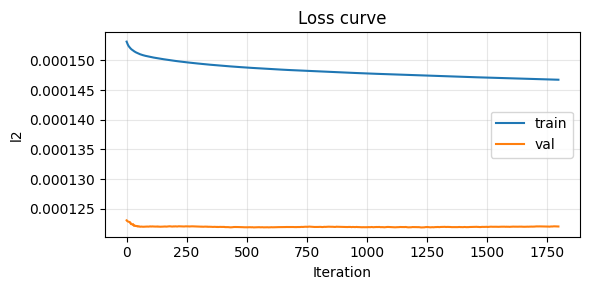

{'val_r2': 0.0017806936515515348,
 'val_rmse': 0.01104764063809563,
 'test_r2': -0.07152998980248304,
 'test_rmse': 0.01362043874027659,
 'val_dir_acc': 0.5169457404732019,
 'test_dir_acc': 0.4986419686023141}

In [ ]:
# Train LGBM
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

X_train = train_df[feature_cols]
y_train = train_df['y']
X_val = val_df[feature_cols]
y_val = val_df['y']
X_test = test_df[feature_cols]
y_test = test_df['y']

model = lgb.LGBMRegressor(**params)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=['train', 'val'],
    eval_metric='l2',
    callbacks=[lgb.log_evaluation(0)],
)

# Loss curve (train/val)
evals = model.evals_result_
train_key = 'train' if 'train' in evals else ('training' if 'training' in evals else None)
val_key = 'val' if 'val' in evals else ('valid_0' if 'valid_0' in evals else ('valid_1' if 'valid_1' in evals else None))
if train_key and val_key:
    metric = next(iter(evals[train_key].keys()))
    plt.figure(figsize=(6, 3))
    plt.plot(evals[train_key][metric], label=train_key)
    plt.plot(evals[val_key][metric], label=val_key)
    plt.title('Loss curve')
    plt.xlabel('Iteration')
    plt.ylabel(metric)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

pred_val = model.predict(X_val)
pred_test = model.predict(X_test)


# direction accuracy (sign match)
val_dir_acc = float((np.sign(pred_val) == np.sign(y_val)).mean())
test_dir_acc = float((np.sign(pred_test) == np.sign(y_test)).mean())

metrics = {
    'val_r2': r2_score(y_val, pred_val),
    'val_rmse': mean_squared_error(y_val, pred_val) ** 0.5,
    'test_r2': r2_score(y_test, pred_test),
    'test_rmse': mean_squared_error(y_test, pred_test) ** 0.5,
    'val_dir_acc': val_dir_acc,
    'test_dir_acc': test_dir_acc,
}
metrics


In [ ]:
# Feature importance (top 20)
import pandas as pd

imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
imp.head(20)


base_in_trigger_process           1209
close_price                         81
base_bond_prem_ratio                72
log_amount                          70
ret_1d                              62
amount                              58
log_base_conv_value                 53
opt_value                           52
base_ytm                            38
log_close_price                     31
base_stk_close_price                28
ovr                                 19
stk_ret_1d                          12
log_base_pure_redemption_value       7
base_conv_value                      5
base_year_to_mat                     2
base_pure_redemption_value           1
prev_close_price                     0
dtype: int32